<h1><center> 
DeepLearning-Based RNA Toehold Switch Functionality Predictor Using CNNs and 2D Complementary RNA Maps
</center></h1>

<center>
Nicolaas M Angenent-Mari<sup>1,2*</sup> Alexander S. Garruss<sup>2,3*</sup>,, Luis R. Soenksen<sup>1,2*</sup>, Diogo M. Camacho<sup>2*</sup>, Katherine M Collins<sup>1*</sup>, George Church<sup>1,2,3,4</sup>, Timothy K. Lu<sup>1,4</sup>, and James J. Collins<sup>1,2,3,4</sup>
</center>


<center><font color=gray><font size="1.5">
<sup>1</sup>Massachusetts Institute of Technology, <sup>2</sup>Wyss Institute for Biologically Inspired Engineering, <sup>3</sup>Harvard John A. Paulson School of Engineering and Applied Sciences, and <sup>4</sup>Broad Institute of MIT and Harvard. *Contributed equally
</font></font></center>


##### Abstract:
<font color=black><font size="2">
A benchmark tool in the field of synthetic biology is the RNA “Toehold-Switch”, a riboregulator that responds to a programmable target to change its secondary structure through strand displacement with up-regulation of a desired protein. Recent advances have streamlined the synthesis of these modules; however, in vitro and in vivo functionality remain highly unpredictable due to complex interactions unanticipated by standard base-pairing models. We are developing and testing aa high-quality library of 244,000 toehold sequences to train and optimize a CNN deep-learning architecture based on RNA contact map tensors to enable accurate biological predictions of novel toehold sensor functionality.
</font></font>

---------------------------------------------------------------------------------------------

References:

> Randal S. Olson, Ryan J. Urbanowicz, Peter C. Andrews, Nicole A. Lavender, La Creis Kidd, and Jason H. Moore (2016). Automating biomedical data science through tree-based pipeline optimization. Applications of Evolutionary Computation, pages 123-137.

>Randal S. Olson, Nathan Bartley, Ryan J. Urbanowicz, and Jason H. Moore (2016). Evaluation of a Tree-based Pipeline Optimization Tool for Automating Data Science. Proceedings of GECCO 2016, pages 485-492.

---------------------------------------------------------------------------------------------

#### DATA STRUCTURE (INPUT / OUTPU)
> Data is loaded from a Toehold Sensor Database (data/2019-03-30_toehold_dataset_proc_with_params.csv) which is comma delimited table  having the following columns of DNA encoded sub-sequences: organism, sequence_class, sequence_id, pre_seq	promoter, trigger, loop1, switch, loop2, stem1, atg, stem2m linkerm post_linker, output	
> #### Input tensor is defined as (DS=Data_Style):
> **DS_1)**  Toehold DNA Sequence <br>
> *NOTE:  Base toehold string sequence [0-144]
> *       GGG  - Trigger - Loop1 - Switch  - Loop2 - Stem1 -  AUG  -  Stem2  -  Linker - Post-linker
> *     [-3,-1]  [0,-29]  [30-49]  [50-79]  [80-90] [91,96] [97,99] [100,108] [109,134]  [135,144]
> *     
> *     For training we select our input sequence vector start with GGG and concatenate everything from "Loop1" to "post-linker"... which is seq_SwitchOFF_GFP  = ggg + seq[30:145].
> *     Also, pre_seq & promoter sub-sequences are NEVER used because they are not converted into mRNA (is in the plasmid but > *     it is never in the functional toehold module), so it won't contribute in secondary structure at all. For this example > *     in particular we use DS_1.*

> #### Output vector is defined as:
> **OUT_1)** ON, Off & ON-OFF State values derived from the experimental testing of toehold switch RNA sequence

#### PROBLEM DEFINITION
> To investigate if a deep learning network can be used to predict toehold switch ON/OFF functionality, because in that case it would suggest the network is learning secondary structure prediction that would be transferable to other RNA based problems.

--------------------------------------------------------------------------------------------------------------------------------------------------------

### STEP 0)   Loading, Import Modules & Core helper functions
#### This code requires the following pre-installs:
> ##### Biopython
> In anaconda env: `conda install -c anaconda biopython` or `pip install biopython`<br>
> Ref: https://github.com/biopython/biopython
> ##### ViennaRNA
> In anaconda env: `conda install -c bioconda viennarna`<br>
> Ref: https://github.com/ViennaRNA/ViennaRNA
> ##### Pysster (Python 3.5+)
> In anaconda env: `pip3 install pysster`<br>
> Ref: https://github.com/budach/pysste

In [1]:
### Import Libraries
# General system libraries
import os
import gc
import cv2
import math
import h5py
import locale
import inspect
import argparse
import numpy as np
import pandas as pd
from time import time
from datetime import datetime
from subprocess import call

# Math & Visualization Libs
import math
import pydot
import graphviz
import seaborn as sns
from matplotlib import pyplot
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from itertools import cycle
from scipy import stats, interp
from IPython.display import Image

# Multiprocessing
import multiprocessing

# DNA/RNA Analysis Libraries (Biopython, ViennaRNA, pysster) 
# > Biopython Lib
import Bio
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio.Alphabet import generic_rna, generic_dna, generic_protein, IUPAC
# > ViennaRNA Lib
import RNA

#RNAssp
import src.RNAssp.rna as rnassp

# Import Tensorflow
import tensorflow as tf

# Import Json
import json
import codecs

# Import Keras
from keras import optimizers
from keras import applications
from keras import regularizers
from keras import backend as K
from keras.models import Sequential, load_model
from keras.models import model_from_json, load_model
from keras.layers import Activation, Conv1D, Conv2D, Reshape, BatchNormalization, Dropout, Flatten, Dense, merge, Input, Lambda, InputLayer, Convolution2D, MaxPooling1D, MaxPooling2D, ZeroPadding2D, Bidirectional
from keras.layers.recurrent import LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras.applications.imagenet_utils import decode_predictions, preprocess_input
from keras.wrappers.scikit_learn import KerasClassifier
from keras.wrappers.scikit_learn import KerasRegressor
from keras.models import Model
from keras.optimizers import Adam
from keras.utils import np_utils
from keras.utils import multi_gpu_model
from keras.utils import plot_model
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras_tqdm import TQDMNotebookCallback
from keras.callbacks import ModelCheckpoint

#Import Keras-Vis for Saliency
from vis.utils import utils
from vis.visualization import get_num_filters
from vis.visualization import visualize_activation, visualize_saliency, visualize_cam, overlay
    ## NOTE: Install in conda enviroment: pip install git+https://github.com/raghakot/keras-vis.git -U

# Import sklearn libs
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, normalize
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PowerTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import explained_variance_score, mean_absolute_error
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.metrics import median_absolute_error, r2_score
from sklearn.metrics import roc_curve, auc
    ## NOTE: Activate a new terminal to monitor NVIDIA GPU usage writing
        # watch -n0.5 nvidia-smi
    ## NOTE: If not present, activate GPU persistence mode in terminal with
        # sudo nvidia-smi -pm 1
    ## If you do not see any GPU usage try uncommenting the following line:
        # sess = tf.Session(config=tf.ConfigProto(log_device_placement=True)) #To ensure activation of GPUs in TF Backend

# Progress Bar
from tqdm import tqdm

# Warnings
import warnings
warnings.filterwarnings("ignore")

#Visualization mode
#%matplotlib ipympl

Using TensorFlow backend.


In [2]:
## Define helper function to copy full directory for backups
def copy_full_dir(source, target):
    call(['cp', '-a', source, target]) # Unix

#Get available CPUs,
ncpus = multiprocessing.cpu_count()
print('Available CPUs: '+ str(ncpus))

#Get number of available GPUs
def get_available_gpus():
    from tensorflow.python.client import device_lib
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']
ngpus = len(get_available_gpus())
print('Available GPUs: '+ str(ngpus))

Available CPUs: 32
Available GPUs: 4


-----------------------------------------------------------------------------------------------------------------------------

### 1) Import Dataset & Define Raw Input(s)/Output(s)
> Full data CSV read, includes all necessary information to train and test

In [3]:
# Create Data folder if not existent
data_folder = "data/"
if not os.path.isdir(data_folder):
    os.makedirs(data_folder)
    
## Define general path to store all generated models
core_models_path = 'models/'
# Create Data folder if not existent
if not os.path.isdir(core_models_path):
    os.makedirs(core_models_path)

# Define path to load desired Toehold dataset file (.csv)
data_filename = "2019-07-08_toehold_dataset_proc_with_params_QC1_1.csv"
data_path = data_folder + data_filename
data = pd.read_csv(data_path)

# Fix random seed for reproducibility
seed = 7
np.random.seed(seed) # Seed can be any number

In [4]:
### Datata Sequence ID selection
id_data = data['sequence_id']

### Toehold Switch dataset input/output columns for selection
input_cols = 'seq_SwitchON_GFP'
output_cols = ['ON', 'OFF', 'ON_OFF']
qc_levels = [1.1,1,2,3,4]
doTrain = True
loss_init = 'mae' #'logcosh', #'mse', 'mae', 'r2'
n_foldCV = 10
verbose_init = True
evaluate  = True
display_init = True
n_filters_init = 10

### Define data scaler (if any)
scaler_init = True
scaler = QuantileTransformer(output_distribution='uniform')

### DEFINE MODEL NAME (e.g. MLP, CNN, LSTM, etc.)
model_name = 'CNN_2D_148'

#Show sample of dataframe structure
data.head()

off_id  \
0  AACCAAACACACAAACGCACAAAAAAAAAAAAAAAAAATGGAAAAC...   
1  AACCAAACACACAAACGCACAAAAAAAAAAAAATGGAAAACAGTTA...   
2  AACCAAACACACAAACGCACAAAAAAAAATTACTACTATTGTTAAT...   
3  AACCAAACACACAAACGCACAAAAAAAATAACGTAGGACTACTACT...   
4  AACCAAACACACAAACGCACAAAAAAAATGGAAAACAGTTACTAAT...   

                                               on_id source_sequence  \
0  AACTGTTTTCCATTTTTTTTTTTTTTTTTTAACCAAACACACAAAC...        smallpox   
1  TTAGTAACTGTTTTCCATTTTTTTTTTTTTAACCAAACACACAAAC...        smallpox   
2  CTAAATTAACAATAGTAGTAATTTTTTTTTAACCAAACACACAAAC...        smallpox   
3  TCCAAGTAGTAGTCCTACGTTATTTTTTTTAACCAAACACACAAAC...        smallpox   
4  ACATATTAGTAACTGTTTTCCATTTTTTTTAACCAAACACACAAAC...        smallpox   

          sequence_id               pre_seq              promoter  \
0  smallpox_tile_2626  CTCTGGGCTAACTGTCGCGC  TAATACGACTCACTATAGGG   
1  smallpox_tile_2625  CTCTGGGCTAACTGTCGCGC  TAATACGACTCACTATAGGG   
2  smallpox_tile_4951  CTCTGGGCTAACTGTCGCGC  TAATACGACTCACTATAGGG   
3  smallpox_tile_6492  CTCTGGGCTAACTGTCGCGC  TAATACGACTCACTATAGGG   
4  smallpox_tile_2624  CTCTGGGCTAACTGTCGCGC  TAATACGACTCACTATAGGG   

                          trigger                 loop1  \
0  AACTGTTTTCCATTTTTTTTTTTTTTTTTT  AACCAAACACACAAACGCAC   
1  TTAGTAACTGTTTTCCATTTTTTTTTTTTT  AACCAAACACACAAACGCAC   
2  CTAAATTAACAATAGTAGTAATTTTTTTTT  AACCAAACACACAAACGCAC   
3  TCCAAGTAGTAGTCCTACGTTATTTTTTTT  AACCAAACACACAAACGCAC   
4  ACATATTAGTAACTGTTTTCCATTTTTTTT  AACCAAACACACAAACGCAC   

                           switch        loop2    ...     Cbn1_off  Cbn2_off  \
0  AAAAAAAAAAAAAAAAAATGGAAAACAGTT  AACAGAGGAGA    ...     0.000000  1.000000   
1  AAAAAAAAAAAAATGGAAAACAGTTACTAA  AACAGAGGAGA    ...          NaN       NaN   
2  AAAAAAAAATTACTACTATTGTTAATTTAG  AACAGAGGAGA    ...     1.000000  0.000000   
3  AAAAAAAATAACGTAGGACTACTACTTGGA  AACAGAGGAGA    ...     0.883458  0.116542   
4  AAAAAAAATGGAAAACAGTTACTAATATGT  AACAGAGGAGA    ...     0.815066  0.000000   

   Cbn3_off Cbn4_off        ON       OFF    ON_OFF QC_ON QC_OFF QC_ON_OFF  
0  0.000000      0.0       NaN  0.333333       NaN   NaN    NaN       NaN  
1       NaN      NaN       NaN       NaN       NaN   NaN    NaN       NaN  
2  0.000000      0.0  0.068295  0.000000  0.068295   2.0    1.1       1.1  
3  0.000000      0.0  0.000000  0.038847 -0.038847   1.1    2.0       1.1  
4  0.184934      0.0  0.080666  0.123289 -0.042624   2.0    3.0       2.0  

[5 rows x 99 columns]

-----------------------------------------------------------------------------------------------------------------------------

### 2) Definition of Pre-Processing Input(s)/Output(s) functions

> Define helper functions for one-hot encoding and Generation of Connectivity Map Tensors

> Definition of full input and output vectors for the network

In [5]:
# Helper function to pass string DNA/RNA sequence to one-hot
def dna2onehot(seq):
    #get sequence into an array
    seq_array = np.array(list(seq))
    
    #integer encode the sequence
    label_encoder = LabelEncoder()
    integer_encoded_seq = label_encoder.fit_transform(seq_array)
    
    #one hot the sequence
    onehot_encoder = OneHotEncoder(sparse=False, categories='auto')
    #reshape because that's what OneHotEncoder likes
    integer_encoded_seq = integer_encoded_seq.reshape(len(integer_encoded_seq), 1)
    onehot_encoded_seq = onehot_encoder.fit_transform(integer_encoded_seq)
    
    return onehot_encoded_seq

In [6]:
# Function definition to create complementary matrix of RNA molecule from DNA
def one_hot_special_complementarity_directional_matrix(x, show=False):
    """Produce complementarity matrix for the given RNA molecule.
    by Luis Soenksen 2019-03-15
    Complementary bases (according to Watson-Crick) are assigned the following values:
    G-C are assigned 6 = [0 0 0 0 0 0 1], 
    C-G are assigned 5 = [0 0 0 0 0 1 0], 
    A-U are assigned 4 = [0 0 0 0 1 0 0],
    U-A are assigned 3 = [0 0 0 1 0 0 0],
    G-U are assigned 2 = [0 0 1 0 0 0 0], 
    U-G are assigned 1 = [0 1 0 0 0 0 0], 
    NonWCpairs are   0 = [1 0 0 0 0 0 0],

    Args:
        m: Molecule object (DNA or RNA)
        show (bool): Make a matrix plot of the result.

    Returns:
        p_oh: One-Hot Encoded Categorical Complementarity-directional Matrix
        p: Categorical(integer) Complementarity-directional Matrix
    """
    # Imports
    from keras.utils import to_categorical
    
    if isinstance(x, str):
    # If input is string do this
        # Generate complementary matrix from sequence str & calculated dot-bracket secondary structure
        seq = Bio.Seq.transcribe(x) #Each row in the series is a toehold sequence
        (ss, _ ) = RNA.fold(seq) # Compute corresponding secondary structure (to generate molecule object)
        m = rnassp.Molecule(seq, ss) # Generate molecule object to get complementarity matrix
        l = len(m.seq)
        p = np.zeros((l, l), dtype='int8')
        for i in range(l):
            for j in range(l):
                if m.seq[i] == 'G' and m.seq[j] == 'C' :
                    p[i, j] = 6
                if m.seq[i] == 'A' and m.seq[j] == 'U' :
                    p[i, j] = 4  
                if m.seq[i] == 'G' and m.seq[j] == 'U' :
                    p[i, j] = 2

                # By default... if m.seq[i] == m.seq[j] ; p[i, j] = 0

                if m.seq[i] == 'C' and m.seq[j] == 'G':
                    p[i, j] = 5
                if m.seq[i] == 'U' and m.seq[j] == 'A':
                    p[i, j] = 3  
                if m.seq[i] == 'U' and m.seq[j] == 'G':
                    p[i, j] = 1

        if show:
            fig = plt.figure(dpi=300)
            ax = fig.add_subplot(111)
            cmap = plt.get_cmap('jet', np.max(p)-np.min(p)+1)
            pos = ax.matshow(p, interpolation='nearest', cmap=cmap)
            ax.set_xticks(np.arange(l))
            ax.set_yticks(np.arange(l))
            ax.set_xticklabels([i for i in m.seq], fontsize=2)
            ax.set_yticklabels([i for i in m.seq], fontsize=2)

            # Add colorbar to make it easy to read the energy levels
            cbar = plt.colorbar(pos, ticks=np.arange(np.min(p),np.max(p)+1))
            cbar.ax.set_yticklabels(['N', 'U-G', 'G-U', 'U-A', 'A-U', 'C-G', 'G-C']) 
            plt.show()                    
       
                    
    elif (isinstance(x, np.ndarray) and np.array_equal(x , x.astype(bool))):
    # If input is one-hot encoded
        m = x  
        l = len(m)
        p = np.zeros((l, l), dtype='int8')

        A = np.array([1.,0.,0.,0.])
        C = np.array([0.,1.,0.,0.])
        G = np.array([0.,0.,1.,0.])
        U = np.array([0.,0.,0.,1.]) # "T" or "U"

        for i in range(l):
            for j in range(l):
                if (np.array_equal(m[i], G) and np.array_equal(m[j], C)):
                    p[i, j] = 6
                if (np.array_equal(m[i], A) and np.array_equal(m[j], U)):
                    p[i, j] = 4  
                if (np.array_equal(m[i], G) and np.array_equal(m[j], U)):
                    p[i, j] = 2

                # By default... if m.seq[i] == m.seq[j] ; p[i, j] = 0

                if (np.array_equal(m[i], C) and np.array_equal(m[j], G)):
                    p[i, j] = 5
                if (np.array_equal(m[i], U) and np.array_equal(m[j], A)):
                    p[i, j] = 3  
                if (np.array_equal(m[i], U) and np.array_equal(m[j], G)):
                    p[i, j] = 1 
    
    else:
        p = np.empty([len(x),len(x),7])
    
    p_oh = to_categorical(p[:,:]) #Convert to one hot     
    p_oh_tensor = tf.convert_to_tensor(p_oh) #Convert to one hot           
    return p_oh_tensor, p_oh, p

In [7]:
# Function to generate single complementary matrix array from linear toehold sequence
def seq2complementaryMap(x):
    _, p_oh , _ = one_hot_special_complementarity_directional_matrix(x, show=False)
    out = p_oh.astype(bool)
    return out

In [8]:
def seq2FlatComplementaryMap(x):
    _, _, p = one_hot_special_complementarity_directional_matrix(x, show=False)
    out = p
    return out

In [9]:
# Function to generate single complementary matrix array from linear toehold sequence
def seq2complementaryMap_output_shape(input_shape):
    # Generate complementary matrix from sequence str & calculated dot-bracket secondary structure
    return (tuple(input_shape[0]),tuple(input_shape[0]),tuple(7))

In [10]:
# INPUT / OUTPUT DEFINITION, PROCESSING & LOADING
def pre_process_data (data, input_cols, output_cols, export_path, qc_level_threshold=1, scaler_init=False, display=True):
    ## OUTPUT / INPUT DEFINITION, PROCESSING & LOADING
    
    #Init process bar
    tqdm.pandas() # Use `progress_apply` when `applying` one hot encoding and complementarity function to dataframe of input sequences

    # Define path to store input / output arrays
    tmp_data_path = 'data/tmp/'
    # Create Data folder if not existent
    if not os.path.isdir(tmp_data_path):
        os.makedirs(tmp_data_path)
    
    # GENERATE & SAVE FULL INPUT VECTORS (only if not exists because it is a large file)
    tmp_data_input_path = (tmp_data_path + 'data_input_file_2d_' + input_cols + '.h5')
    if not os.path.exists(tmp_data_input_path):
        # Data Input selection & Generation if absent (or delete it to re-calculate)
        n_batch_samples = 10000 #We constrain process batches to this number to allow for progressive saving of large files
        n_batches = math.ceil(len(data[input_cols])/n_batch_samples)
        
        if n_batches>1:
            print('Processing in ' + str(n_batches) + ' batches...')
            
        # Process and Append Save:
        with h5py.File(tmp_data_input_path, 'a') as hf:
            is_first=True
            for data_tmp in np.split(data[input_cols], n_batches):
                df_data_input_tmp = data_tmp.progress_apply(seq2complementaryMap)
                data_input_tmp = np.array(list(df_data_input_tmp.values))
                if is_first==True:
                    hf.create_dataset("input",  data=data_input_tmp, maxshape=(None, data_input_tmp.shape[1], data_input_tmp.shape[2], data_input_tmp.shape[3]), chunks=(n_batches,data_input_tmp.shape[1], data_input_tmp.shape[2], data_input_tmp.shape[3])) 
                    is_first=False
                else:
                    hf["input"].resize(( hf["input"].shape[0]+data_input_tmp.shape[0],data_input_tmp.shape[1],data_input_tmp.shape[2],data_input_tmp.shape[3]))  
                    hf["input"][-data_input_tmp.shape[0]:,:,:] = data_input_tmp
    
    # GENERATE & SAVE FULL INPUT VECTORS (NPY OPTION)
    #tmp_data_input_path = (tmp_data_path + 'data_input_file_2d_' + input_cols + '.npy')
    #if not os.path.exists(tmp_data_input_path):
    #    # Data Input selection & Generation if absent (or delete it to re-calculate)
    #    df_data_input = data[input_cols].progress_apply(seq2complementaryMap)
    #    data_input = np.array(list(df_data_input.values))
    #    #Save:
    #    np.save(tmp_data_input_path, data_input) #Save npy file
        
    # GENERATE & SAVE FULL OUTPUT VECTORS
    output_ids = "_".join(str(x) for x in output_cols)
    tmp_data_output_path = (tmp_data_path + 'data_output_file_QC_' + str(qc_level_threshold).replace('.','-') + '_' + output_ids + '.h5')
    
    # Data Output selection (QC filtered, OutColumns Only & Drop NaNs)
    df_data_output = data[data.QC_ON_OFF >= qc_level_threshold]
    df_data_output= df_data_output[output_cols]
    df_data_output = df_data_output.dropna(subset=output_cols)
    data_output = df_data_output.as_matrix().astype('float32')
    
    #Save:
    with h5py.File(tmp_data_output_path, 'w') as hf:
        hf.create_dataset("output",  data=data_output)
    
    #Load full input array in memory and QC filter
    data_input = np.load(tmp_data_input_path, mmap_mode='r') #Loading with read from hard-disk
    data_input = data_input[df_data_output.index.values][:][:]
    
    # LOAD FULL OUTPUT ARRAY in memory and QC filter
    with h5py.File(tmp_data_output_path, 'r') as hf:
        data_output = hf['output'][:]
        data_output_orig = data_output
        #Pre-process data (scaler)
        if scaler_init==True:
            data_output = scaler.fit_transform(data_output)
    
    # LOAD FULL LIST OF SEQUENCES after filtering
    data_seqs = data[input_cols][df_data_output.index.values]
    
    
    # Display processed data if desired
    if display==True:
        ### Show example of processed dataset
        ## Display number of retrieved sequences
        print("Number of sequences retrieved: "+str(len(data_input)))
        print()

        #Select ID to show
        toehold_id = 0 

        ## Plot Example input complementarity toehold matrix 
        print('EXAMPLE OF INPUT ONE-HOT COMPLEMENTARITY TOEHOLD MATRIX (COLOR CODED)')
        p_oh_tensor, p_oh, p = one_hot_special_complementarity_directional_matrix(data_seqs.iloc[toehold_id], show=True)
        print()
    
        # Display input size
        print("Input Size: " + str(p_oh_tensor.shape))
        print()

        # Display example of Output vector
        print('EXAMPLE OF OUTPUT VECTOR')
        print(' ' + str(data_output[toehold_id]))
        print()

        # Display Output Values
        for index,item in enumerate(output_cols):
            # Display Output Values
            plt.figure()
            print('Distribution of ' + str(item) + ' Values')
            sns.distplot(data_output[:,index], kde=True, rug=False)
            #Tight plot
            plt.tight_layout()
            # Save figure
            plt.savefig(export_path + "/QC_" + str(qc_level_threshold).replace('.','-') + "_" + str(item) + "_dist.png", bbox_inches='tight', dpi=300)
        
        if scaler_init==True:           
            ## COMPUTE EFFECT OF SCALER
            # Difference between the transformed toehold output values and original toehold output values, 
            # then compute the absolute percentage difference for diplay
            test_metrics = np.zeros((data_output_orig.shape[1],3))
            diff = data_output_orig - data_output
            abstDiff = np.abs(diff)
            # Compute the mean and standard deviation of the absolute difference:
            apd_mean = np.mean(abstDiff, axis=0)
            apd_std = np.std(abstDiff, axis=0)
            apd_r2 = np.zeros_like(apd_mean)
            
            # Plot: Scaled Output values vs. Original values and get R2 value
            for index,item in enumerate(output_cols):
                # R2 (Coefficient of Determination)
                apd_r2[index] = r2(data_output_orig[:,index], data_output[:,index])
                
                # Display Output Values
                x=np.squeeze(data_output_orig[:,index])
                y=np.squeeze(data_output[:,index])
                
                # Display Output Values
                print('')
                print("" + item + " Mean_absolute_error (TRANSFORMATION): " + str(apd_mean[index]) + " (SD: " + str(apd_std[index]) + ")" )
                print('')
                print('TRANSFORMED Values vs. ORIGINAL values (' + item + ')' )
                print('Pearson Correlation: '+ str(stats.pearsonr(x, y)[0]))
                print('Spearman Correlation: '+ str(stats.spearmanr(x, y)[0]))
                print('R2: '+ str(apd_r2[index]))
                print('')
                
                if scaler_init == True:
                    g = sns.jointplot(x, y, kind="reg", color="b", xlim=(-0.2, 1.2), ylim=(-0.2, 1.2), stat_func=r2)
                else:
                    g = sns.jointplot(x, y, kind="reg", color="b", stat_func=r2)
                g.plot_joint(plt.scatter, c="b", s=1, linewidth=1, marker=".", alpha=0.08)
                g.plot_joint(sns.kdeplot, zorder=0, color="m", n_levels=6, shade=False)
                g.ax_joint.collections[0].set_alpha(0)
                g.set_axis_labels("$ORIGINAL$", "$TRANSFORMED$");

                # save the figure
                g.savefig(export_path + "/QC_" + str(qc_level_threshold).replace('.','-') + "_" + str(item) + "_data_scaling_" + str(item) + ".png", bbox_inches='tight', dpi=300)
                
                # Store model performance metrics for return   
                test_metrics[index, :] = [apd_mean[index], apd_std[index], apd_r2[index]]
                
            # SAVE METRICS (.npy file)
            np.save(export_path + '/scaling_metrics',test_metrics)
            # SAVE DATA (.npz file)
            np.savez(export_path + '/scaling_data',data_output_orig,data_output) 
            
    return data_input, data_output

-----------------------------------------------------------------------------------------------------------------------------

### 3) Definition of Model Architecture Function
> Funtion to create keras model architecture
> Helper functions to save and evaluate models

In [11]:
## Function to create Keras CNN for regression prediction
def create_2d_cnn(width, height, depth, filters=[32, 64, 128], regress=False):
    # initialize the input shape and channel dimension, assuming
    # TensorFlow/channels-last ordering
    inputShape = (width, height, depth) #DNA/RNA complementary matrix input sequence (one hot encoded)
    chanDim = -1
    dropout_init = 0.3
    
    # define the model input
    inputs = Input(shape=inputShape)

    # loop over the number of filters
    for (i, f) in enumerate(filters):
        # if this is the first CONV layer then set the input appropriately
        if i == 0:
            x = inputs
    
        # CONV => RELU => BN => POOL
        #x = Conv2D(f, (5,5), padding="same", kernel_regularizer=regularizers.l1_l2(l1=0.0005, l2=0.0005))(x)
        x = Conv2D(f, (5,5), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=chanDim)(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
        
    # flatten the volume, then FC => RELU => BN => DROPOUT
    x = Flatten()(x)
    x = Dense(16)(x)
    x = Activation("relu")(x)
    x = BatchNormalization(axis=chanDim)(x)
    x = Dropout(dropout_init)(x)
    
    # apply another FC layer, this one to potentially match the number of nodes 
    # in a parallel network (i.e MLP with rational parameters)
    x = Dense(16)(x)
    x = Activation("relu")(x)
    
    # check to see if the regression node should be added
    if regress:
        x = Dense(len(output_cols), activation="linear")(x)
    else:
        x = Dense(len(output_cols), activation="sigmoid")(x)

    # Construct the Model
    model = Model(inputs, x) 
    
    # Return the model
    return model

In [12]:
# Helper functions to save/load model and training history
def saveHist(path,history):
    new_hist = {}
    for key in list(history.history.keys()):
        if type(history.history[key]) == np.ndarray:
            new_hist[key] == history.history[key].tolist()
        elif type(history.history[key]) == list:
            if  type(history.history[key][0]) == np.float64:
                new_hist[key] = list(map(float, history.history[key]))

    with codecs.open(path, 'w', encoding='utf-8') as f:
        json.dump(new_hist, f, separators=(',', ':'), sort_keys=True, indent=4) 
        
def loadHist(path):
    with codecs.open(path, 'r', encoding='utf-8') as f:
        n = json.loads(f.read())
    return n

def save_model(model, identifier):
    ## MODEL SAVING ON WORKING FOLDER
    # Option 1: Save via Weights + Architecture
    model.save_weights(os.path.abspath(model_path)+'/model_weights_'+str(identifier)+'.h5')
    with open(os.path.abspath(model_path)+'/model_architecture_'+str(identifier)+'.json', 'w') as f:
        f.write(model.to_json())

    # Option 2: Save entire model at once
    model.save(os.path.abspath(model_path)+'/model_'+str(identifier)+'.h5')

In [13]:
#Definition of R2 metric for testing
def r2(x, y):
    return stats.pearsonr(x, y)[0] ** 2

#Definition of Custom metric as loss related to Coefficient of Determination (R2) 
#  CoD = 1 - MSE / (variance of inputs), and since this is going to be a loss we want 
#  improvement to point towards zero, so we choose mse/variance of inputs
def custom_r2_loss(y_true, y_pred): 
    from keras import backend as K
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return (SS_res/(SS_tot + K.epsilon()))

#Definition of Custom metric as loss related to Weigted Mean Absolute error
#  Improvement points towards zero, but penalizes loss for small values and improves it for larger values
def custom_wmae_loss(y_true, y_pred): 
    from keras import backend as K
    weightedMAE = K.abs((y_true-y_pred)*y_true) #Increase loss for large ON or OFF values -- Skews focus of distribution right
    return weightedMAE

In [14]:
def batch_generator(X, Y, batch_size = 1):
    indices = np.arange(len(X)) 
    batch=[]
    while True:
            for i in indices:
                batch.append(i)
                if len(batch)==batch_size:
                    yield X[batch], Y[batch]
                    batch=[]

### 4) Definition of BASE Model Generator (with Training using Manual Verification Dataset & Evaluation)
> For use with a priori training (suggested: 75%) & testing (suggested: 25%) split, with internal training validation from the training set (10% or the 75%)
> For evaluation on unseen testing data (suggested: 25%) 
> This generator function generates and saves model in target path

In [15]:
### Define our final model architecture (layers & optimizor) and then compile it
def generate_model(model_path, trainX, testX, trainY, testY, verbose_init, evaluate=True):
    
    ## DEEP-LEARNING TRAINING PARAMETERS(e.g. verbose, patients, epoch size, batch size) to constrain process
    verbose_init = verbose_init #Zero is no keras verbose
    patience_init = 20 # Number of epochs to wait for no model improvement before early stopping a training
    epochs_init = 300 # Max number of epochs to perform (to cap training time)
    batch_size_init = 64*(1+ngpus) # number of samples that will be propagated through the network at every epoch dependent on the number of GPUs
    validation_spit_init = 0.1 # Percentage of testing data to use in internal validation during training
    
    ## Create folder to store model (if not existent)
    if not os.path.isdir(model_path):
        os.makedirs(model_path)
        
    ## Callbacks for training:
    #  Save the model weights to the same file, if and only if the validation accuracy improves.
    checkpoint_file_name = "model_checkpoint_weights.h5"
    model_checkpoint_path = os.path.join(os.path.abspath(model_path), checkpoint_file_name)
    
    if verbose_init==True:
        # Callback to be used for checkpoint generation and early stopping
        callbacks_list = [ModelCheckpoint(model_checkpoint_path, monitor='val_loss', verbose = verbose_init, save_best_only=True, mode='auto'),
                          EarlyStopping(monitor='val_loss', patience=patience_init, verbose = verbose_init),
                          TQDMNotebookCallback()] # Adds Keras integration with TQDM progress bars.
    else:
        # Callback to be used for checkpoint generation and early stopping
        callbacks_list = [ModelCheckpoint(model_checkpoint_path, monitor='val_loss', verbose = False, save_best_only=True, mode='auto'),
                          EarlyStopping(monitor='val_loss', patience=patience_init, verbose = False)]    
    
    ## Create Model (Change for MLP, CNN, ETC)
    # -------------------------------------------------------------------------------------------------------------------------------------
    # Define CNN model input shape
    (width, height, depth) = np.shape(trainX[0])
    
    # Define core model on CPU
    with tf.device("/cpu:0"):  
        model = create_2d_cnn(width, height, depth, filters=[32, 64, 128], regress=True)
        
    ## Initialize the optimizer and Compile model:
    #   Custom metric is used (see above), if we use "Mean absolute percentage error" that
    #   implies that we seek to minimize the absolute percentage difference between 
    #   our *predictions* and *actual* output values. We also calculate other 
    #   valuable metrics for regression evaluation 
    opt = Adam(lr=0.03, epsilon=None, decay=1e-3/200, amsgrad=False) # epsilon=1e-1 for POISSON loss, lr=0.001 is standard but 0.1 leads to more diagonal features
    
    if loss_init=="r2":
        model.compile(loss=custom_r2_loss, optimizer=opt,  metrics=['mse','mae', 'mape', 'cosine','acc', custom_r2_loss])
    elif loss_init =="wmae":
        model.compile(loss=custom_wmae_loss, optimizer=opt,  metrics=['mse','mae', 'mape', 'cosine','acc', custom_wmae_loss])
    else:
        model.compile(loss=loss_init, optimizer=opt,  metrics=['mse','mae', 'mape', 'cosine','acc']) 
        
    # -------------------------------------------------------------------------------------------------------------------------------------  
    
    
    ## Parallel computing (if multiple GPUs are available)
    # Define model for training (CPU, Single GPU or Multi-GPU depending on availability of resources)
    if ngpus<=1:
        print("[INFO] training with Single GPU or CPU...")
        model_history = model.fit(trainX, trainY, validation_split=validation_spit_init, epochs=epochs_init, batch_size=batch_size_init, callbacks=callbacks_list, verbose=verbose_init)

    else:
        print("[INFO] training with {} GPUs...".format(ngpus))
        # make the model parallel
        parallel_model = multi_gpu_model(model, gpus=ngpus)
        
        if loss_init=="r2":
            parallel_model.compile(loss=custom_r2_loss, optimizer=opt,  metrics=['mse','mae', 'mape', 'cosine','acc', custom_r2_loss])
        elif loss_init =="wmae":
            parallel_model.compile(loss=custom_wmae_loss, optimizer=opt,  metrics=['mse','mae', 'mape', 'cosine','acc', custom_wmae_loss])
        else:
            parallel_model.compile(loss=loss_init, optimizer=opt,  metrics=['mse','mae', 'mape', 'cosine','acc']) 
        
        model_history = parallel_model.fit(trainX, trainY, validation_split=validation_spit_init, epochs=epochs_init, batch_size=batch_size_init, callbacks=callbacks_list, verbose=verbose_init)    
                    

    ## MODEL SAVING
    # Option 1: Save via Weights + Architecture
    model.save_weights(os.path.abspath(model_path)+'/model_weights.h5')
    with open(os.path.abspath(model_path)+'/model_architecture.json', 'w') as f:
        f.write(model.to_json())
    # Option 2: Save entire model at once
    model.save(os.path.abspath(model_path)+'/model.h5')
    # Save model graph to file
    model_graph_path = os.path.abspath(model_path) + '/model_graph.png'
    plot_model(model, to_file=model_graph_path, show_shapes=True, show_layer_names=True)
    # Save training history
    saveHist(model_path + '/model_history', model_history)
        
    ## MODEL LOADING (to ensure it works)
    # Option 1: Load latest model via Weights + Architecture
    #with open(os.path.abspath(model_path)+'/model_architecture.json', 'r') as f:
    #    model = model_from_json(f.read())
    #    model.load_weights(os.path.abspath(model_path)+'/model_weights.h5')
    # Option 2: Load latest model via entire model at once
    if loss_init=="r2":
        model = load_model(os.path.abspath(model_path)+'/model.h5', custom_objects={'custom_r2_loss': custom_r2_loss})
    elif loss_init =="wmae":
        model = load_model(os.path.abspath(model_path)+'/model.h5', custom_objects={'custom_wmae_loss': custom_wmae_loss})
    else:
        model = load_model(os.path.abspath(model_path)+'/model.h5')
    
    # Load model training history
    model_history = loadHist(model_path + '/model_history')
    
    # Init prediction output matrix
    testX_Preds = np.zeros_like(testY) #Empty matrix for full prediction evaluation
    # Init performance metrics matrix
    test_metrics = np.zeros((trainY.shape[1],3)) #Empty matrix for model performance metrics
    
    # GENERATE PREDICTIONS
    if testX.size > 0:
        ## Make predictions on testing data:
        print("Predicting functionality of Test Toeholds ...")
        print("")
        #Predictions in scaled space
        testX_Preds = model.predict(testX)
        
        
        if scaler_init == True:
            testY = scaler.inverse_transform(testY)
            testX_Preds = scaler.inverse_transform(testX_Preds)
        
        ## EVALUATE PERFORMANCE OF MODEL
        if evaluate==True:
            ## Plot training metrics per fold:
            plt.figure ()
            ax1 = plt.subplot(221)
            ax2 = plt.subplot(222)
            ax3 = plt.subplot(223)
            ax4 = plt.subplot(224)
            # Plot MSE metric
            ax1.set_title("Mean squared error")
            ax1.plot(model_history['mean_squared_error'])
            # Plot MAE metric
            ax2.set_title("Mean absolute error")
            ax2.plot(model_history['mean_absolute_error'])
            # Plot MAPE metric
            ax3.set_title("Mean absolute percentage error")
            ax3.plot(model_history['mean_absolute_percentage_error'])
            # Plot CP metric
            ax4.set_title("Cosine Proximity")
            ax4.plot(model_history['cosine_proximity'])
            #Tight plot
            plt.tight_layout()
            # Save figure
            plt.savefig(model_path + "/model_training_metrics.png", bbox_inches='tight', dpi=300)

            ## Plot compiled training metrics per fold:
            plt.figure()
            plt.style.use("default")
            N = np.arange(0, len(model_history["loss"]))
            # Plot used Loss metric
            plt.plot(N, model_history["loss"], label="train_loss")
            plt.plot(N, model_history["val_loss"], label="test_loss")
            # Plot used Accuracy metric (applicable only if categorical model)
            plt.plot(N, model_history["acc"], label="train_acc")
            plt.plot(N, model_history["val_acc"], label="test_acc")
            # Plot MSE metric
            plt.plot(N, model_history["mean_squared_error"], label="train_mse")
            plt.plot(N, model_history["val_mean_squared_error"], label="test_mse")
            # Plot MAE metric
            plt.plot(N, model_history["mean_absolute_error"], label="train_mae")
            plt.plot(N, model_history["val_mean_absolute_error"], label="test_mae")
            # Plot MAPE metric
            plt.plot(N, model_history["mean_absolute_percentage_error"], label="train_mape")
            plt.plot(N, model_history["val_mean_absolute_percentage_error"], label="test_mape")
            # Plot CP metric
            plt.plot(N, model_history["cosine_proximity"], label="train_cp")
            plt.plot(N, model_history["val_cosine_proximity"], label="test_cp")
            plt.title("CNN Toehold Complementary Rep Data")
            plt.xlabel("Epoch #")
            plt.ylabel("Loss/Accuracy")
            plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.) # Place a legend to the right of this smaller subplot.
            # Save figure
            plt.savefig(model_path + "/model_training_compilation.png", bbox_inches='tight', dpi=300)
            
            
            ## COMPUTE PERFORMANCE METRICS
            # Difference between the *predicted* toehold functionality values and *actual* toehold functionality values, 
            # then compute the absolute percentage difference for diplay
            diff = testX_Preds - testY
            abstDiff = np.abs(diff)
            # Compute the mean and standard deviation of the absolute difference:
            apd_mean = np.mean(abstDiff, axis=0)
            apd_std = np.std(abstDiff, axis=0)
            apd_r2 = np.zeros_like(apd_mean)
            # Plot: Predicted values vs. Experimental values and get R2 value
            for index,item in enumerate(output_cols):

                # R2 (Coefficient of Determination)
                apd_r2[index] = r2(testX_Preds[:,index], testY[:,index])
                
                # Display Output Values
                x=np.squeeze(testX_Preds[:,index])
                y=np.squeeze(testY[:,index])
                
                # Display Output Values
                print("" + item + " Mean_absolute_error (TEST): " + str(apd_mean[index]) + " (SD: " + str(apd_std[index]) + ")" )
                print('')
                print('EXPERIMENTAL Values vs. PREDICTED values (' + item + ')' )
                print('Pearson Correlation: '+ str(stats.pearsonr(x, y)[0]))
                print('Spearman Correlation: '+ str(stats.spearmanr(x, y)[0]))
                print('R2: '+ str(apd_r2[index]))
                print('')
                
                if scaler_init == True:
                    g = sns.jointplot(x, y, kind="reg", color="b", xlim=(-0.2, 1.2), ylim=(-0.2, 1.2), stat_func=r2)
                else:
                    g = sns.jointplot(x, y, kind="reg", color="b", stat_func=r2)
                
                g.plot_joint(plt.scatter, c="b", s=1, linewidth=1, marker=".", alpha=0.08)
                g.plot_joint(sns.kdeplot, zorder=0, color="m", n_levels=6, shade=False)
                g.ax_joint.collections[0].set_alpha(0)
                g.set_axis_labels("$PREDICTED$", "$EXPERIMENTAL$");

                # save the figure
                g.savefig(model_path + "/model_performance_" + str(item) + ".png", bbox_inches='tight', dpi=300)
                
                # Store model performance metrics for return   
                test_metrics[index, :] = [apd_mean[index], apd_std[index], apd_r2[index]]
                
            # SAVE METRICS (.npy file)
            np.save(model_path + '/test_metrics',test_metrics)
            # SAVE DATA (.npz file)
            np.savez(model_path + '/test_data',testX_Preds, testY) 
                
    return model, model_history, testX_Preds, test_metrics

--------------------------------------------------------------------------------------------------------------------------------------------------------

### 5)  Definition of k-Fold Cross Validated Model Generator (with Ensemble Training, Evaluation & Full Deployment)

> Used the gold standard for machine learning model evaluation is k-fold cross validation

> It provides a robust estimate of the performance of a model on unseen data. 

> It does this by splitting the training dataset into k subsets and takes turns training models on all subsets except one which is held out, and evaluating model performance on the held out validation dataset. The process is repeated until all subsets are given an opportunity to be the held out validation set. 

> The performance measure accross all models in the unseen data for each fold

> The performance is printed for each model and it is stored

> A final deployment model trained in all data (no testing) is provided for evaluation in future data

In [16]:
### Define our crossvalidation model generator (layers, optimizor, compilation, training, reporting, etc)
def generate_crossval_model(model_cv_path, X, Y, n_foldCV, verbose_init=True, evaluate=True):
    
    ## CROSSVALIDATION TRAINING
    # Define CV parameters
    n_foldCV = n_foldCV #Number of Crossvalidation bins
    cv_folds = list(StratifiedKFold(n_splits=n_foldCV, shuffle=True, random_state=seed).split(X,Y.argmax(1))) # Non repeating CV bins
    cv_preds = np.zeros_like(Y) #Empty matrix for full prediction evaluation
    cv_test_metrics = np.zeros((n_foldCV, Y.shape[1], 3))
    deploy_test_metrics = np.zeros((Y.shape[1],3))
    
    # Perform n-fold crossvalidated training and evaluation
    print('')
    print('Performing Crossvalidation...')
    for j, (train_idx, test_idx) in enumerate(cv_folds):
        print('\nFold ',j)
        
        # Define folder for CV fold model
        model_cv_fold_path = model_cv_path + '/Fold' + str(j) 

        ## CrossValidation Strategy: 
        # We use all data for n-crossvalidation this will give us average metrics of performance in future data
        # for this all data will be devided into n bins. In every sequential fold we will use n-1 bins for training 
        # and the remaining bin for testing this split is done in such a way that all data is used for training and
        # testing at some point (sweet!). Testing points will be aggregated to generate an average metric of performance
        # and all the datapoints will be put into a master agreement plot for visualization. 
        # A deploy model will be also trained using all available data without testing
        trainX_cv = X[train_idx]
        trainY_cv = Y[train_idx]
        testX_cv = X[test_idx]
        testY_cv = Y[test_idx]
        # NOTE: Validation set is taken internally from the training set (10% of each fold), this is applied in the the model.fit function
        
        # Create & Train model each fold according to generator function
        model, model_history, testX_Preds, test_metrics = generate_model(model_cv_fold_path, trainX_cv, testX_cv, trainY_cv, testY_cv, verbose_init=verbose_init, evaluate=evaluate)
        
        # Record predicted values of each CV fold training to generate an ensemble reporting
        print("Predicting functionality of CV-Fold Test Toeholds & Model performance metrics ...")
        cv_preds[test_idx,:] = testX_Preds
        cv_test_metrics[j,:,:] = test_metrics
        
        ## MODEL MEMORY RELEASE
        del model_history
        del model
        for i in range(ngpus+1): gc.collect()
        
        ## Free-up keras memmory to prevent leaks
        K.clear_session()
    
    #Transform back data
    if scaler_init == True:
        Y = scaler.inverse_transform(Y)
    
    # SAVE METRICS (.npy file)
    np.save(model_cv_path + '/cv_test_metrics',cv_test_metrics) 
    # SAVE DATA (.npz file)
    np.savez(model_cv_path + '/cv_test_data',cv_preds, Y)
            
    
    ## DEFINE FOLDER FOR DEPLOY MODEL
    model_deploy_path = model_cv_path + '/deploy'
    ## Create folder to store model (if not existent)
    if not os.path.isdir(model_deploy_path):
        os.makedirs(model_deploy_path)
    print('')
    print('Generating deployment model...')
    
    # COMPUTE PERFORMANCE METRICS FOR DEPLOY MODEL
    # Difference between the *predicted* toehold functionality values and *actual* toehold functionality values, 
    # then compute the absolute percentage difference for diplay

    diff = cv_preds - Y
    abstDiff = np.abs(diff)
    # Compute the mean and standard deviation of the absolute difference:
    apd_mean = np.mean(abstDiff, axis=0)
    apd_std = np.std(abstDiff, axis=0)
    apd_r2 = np.zeros_like(apd_mean)

    ## EVALUATE ENSEMBLE CROSSVALIDATION PERFORMANCE OF MODEL
    if evaluate==True:
        for index,item in enumerate(output_cols): 
            # R2 (Coefficient of Determination)
            apd_r2[index] = r2(cv_preds[:,index], Y[:,index])
            # Display Output Values
            x_tot=np.squeeze(cv_preds[:,index])
            y_tot=np.squeeze(Y[:,index])
            print('EXPERIMENTAL Values vs. PREDICTED values (' + item + ')' )
            print('Pearson Correlation: '+ str(stats.pearsonr(x_tot, y_tot)[0]))
            print('Spearman Correlation: '+ str(stats.spearmanr(x_tot, y_tot)[0]))
            print('R2: '+ str(apd_r2[index]))
            print('')
            
            if scaler_init == True:
                g = sns.jointplot(x_tot, y_tot, kind="reg", color="b", xlim=(-0.2, 1.2), ylim=(-0.2, 1.2), stat_func=r2)
            else:
                g = sns.jointplot(x_tot, y_tot, kind="reg", color="b", stat_func=r2)
            g.plot_joint(plt.scatter, c="b", s=1, linewidth=1, marker=".", alpha=0.08)
            g.plot_joint(sns.kdeplot, zorder=0, color="m", n_levels=6, shade=False)
            g.ax_joint.collections[0].set_alpha(0)
            g.set_axis_labels("$PREDICTED$", "$EXPERIMENTAL$");
            
            # save the figure
            g.savefig(model_deploy_path + "/model_ensemble_performance_" + str(item) + ".png", bbox_inches='tight', dpi=300)
            
            # Store model performance metrics for return   
            deploy_test_metrics[index, :] = [apd_mean[index], apd_std[index], apd_r2[index]]
            
    # SAVE METRICS (.npy file)
    np.save(model_deploy_path + '/deploy_test_metrics', deploy_test_metrics) 
    # SAVE DATA (.npz file)
    np.savez(model_deploy_path + '/deploy_test_data',cv_preds, Y)
    
    ## DEPLOYMENT MODEL TRAINING (with full dataset)
    # Partition the data into training (90%), validation (10%), testing (0%) splits 
    (trainX, testX, trainY, testY) = train_test_split(X, Y, test_size=0.0, random_state=seed)
    
    # Create model function according to generator function
    model, model_history, _ , _ = generate_model(model_deploy_path, trainX, testX, trainY, testY, verbose_init=True, evaluate=True)
                                                                                                                                               
    ## Return                                     
    return model, model_history, cv_preds, cv_test_metrics, deploy_test_metrics

--------------------------------------------------------------------------------------------------------------------------------------------------------

### 6) Loop through all model(s) generation depending on: Model folder, Chosen input(s)/output(s), QC levels & k-fold bins

> Define helper function for master loop

> Used the gold standard for machine learning model evaluation is k-fold cross validation

> It provides a robust estimate of performance

In [17]:
#Definer function for full model analysis and reporting
def execute_model_analysis(core_models_path, model_name, data, input_cols, output_cols, qc_levels, n_foldCV, verbose_init, evaluate):
      
    #Iterate through all desired Data QC levels
    for j, qc_level in enumerate(qc_levels): 
        
        ### 1) Create all folders per iteration
        ## Define general path to store all generated models
        model_path = core_models_path + model_name.lower()+ '/' + model_name.upper() +'-' + str('-'.join(output_cols) + '-QC' + str(qc_level).replace('.','-') + '/')
        print ("Iteration " + str(j) + ") Building analysis in: " + model_path) 
        # Create Data folder if not existent
        if not os.path.isdir(model_path):
            os.makedirs(model_path)
        
        ## SAVE INIT PARAMETER SAVING ON WORKING FOLDER
        init_param_path = model_path + "init_parameters.txt"
        with open(init_param_path, "w+") as variable_file:
            variable_file.write("data_folder = " + str(data_folder)+ '\n' +\
                                "core_models_path = " + str(core_models_path)+ '\n' +\
                                "data_filename = " + str(data_filename)+ '\n' +\
                                "seed = " + str(seed)+ '\n' +\
                                "model_name = " + str(model_name)+ '\n' +\
                                "input_cols = " + str(input_cols)+ '\n' +\
                                "output_cols = " + str(output_cols)+ '\n' +\
                                "qc_level = " + str(qc_level)+ '\n' +\
                                "n_foldCV = " + str(n_foldCV)+ '\n' +\
                                "scaler = " + str(scaler)+ '\n' +\
                                "loss_init = " + str(loss_init)+ '\n' +\
                                "verbose_init = " + str(verbose_init)+ '\n' +\
                                "evaluate  =  " + str(evaluate)+ '\n' +\
                                "display_init =  " + str(display_init)+ '\n')
        
        ## Define path to store base model
        model_base_path = model_path + 'base'
        # Create Data folder if not existent
        if not os.path.isdir(model_base_path):
            os.makedirs(model_base_path)

        ## Define path to store crossvalidation models
        model_cv_path = model_path + 'crossval'
        # Create Data folder if not existent
        if not os.path.isdir(model_cv_path):
            os.makedirs(model_cv_path)

        ## Define path to store all generated model inputs
        model_input_path = model_path + 'input'
        # Create Data folder if not existent
        if not os.path.isdir(model_input_path):
            os.makedirs(model_input_path)
            
        ## Define path to store all generated model outputs
        model_output_path = model_path + 'output'
        # Create Data folder if not existent
        if not os.path.isdir(model_output_path):
            os.makedirs(model_output_path)
    
            
        ## LOAD PREPROCESSED INPUT / OUTPUT
        data_input, data_output = pre_process_data (data, input_cols, output_cols, model_input_path, qc_level_threshold=qc_level, scaler_init=scaler_init, display=display_init)
            
        ### 3) Model Training using Manual Verification Dataset & Evaluation
        # Training with a priori training (75%) & testing (25%) split, with internal training validation from the training set (10% or the 75%)
        # This also does valuation on unseen testing data (25%), and saves base model

        # Create manual working model function according to generator function, train it and display architecture
        # This will be made using 75% of the data for training and 25% for further testing.
        if doTrain==True:
            # Partition the data into training (75%) and testing (25%) splits
            (trainX, testX, trainY, testY) = train_test_split(data_input, data_output, test_size=0.25, random_state=seed)
            # Generate, Train, Evaluate, Save and Display Model
            print('')
            print('Training Basic Model...')
            model, model_history, testX_Preds, test_metrics = generate_model(model_base_path, trainX, testX, trainY, testY, verbose_init=verbose_init, evaluate=evaluate)
            model.summary()
        
            ## MODEL MEMORY RELEASE
            del model_history
            del model
            for i in range(ngpus+1): gc.collect()
        
            ## Free-up keras memmory to prevent leaks
            K.clear_session()
            print('')

        ### 4) Model Training using k-Fold Cross Validation, Ensemble Evaluation & Full Deployment
        # The gold standard for machine learning model evaluation is k-fold cross validation
        # It provides a robust estimate of the performance of a model on unseen data. 
        # It does this by splitting the training dataset into k subsets and takes turns training models on all subsets except one which is held out, and evaluating model performance on the held out validation dataset. The process is repeated until all subsets are given an opportunity to be the held out validation set. 
        # The performance measure accross all models in the unseen data for each fold
        # The performance is printed for each model and it is stored
        # A final deployment model trained in all data (no testing) is provided for evaluation in future data

        # Create crossvalidated model function according to generator function, train it and display architecture
        # Generate, Train, Evaluate, Save and Display Model
        if ((doTrain==True) & (n_foldCV>0)):
            model, model_history, cv_preds, cv_test_metrics, deploy_test_metrics = generate_crossval_model(model_cv_path, data_input, data_output, n_foldCV=n_foldCV, verbose_init=verbose_init, evaluate=evaluate)
            model.summary()
            
            ## MODEL MEMORY RELEASE
            del model_history
            del model             
            for i in range(ngpus+1): gc.collect()
                
            ## Free-up keras memmory to prevent leaks
            K.clear_session()
    
    
    ## MODEL SAVING ON DATED BACKUP FOLDER
    # Save the entire current model folder to a backup folder
    source_model_path = core_models_path + model_name + '/'
    backup_model_path = 'backup/' + source_model_path +  datetime.now().strftime('%Y%m%d') + '_' + datetime.now().strftime('%H%M')
    
    ## Create folder to store model (if not existent)
    if not os.path.isdir(backup_model_path):
        os.makedirs(backup_model_path)
    # Copy all contents to dated backup
    copy_full_dir(source_model_path, backup_model_path)

Iteration 0) Building analysis in: models/cnn_2d_148/CNN_2D_148-ON-OFF-ON_OFF-QC1-1/
Number of sequences retrieved: 91534

EXAMPLE OF INPUT ONE-HOT COMPLEMENTARITY TOEHOLD MATRIX (COLOR CODED)


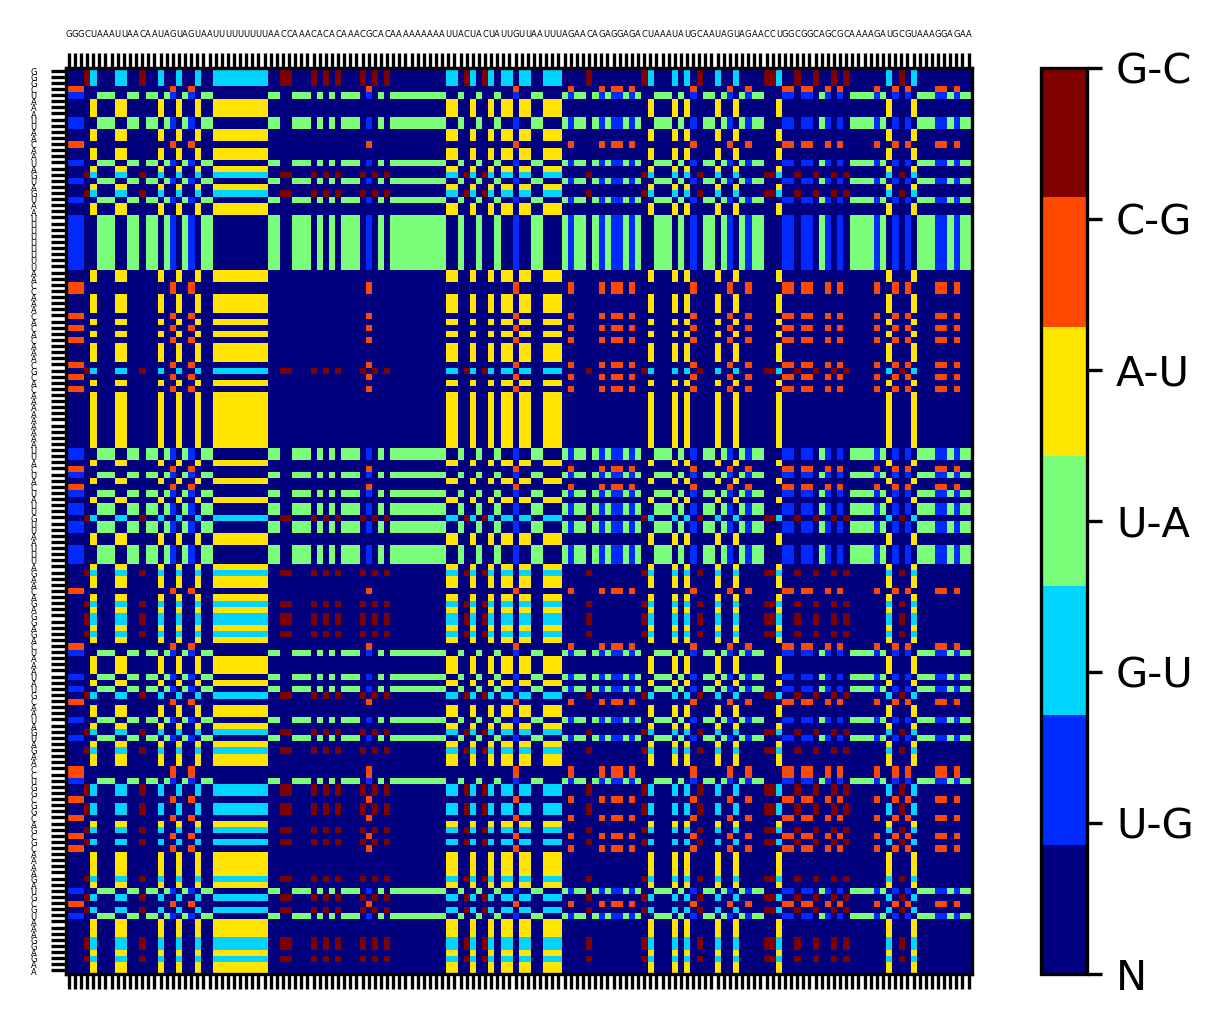


Input Size: (148, 148, 7)

EXAMPLE OF OUTPUT VECTOR
 [1.1025242e-01 1.0000000e-07 2.4537517e-01]

Distribution of ON Values
Distribution of OFF Values
Distribution of ON_OFF Values

ON Mean_absolute_error (TRANSFORMATION): 0.0380724 (SD: 0.019770144)

TRANSFORMED Values vs. ORIGINAL values (ON)
Pearson Correlation: 0.9965647
Spearman Correlation: 0.9999999999997533
R2: 0.9931412


OFF Mean_absolute_error (TRANSFORMATION): 0.30442002 (SD: 0.1460671)

TRANSFORMED Values vs. ORIGINAL values (OFF)
Pearson Correlation: 0.87894905
Spearman Correlation: 0.9999999999997964
R2: 0.7725514


ON_OFF Mean_absolute_error (TRANSFORMATION): 0.21606576 (SD: 0.064571)

TRANSFORMED Values vs. ORIGINAL values (ON_OFF)
Pearson Correlation: 0.9749051
Spearman Correlation: 0.9999999999994642
R2: 0.95043993


Training Basic Model...
[INFO] training with 4 GPUs...
Train on 61785 samples, validate on 6865 samples


Epoch 1/300


61785/61785 [==============================] - 154s 2ms/step - loss: 0.2285 - mean_squared_error: 0.0887 - mean_absolute_error: 0.2285 - mean_absolute_percentage_error: 15238104.8653 - cosine_proximity: -0.9078 - acc: 0.4075 - val_loss: 0.2115 - val_mean_squared_error: 0.0660 - val_mean_absolute_error: 0.2115 - val_mean_absolute_percentage_error: 10761010.9862 - val_cosine_proximity: -0.9238 - val_acc: 0.4998

Epoch 00001: val_loss improved from inf to 0.21151, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_2d_148/CNN_2D_148-ON-OFF-ON_OFF-QC1-1/base/model_checkpoint_weights.h5
Epoch 2/300


61785/61785 [==============================] - 131s 2ms/step - loss: 0.1907 - mean_squared_error: 0.0576 - mean_absolute_error: 0.1907 - mean_absolute_percentage_error: 13230150.3841 - cosine_proximity: -0.9222 - acc: 0.4545 - val_loss: 0.2499 - val_mean_squared_error: 0.0898 - val_mean_absolute_error: 0.2499 - val_mean_absolute_percentage_error: 9922787.1173 - val_cosine_proximity: -0.9164 - val_acc: 0.4218

Epoch 00002: val_loss did not improve from 0.21151
Epoch 3/300


61785/61785 [==============================] - 132s 2ms/step - loss: 0.1805 - mean_squared_error: 0.0533 - mean_absolute_error: 0.1805 - mean_absolute_percentage_error: 12681628.8640 - cosine_proximity: -0.9242 - acc: 0.4783 - val_loss: 0.1758 - val_mean_squared_error: 0.0542 - val_mean_absolute_error: 0.1758 - val_mean_absolute_percentage_error: 10102493.4530 - val_cosine_proximity: -0.9213 - val_acc: 0.5092

Epoch 00003: val_loss improved from 0.21151 to 0.17580, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_2d_148/CNN_2D_148-ON-OFF-ON_OFF-QC1-1/base/model_checkpoint_weights.h5
Epoch 4/300


61785/61785 [==============================] - 132s 2ms/step - loss: 0.1771 - mean_squared_error: 0.0520 - mean_absolute_error: 0.1771 - mean_absolute_percentage_error: 12492033.0499 - cosine_proximity: -0.9248 - acc: 0.5035 - val_loss: 0.6092 - val_mean_squared_error: 13.5188 - val_mean_absolute_error: 0.6092 - val_mean_absolute_percentage_error: 22021522.6956 - val_cosine_proximity: -0.8634 - val_acc: 0.5052

Epoch 00004: val_loss did not improve from 0.17580
Epoch 5/300


61785/61785 [==============================] - 132s 2ms/step - loss: 0.1766 - mean_squared_error: 0.0518 - mean_absolute_error: 0.1766 - mean_absolute_percentage_error: 12496150.5827 - cosine_proximity: -0.9255 - acc: 0.5022 - val_loss: 0.1696 - val_mean_squared_error: 0.0497 - val_mean_absolute_error: 0.1696 - val_mean_absolute_percentage_error: 10954659.4894 - val_cosine_proximity: -0.9240 - val_acc: 0.5269

Epoch 00005: val_loss improved from 0.17580 to 0.16963, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_2d_148/CNN_2D_148-ON-OFF-ON_OFF-QC1-1/base/model_checkpoint_weights.h5
Epoch 6/300


61785/61785 [==============================] - 132s 2ms/step - loss: 0.1749 - mean_squared_error: 0.0510 - mean_absolute_error: 0.1749 - mean_absolute_percentage_error: 12435961.7431 - cosine_proximity: -0.9257 - acc: 0.5123 - val_loss: 0.1612 - val_mean_squared_error: 0.0433 - val_mean_absolute_error: 0.1612 - val_mean_absolute_percentage_error: 11080367.3052 - val_cosine_proximity: -0.9314 - val_acc: 0.5661

Epoch 00006: val_loss improved from 0.16963 to 0.16117, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_2d_148/CNN_2D_148-ON-OFF-ON_OFF-QC1-1/base/model_checkpoint_weights.h5
Epoch 7/300


61785/61785 [==============================] - 132s 2ms/step - loss: 0.1737 - mean_squared_error: 0.0505 - mean_absolute_error: 0.1737 - mean_absolute_percentage_error: 12326006.8479 - cosine_proximity: -0.9263 - acc: 0.5226 - val_loss: 0.1968 - val_mean_squared_error: 0.3100 - val_mean_absolute_error: 0.1968 - val_mean_absolute_percentage_error: 9192509.5266 - val_cosine_proximity: -0.9234 - val_acc: 0.5042

Epoch 00007: val_loss did not improve from 0.16117
Epoch 8/300


61785/61785 [==============================] - 132s 2ms/step - loss: 0.1727 - mean_squared_error: 0.0501 - mean_absolute_error: 0.1727 - mean_absolute_percentage_error: 12386121.9052 - cosine_proximity: -0.9263 - acc: 0.5234 - val_loss: 0.1671 - val_mean_squared_error: 0.0461 - val_mean_absolute_error: 0.1671 - val_mean_absolute_percentage_error: 11186959.9468 - val_cosine_proximity: -0.9286 - val_acc: 0.5428

Epoch 00008: val_loss did not improve from 0.16117
Epoch 9/300


61785/61785 [==============================] - 132s 2ms/step - loss: 0.1718 - mean_squared_error: 0.0499 - mean_absolute_error: 0.1718 - mean_absolute_percentage_error: 12283128.8329 - cosine_proximity: -0.9262 - acc: 0.5244 - val_loss: 0.1590 - val_mean_squared_error: 0.0440 - val_mean_absolute_error: 0.1590 - val_mean_absolute_percentage_error: 10854459.3613 - val_cosine_proximity: -0.9315 - val_acc: 0.5688

Epoch 00009: val_loss improved from 0.16117 to 0.15900, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_2d_148/CNN_2D_148-ON-OFF-ON_OFF-QC1-1/base/model_checkpoint_weights.h5
Epoch 10/300


61785/61785 [==============================] - 132s 2ms/step - loss: 0.1724 - mean_squared_error: 0.0500 - mean_absolute_error: 0.1724 - mean_absolute_percentage_error: 12339875.7133 - cosine_proximity: -0.9259 - acc: 0.5252 - val_loss: 0.1640 - val_mean_squared_error: 0.0477 - val_mean_absolute_error: 0.1640 - val_mean_absolute_percentage_error: 10357119.1224 - val_cosine_proximity: -0.9259 - val_acc: 0.5199

Epoch 00010: val_loss did not improve from 0.15900
Epoch 11/300


61785/61785 [==============================] - 132s 2ms/step - loss: 0.1705 - mean_squared_error: 0.0493 - mean_absolute_error: 0.1705 - mean_absolute_percentage_error: 12402034.8429 - cosine_proximity: -0.9267 - acc: 0.5317 - val_loss: 0.2044 - val_mean_squared_error: 0.7982 - val_mean_absolute_error: 0.2044 - val_mean_absolute_percentage_error: 12962549.3926 - val_cosine_proximity: -0.9175 - val_acc: 0.5205

Epoch 00011: val_loss did not improve from 0.15900
Epoch 12/300


61785/61785 [==============================] - 133s 2ms/step - loss: 0.1695 - mean_squared_error: 0.0488 - mean_absolute_error: 0.1695 - mean_absolute_percentage_error: 12156271.6682 - cosine_proximity: -0.9271 - acc: 0.5305 - val_loss: 0.1653 - val_mean_squared_error: 0.1174 - val_mean_absolute_error: 0.1653 - val_mean_absolute_percentage_error: 10194500.0532 - val_cosine_proximity: -0.9271 - val_acc: 0.5422

Epoch 00012: val_loss did not improve from 0.15900
Epoch 13/300


61785/61785 [==============================] - 133s 2ms/step - loss: 0.1685 - mean_squared_error: 0.0483 - mean_absolute_error: 0.1685 - mean_absolute_percentage_error: 12172053.2806 - cosine_proximity: -0.9272 - acc: 0.5335 - val_loss: 0.1967 - val_mean_squared_error: 0.0690 - val_mean_absolute_error: 0.1967 - val_mean_absolute_percentage_error: 8732396.0051 - val_cosine_proximity: -0.9268 - val_acc: 0.5272

Epoch 00013: val_loss did not improve from 0.15900
Epoch 14/300


61785/61785 [==============================] - 133s 2ms/step - loss: 0.1691 - mean_squared_error: 0.0487 - mean_absolute_error: 0.1691 - mean_absolute_percentage_error: 12108173.5199 - cosine_proximity: -0.9271 - acc: 0.5283 - val_loss: 0.1654 - val_mean_squared_error: 0.0465 - val_mean_absolute_error: 0.1654 - val_mean_absolute_percentage_error: 12809548.0175 - val_cosine_proximity: -0.9304 - val_acc: 0.5451

Epoch 00014: val_loss did not improve from 0.15900
Epoch 15/300


61785/61785 [==============================] - 133s 2ms/step - loss: 0.1691 - mean_squared_error: 0.0489 - mean_absolute_error: 0.1691 - mean_absolute_percentage_error: 12370478.7911 - cosine_proximity: -0.9268 - acc: 0.5317 - val_loss: 0.1775 - val_mean_squared_error: 0.0532 - val_mean_absolute_error: 0.1775 - val_mean_absolute_percentage_error: 10679991.9301 - val_cosine_proximity: -0.9192 - val_acc: 0.4874

Epoch 00015: val_loss did not improve from 0.15900
Epoch 16/300


61785/61785 [==============================] - 132s 2ms/step - loss: 0.1671 - mean_squared_error: 0.0478 - mean_absolute_error: 0.1671 - mean_absolute_percentage_error: 12208804.9104 - cosine_proximity: -0.9276 - acc: 0.5367 - val_loss: 0.1650 - val_mean_squared_error: 0.0441 - val_mean_absolute_error: 0.1650 - val_mean_absolute_percentage_error: 9970859.9425 - val_cosine_proximity: -0.9304 - val_acc: 0.5595

Epoch 00016: val_loss did not improve from 0.15900
Epoch 17/300


61785/61785 [==============================] - 132s 2ms/step - loss: 0.1657 - mean_squared_error: 0.0472 - mean_absolute_error: 0.1657 - mean_absolute_percentage_error: 12172483.5708 - cosine_proximity: -0.9282 - acc: 0.5413 - val_loss: 0.1587 - val_mean_squared_error: 0.1917 - val_mean_absolute_error: 0.1587 - val_mean_absolute_percentage_error: 11068521.8427 - val_cosine_proximity: -0.9334 - val_acc: 0.5640

Epoch 00017: val_loss improved from 0.15900 to 0.15865, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_2d_148/CNN_2D_148-ON-OFF-ON_OFF-QC1-1/base/model_checkpoint_weights.h5
Epoch 18/300


61785/61785 [==============================] - 133s 2ms/step - loss: 0.1655 - mean_squared_error: 0.0472 - mean_absolute_error: 0.1655 - mean_absolute_percentage_error: 12082767.4675 - cosine_proximity: -0.9282 - acc: 0.5461 - val_loss: 0.2345 - val_mean_squared_error: 38.4693 - val_mean_absolute_error: 0.2345 - val_mean_absolute_percentage_error: 11825947.1733 - val_cosine_proximity: -0.9317 - val_acc: 0.5771

Epoch 00018: val_loss did not improve from 0.15865
Epoch 19/300


61785/61785 [==============================] - 133s 2ms/step - loss: 0.1644 - mean_squared_error: 0.0467 - mean_absolute_error: 0.1644 - mean_absolute_percentage_error: 12040420.2983 - cosine_proximity: -0.9286 - acc: 0.5464 - val_loss: 0.2345 - val_mean_squared_error: 42.5679 - val_mean_absolute_error: 0.2345 - val_mean_absolute_percentage_error: 8640555.6540 - val_cosine_proximity: -0.9258 - val_acc: 0.5266

Epoch 00019: val_loss did not improve from 0.15865
Epoch 20/300


61785/61785 [==============================] - 133s 2ms/step - loss: 0.1633 - mean_squared_error: 0.0461 - mean_absolute_error: 0.1633 - mean_absolute_percentage_error: 12029109.6778 - cosine_proximity: -0.9288 - acc: 0.5512 - val_loss: 0.8700 - val_mean_squared_error: 4582.5696 - val_mean_absolute_error: 0.8700 - val_mean_absolute_percentage_error: 10111972.8857 - val_cosine_proximity: -0.9256 - val_acc: 0.5323

Epoch 00020: val_loss did not improve from 0.15865
Epoch 21/300


61785/61785 [==============================] - 133s 2ms/step - loss: 0.1620 - mean_squared_error: 0.0456 - mean_absolute_error: 0.1620 - mean_absolute_percentage_error: 11974319.4315 - cosine_proximity: -0.9294 - acc: 0.5587 - val_loss: 0.9069 - val_mean_squared_error: 4458.2018 - val_mean_absolute_error: 0.9069 - val_mean_absolute_percentage_error: 10637730.0655 - val_cosine_proximity: -0.9302 - val_acc: 0.5554

Epoch 00021: val_loss did not improve from 0.15865
Epoch 22/300


61785/61785 [==============================] - 133s 2ms/step - loss: 0.1617 - mean_squared_error: 0.0454 - mean_absolute_error: 0.1617 - mean_absolute_percentage_error: 12099679.3825 - cosine_proximity: -0.9297 - acc: 0.5582 - val_loss: 0.1700 - val_mean_squared_error: 0.0466 - val_mean_absolute_error: 0.1700 - val_mean_absolute_percentage_error: 9036748.0379 - val_cosine_proximity: -0.9285 - val_acc: 0.5554

Epoch 00022: val_loss did not improve from 0.15865
Epoch 23/300


61785/61785 [==============================] - 133s 2ms/step - loss: 0.1604 - mean_squared_error: 0.0449 - mean_absolute_error: 0.1604 - mean_absolute_percentage_error: 12004135.7234 - cosine_proximity: -0.9303 - acc: 0.5633 - val_loss: 0.1680 - val_mean_squared_error: 0.0456 - val_mean_absolute_error: 0.1680 - val_mean_absolute_percentage_error: 10696931.7516 - val_cosine_proximity: -0.9284 - val_acc: 0.5595

Epoch 00023: val_loss did not improve from 0.15865
Epoch 24/300


61785/61785 [==============================] - 133s 2ms/step - loss: 0.1610 - mean_squared_error: 0.0452 - mean_absolute_error: 0.1610 - mean_absolute_percentage_error: 11978104.5827 - cosine_proximity: -0.9298 - acc: 0.5632 - val_loss: 0.3273 - val_mean_squared_error: 163.8889 - val_mean_absolute_error: 0.3273 - val_mean_absolute_percentage_error: 9112502.6402 - val_cosine_proximity: -0.9148 - val_acc: 0.4999

Epoch 00024: val_loss did not improve from 0.15865
Epoch 25/300


61785/61785 [==============================] - 133s 2ms/step - loss: 0.1596 - mean_squared_error: 0.0445 - mean_absolute_error: 0.1596 - mean_absolute_percentage_error: 11842264.1394 - cosine_proximity: -0.9304 - acc: 0.5683 - val_loss: 0.1599 - val_mean_squared_error: 0.0438 - val_mean_absolute_error: 0.1599 - val_mean_absolute_percentage_error: 11507167.1049 - val_cosine_proximity: -0.9319 - val_acc: 0.5410

Epoch 00025: val_loss did not improve from 0.15865
Epoch 26/300


61785/61785 [==============================] - 133s 2ms/step - loss: 0.1580 - mean_squared_error: 0.0438 - mean_absolute_error: 0.1580 - mean_absolute_percentage_error: 11952987.0132 - cosine_proximity: -0.9310 - acc: 0.5708 - val_loss: 0.2931 - val_mean_squared_error: 145.3971 - val_mean_absolute_error: 0.2931 - val_mean_absolute_percentage_error: 9872008.4385 - val_cosine_proximity: -0.9298 - val_acc: 0.5544

Epoch 00026: val_loss did not improve from 0.15865
Epoch 27/300


61785/61785 [==============================] - 133s 2ms/step - loss: 0.1568 - mean_squared_error: 0.0432 - mean_absolute_error: 0.1568 - mean_absolute_percentage_error: 11902927.6840 - cosine_proximity: -0.9313 - acc: 0.5729 - val_loss: 0.1619 - val_mean_squared_error: 0.0448 - val_mean_absolute_error: 0.1619 - val_mean_absolute_percentage_error: 10939586.5965 - val_cosine_proximity: -0.9302 - val_acc: 0.5446

Epoch 00027: val_loss did not improve from 0.15865
Epoch 28/300


61785/61785 [==============================] - 133s 2ms/step - loss: 0.1560 - mean_squared_error: 0.0429 - mean_absolute_error: 0.1560 - mean_absolute_percentage_error: 11761958.2157 - cosine_proximity: -0.9319 - acc: 0.5768 - val_loss: 0.1640 - val_mean_squared_error: 0.0469 - val_mean_absolute_error: 0.1640 - val_mean_absolute_percentage_error: 11126067.3205 - val_cosine_proximity: -0.9299 - val_acc: 0.5323

Epoch 00028: val_loss did not improve from 0.15865
Epoch 29/300


61785/61785 [==============================] - 133s 2ms/step - loss: 0.1543 - mean_squared_error: 0.0422 - mean_absolute_error: 0.1543 - mean_absolute_percentage_error: 11825714.0500 - cosine_proximity: -0.9323 - acc: 0.5806 - val_loss: 0.1634 - val_mean_squared_error: 0.0444 - val_mean_absolute_error: 0.1634 - val_mean_absolute_percentage_error: 11349666.4698 - val_cosine_proximity: -0.9312 - val_acc: 0.5334

Epoch 00029: val_loss did not improve from 0.15865
Epoch 30/300


61785/61785 [==============================] - 133s 2ms/step - loss: 0.1539 - mean_squared_error: 0.0420 - mean_absolute_error: 0.1539 - mean_absolute_percentage_error: 11685959.2149 - cosine_proximity: -0.9330 - acc: 0.5834 - val_loss: 0.1616 - val_mean_squared_error: 0.0457 - val_mean_absolute_error: 0.1616 - val_mean_absolute_percentage_error: 10663727.5448 - val_cosine_proximity: -0.9300 - val_acc: 0.5513

Epoch 00030: val_loss did not improve from 0.15865
Epoch 31/300


61785/61785 [==============================] - 132s 2ms/step - loss: 0.1546 - mean_squared_error: 0.0423 - mean_absolute_error: 0.1546 - mean_absolute_percentage_error: 11897033.5815 - cosine_proximity: -0.9325 - acc: 0.5821 - val_loss: 0.1604 - val_mean_squared_error: 0.0424 - val_mean_absolute_error: 0.1604 - val_mean_absolute_percentage_error: 11110345.5091 - val_cosine_proximity: -0.9318 - val_acc: 0.5527

Epoch 00031: val_loss did not improve from 0.15865
Epoch 32/300


61785/61785 [==============================] - 133s 2ms/step - loss: 0.1531 - mean_squared_error: 0.0416 - mean_absolute_error: 0.1531 - mean_absolute_percentage_error: 11766101.8411 - cosine_proximity: -0.9334 - acc: 0.5869 - val_loss: 0.1724 - val_mean_squared_error: 0.0505 - val_mean_absolute_error: 0.1724 - val_mean_absolute_percentage_error: 12874399.5732 - val_cosine_proximity: -0.9309 - val_acc: 0.5311

Epoch 00032: val_loss did not improve from 0.15865
Epoch 33/300


61785/61785 [==============================] - 133s 2ms/step - loss: 0.1526 - mean_squared_error: 0.0412 - mean_absolute_error: 0.1526 - mean_absolute_percentage_error: 11701425.3251 - cosine_proximity: -0.9335 - acc: 0.5898 - val_loss: 0.1614 - val_mean_squared_error: 0.0452 - val_mean_absolute_error: 0.1614 - val_mean_absolute_percentage_error: 9719141.1631 - val_cosine_proximity: -0.9283 - val_acc: 0.5444

Epoch 00033: val_loss did not improve from 0.15865
Epoch 34/300


61785/61785 [==============================] - 133s 2ms/step - loss: 0.1516 - mean_squared_error: 0.0408 - mean_absolute_error: 0.1516 - mean_absolute_percentage_error: 11656136.3526 - cosine_proximity: -0.9344 - acc: 0.5898 - val_loss: 0.1763 - val_mean_squared_error: 0.0532 - val_mean_absolute_error: 0.1763 - val_mean_absolute_percentage_error: 13972056.0452 - val_cosine_proximity: -0.9314 - val_acc: 0.5267

Epoch 00034: val_loss did not improve from 0.15865
Epoch 35/300


61785/61785 [==============================] - 133s 2ms/step - loss: 0.1507 - mean_squared_error: 0.0404 - mean_absolute_error: 0.1507 - mean_absolute_percentage_error: 11715881.4117 - cosine_proximity: -0.9345 - acc: 0.5955 - val_loss: 0.1686 - val_mean_squared_error: 0.0501 - val_mean_absolute_error: 0.1686 - val_mean_absolute_percentage_error: 9020722.0007 - val_cosine_proximity: -0.9227 - val_acc: 0.5183

Epoch 00035: val_loss did not improve from 0.15865
Epoch 36/300


61785/61785 [==============================] - 133s 2ms/step - loss: 0.1504 - mean_squared_error: 0.0406 - mean_absolute_error: 0.1504 - mean_absolute_percentage_error: 11699500.7690 - cosine_proximity: -0.9342 - acc: 0.5974 - val_loss: 0.1701 - val_mean_squared_error: 0.2452 - val_mean_absolute_error: 0.1701 - val_mean_absolute_percentage_error: 11674103.4676 - val_cosine_proximity: -0.9306 - val_acc: 0.5470

Epoch 00036: val_loss did not improve from 0.15865
Epoch 37/300


61785/61785 [==============================] - 134s 2ms/step - loss: 0.1486 - mean_squared_error: 0.0398 - mean_absolute_error: 0.1486 - mean_absolute_percentage_error: 11655434.4260 - cosine_proximity: -0.9356 - acc: 0.6022 - val_loss: 0.1663 - val_mean_squared_error: 0.0470 - val_mean_absolute_error: 0.1663 - val_mean_absolute_percentage_error: 9676819.2025 - val_cosine_proximity: -0.9259 - val_acc: 0.5442

Epoch 00037: val_loss did not improve from 0.15865
Epoch 00037: early stopping

Predicting functionality of Test Toeholds ...

ON Mean_absolute_error (TEST): 0.13376446 (SD: 0.11983977)

EXPERIMENTAL Values vs. PREDICTED values (ON)
Pearson Correlation: 0.82051545
Spearman Correlation: 0.8283821489735362
R2: 0.6732456

OFF Mean_absolute_error (TEST): 0.12213665 (SD: 0.15027559)

EXPERIMENTAL Values vs. PREDICTED values (OFF)
Pearson Correlation: 0.67039776
Spearman Correlation: 0.6587698747219584
R2: 0.44943315

ON_OFF Mean_absolute_error (TEST): 0.17331432 (SD: 0.15820968)

EXPER

Epoch 1/300


74141/74141 [==============================] - 161s 2ms/step - loss: 0.2225 - mean_squared_error: 0.0819 - mean_absolute_error: 0.2225 - mean_absolute_percentage_error: 14831771.3696 - cosine_proximity: -0.9108 - acc: 0.4199 - val_loss: 0.2119 - val_mean_squared_error: 0.0683 - val_mean_absolute_error: 0.2119 - val_mean_absolute_percentage_error: 12453117.1296 - val_cosine_proximity: -0.9231 - val_acc: 0.5153

Epoch 00001: val_loss improved from inf to 0.21189, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_2d_148/CNN_2D_148-ON-OFF-ON_OFF-QC1-1/crossval/Fold0/model_checkpoint_weights.h5
Epoch 2/300


74141/74141 [==============================] - 158s 2ms/step - loss: 0.1744 - mean_squared_error: 0.0501 - mean_absolute_error: 0.1744 - mean_absolute_percentage_error: 11813228.4866 - cosine_proximity: -0.9263 - acc: 0.5151 - val_loss: 0.1644 - val_mean_squared_error: 0.0472 - val_mean_absolute_error: 0.1644 - val_mean_absolute_percentage_error: 13575862.9670 - val_cosine_proximity: -0.9326 - val_acc: 0.5643

Epoch 00002: val_loss improved from 0.21189 to 0.16443, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_2d_148/CNN_2D_148-ON-OFF-ON_OFF-QC1-1/crossval/Fold0/model_checkpoint_weights.h5
Epoch 3/300


74141/74141 [==============================] - 158s 2ms/step - loss: 0.1645 - mean_squared_error: 0.0456 - mean_absolute_error: 0.1645 - mean_absolute_percentage_error: 11119608.5765 - cosine_proximity: -0.9295 - acc: 0.5465 - val_loss: 0.1641 - val_mean_squared_error: 0.0456 - val_mean_absolute_error: 0.1641 - val_mean_absolute_percentage_error: 12372728.1367 - val_cosine_proximity: -0.9295 - val_acc: 0.5533

Epoch 00003: val_loss improved from 0.16443 to 0.16408, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_2d_148/CNN_2D_148-ON-OFF-ON_OFF-QC1-1/crossval/Fold0/model_checkpoint_weights.h5
Epoch 4/300


74141/74141 [==============================] - 158s 2ms/step - loss: 0.1609 - mean_squared_error: 0.0441 - mean_absolute_error: 0.1609 - mean_absolute_percentage_error: 10997041.5588 - cosine_proximity: -0.9308 - acc: 0.5616 - val_loss: 0.1604 - val_mean_squared_error: 0.0453 - val_mean_absolute_error: 0.1604 - val_mean_absolute_percentage_error: 12523665.1386 - val_cosine_proximity: -0.9330 - val_acc: 0.5607

Epoch 00004: val_loss improved from 0.16408 to 0.16045, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_2d_148/CNN_2D_148-ON-OFF-ON_OFF-QC1-1/crossval/Fold0/model_checkpoint_weights.h5
Epoch 5/300


74141/74141 [==============================] - 158s 2ms/step - loss: 0.1591 - mean_squared_error: 0.0432 - mean_absolute_error: 0.1591 - mean_absolute_percentage_error: 10911116.6239 - cosine_proximity: -0.9316 - acc: 0.5701 - val_loss: 0.3737 - val_mean_squared_error: 13.6164 - val_mean_absolute_error: 0.3737 - val_mean_absolute_percentage_error: 23640259.9835 - val_cosine_proximity: -0.9171 - val_acc: 0.5347

Epoch 00005: val_loss did not improve from 0.16045
Epoch 6/300


74141/74141 [==============================] - 158s 2ms/step - loss: 0.1562 - mean_squared_error: 0.0420 - mean_absolute_error: 0.1562 - mean_absolute_percentage_error: 10877758.7637 - cosine_proximity: -0.9324 - acc: 0.5773 - val_loss: 0.1568 - val_mean_squared_error: 0.0430 - val_mean_absolute_error: 0.1568 - val_mean_absolute_percentage_error: 10562276.0855 - val_cosine_proximity: -0.9329 - val_acc: 0.5679

Epoch 00006: val_loss improved from 0.16045 to 0.15676, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_2d_148/CNN_2D_148-ON-OFF-ON_OFF-QC1-1/crossval/Fold0/model_checkpoint_weights.h5
Epoch 7/300


74141/74141 [==============================] - 157s 2ms/step - loss: 0.1548 - mean_squared_error: 0.0414 - mean_absolute_error: 0.1548 - mean_absolute_percentage_error: 10686418.2765 - cosine_proximity: -0.9329 - acc: 0.5772 - val_loss: 0.1553 - val_mean_squared_error: 0.0425 - val_mean_absolute_error: 0.1553 - val_mean_absolute_percentage_error: 14101953.1952 - val_cosine_proximity: -0.9352 - val_acc: 0.5840

Epoch 00007: val_loss improved from 0.15676 to 0.15529, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_2d_148/CNN_2D_148-ON-OFF-ON_OFF-QC1-1/crossval/Fold0/model_checkpoint_weights.h5
Epoch 8/300


74141/74141 [==============================] - 160s 2ms/step - loss: 0.1530 - mean_squared_error: 0.0405 - mean_absolute_error: 0.1530 - mean_absolute_percentage_error: 10679925.7773 - cosine_proximity: -0.9337 - acc: 0.5849 - val_loss: 0.1551 - val_mean_squared_error: 0.0405 - val_mean_absolute_error: 0.1551 - val_mean_absolute_percentage_error: 11885531.4907 - val_cosine_proximity: -0.9351 - val_acc: 0.5586

Epoch 00008: val_loss improved from 0.15529 to 0.15514, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_2d_148/CNN_2D_148-ON-OFF-ON_OFF-QC1-1/crossval/Fold0/model_checkpoint_weights.h5
Epoch 9/300


74141/74141 [==============================] - 159s 2ms/step - loss: 0.1514 - mean_squared_error: 0.0399 - mean_absolute_error: 0.1514 - mean_absolute_percentage_error: 10512082.8425 - cosine_proximity: -0.9343 - acc: 0.5928 - val_loss: 0.1769 - val_mean_squared_error: 0.0542 - val_mean_absolute_error: 0.1769 - val_mean_absolute_percentage_error: 16760507.6164 - val_cosine_proximity: -0.9214 - val_acc: 0.4800

Epoch 00009: val_loss did not improve from 0.15514
Epoch 10/300


74141/74141 [==============================] - 160s 2ms/step - loss: 0.1503 - mean_squared_error: 0.0394 - mean_absolute_error: 0.1503 - mean_absolute_percentage_error: 10499829.0512 - cosine_proximity: -0.9346 - acc: 0.5913 - val_loss: 0.1529 - val_mean_squared_error: 0.0408 - val_mean_absolute_error: 0.1529 - val_mean_absolute_percentage_error: 11018045.4054 - val_cosine_proximity: -0.9364 - val_acc: 0.5675

Epoch 00010: val_loss improved from 0.15514 to 0.15288, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_2d_148/CNN_2D_148-ON-OFF-ON_OFF-QC1-1/crossval/Fold0/model_checkpoint_weights.h5
Epoch 11/300


74141/74141 [==============================] - 159s 2ms/step - loss: 0.1489 - mean_squared_error: 0.0388 - mean_absolute_error: 0.1489 - mean_absolute_percentage_error: 10395624.8684 - cosine_proximity: -0.9358 - acc: 0.6009 - val_loss: 0.1572 - val_mean_squared_error: 0.0419 - val_mean_absolute_error: 0.1572 - val_mean_absolute_percentage_error: 11236003.1794 - val_cosine_proximity: -0.9343 - val_acc: 0.5700

Epoch 00011: val_loss did not improve from 0.15288
Epoch 12/300


74141/74141 [==============================] - 160s 2ms/step - loss: 0.1463 - mean_squared_error: 0.0377 - mean_absolute_error: 0.1463 - mean_absolute_percentage_error: 10168323.8765 - cosine_proximity: -0.9367 - acc: 0.6067 - val_loss: 0.1621 - val_mean_squared_error: 0.0439 - val_mean_absolute_error: 0.1621 - val_mean_absolute_percentage_error: 10880236.9947 - val_cosine_proximity: -0.9330 - val_acc: 0.5774

Epoch 00012: val_loss did not improve from 0.15288
Epoch 13/300


74141/74141 [==============================] - 161s 2ms/step - loss: 0.1452 - mean_squared_error: 0.0372 - mean_absolute_error: 0.1452 - mean_absolute_percentage_error: 10194086.7404 - cosine_proximity: -0.9372 - acc: 0.6090 - val_loss: 0.1599 - val_mean_squared_error: 0.0431 - val_mean_absolute_error: 0.1599 - val_mean_absolute_percentage_error: 10666230.3520 - val_cosine_proximity: -0.9324 - val_acc: 0.5706

Epoch 00013: val_loss did not improve from 0.15288
Epoch 14/300


74141/74141 [==============================] - 159s 2ms/step - loss: 0.1431 - mean_squared_error: 0.0363 - mean_absolute_error: 0.1431 - mean_absolute_percentage_error: 10093392.9518 - cosine_proximity: -0.9382 - acc: 0.6159 - val_loss: 0.1556 - val_mean_squared_error: 0.0444 - val_mean_absolute_error: 0.1556 - val_mean_absolute_percentage_error: 9780448.7385 - val_cosine_proximity: -0.9322 - val_acc: 0.5893

Epoch 00014: val_loss did not improve from 0.15288
Epoch 15/300


74141/74141 [==============================] - 161s 2ms/step - loss: 0.1423 - mean_squared_error: 0.0359 - mean_absolute_error: 0.1423 - mean_absolute_percentage_error: 9992132.3452 - cosine_proximity: -0.9391 - acc: 0.6222 - val_loss: 0.1587 - val_mean_squared_error: 0.0433 - val_mean_absolute_error: 0.1587 - val_mean_absolute_percentage_error: 10843473.0704 - val_cosine_proximity: -0.9309 - val_acc: 0.5736

Epoch 00015: val_loss did not improve from 0.15288
Epoch 16/300


74141/74141 [==============================] - 161s 2ms/step - loss: 0.1404 - mean_squared_error: 0.0351 - mean_absolute_error: 0.1404 - mean_absolute_percentage_error: 9952001.0456 - cosine_proximity: -0.9400 - acc: 0.6272 - val_loss: 0.1565 - val_mean_squared_error: 0.0447 - val_mean_absolute_error: 0.1565 - val_mean_absolute_percentage_error: 9704164.1532 - val_cosine_proximity: -0.9316 - val_acc: 0.5777

Epoch 00016: val_loss did not improve from 0.15288
Epoch 17/300


74141/74141 [==============================] - 160s 2ms/step - loss: 0.1382 - mean_squared_error: 0.0342 - mean_absolute_error: 0.1382 - mean_absolute_percentage_error: 9870800.1018 - cosine_proximity: -0.9408 - acc: 0.6311 - val_loss: 0.1608 - val_mean_squared_error: 0.0451 - val_mean_absolute_error: 0.1608 - val_mean_absolute_percentage_error: 12646376.0930 - val_cosine_proximity: -0.9301 - val_acc: 0.5793

Epoch 00017: val_loss did not improve from 0.15288
Epoch 18/300


74141/74141 [==============================] - 160s 2ms/step - loss: 0.1380 - mean_squared_error: 0.0338 - mean_absolute_error: 0.1380 - mean_absolute_percentage_error: 9858045.7762 - cosine_proximity: -0.9416 - acc: 0.6347 - val_loss: 0.1541 - val_mean_squared_error: 0.0414 - val_mean_absolute_error: 0.1541 - val_mean_absolute_percentage_error: 10281039.3506 - val_cosine_proximity: -0.9327 - val_acc: 0.5832

Epoch 00018: val_loss did not improve from 0.15288
Epoch 19/300


74141/74141 [==============================] - 160s 2ms/step - loss: 0.1348 - mean_squared_error: 0.0326 - mean_absolute_error: 0.1348 - mean_absolute_percentage_error: 9667447.5899 - cosine_proximity: -0.9427 - acc: 0.6433 - val_loss: 0.1558 - val_mean_squared_error: 0.0424 - val_mean_absolute_error: 0.1558 - val_mean_absolute_percentage_error: 11622680.8196 - val_cosine_proximity: -0.9346 - val_acc: 0.5863

Epoch 00019: val_loss did not improve from 0.15288
Epoch 20/300


74141/74141 [==============================] - 159s 2ms/step - loss: 0.1338 - mean_squared_error: 0.0321 - mean_absolute_error: 0.1338 - mean_absolute_percentage_error: 9696583.6297 - cosine_proximity: -0.9438 - acc: 0.6475 - val_loss: 0.1542 - val_mean_squared_error: 0.0416 - val_mean_absolute_error: 0.1542 - val_mean_absolute_percentage_error: 11245149.7412 - val_cosine_proximity: -0.9330 - val_acc: 0.5762

Epoch 00020: val_loss did not improve from 0.15288
Epoch 21/300


74141/74141 [==============================] - 160s 2ms/step - loss: 0.1317 - mean_squared_error: 0.0311 - mean_absolute_error: 0.1317 - mean_absolute_percentage_error: 9542880.7089 - cosine_proximity: -0.9447 - acc: 0.6527 - val_loss: 0.1569 - val_mean_squared_error: 0.0453 - val_mean_absolute_error: 0.1569 - val_mean_absolute_percentage_error: 10095766.7740 - val_cosine_proximity: -0.9321 - val_acc: 0.5788

Epoch 00021: val_loss did not improve from 0.15288
Epoch 22/300


74141/74141 [==============================] - 160s 2ms/step - loss: 0.1297 - mean_squared_error: 0.0303 - mean_absolute_error: 0.1297 - mean_absolute_percentage_error: 9401194.3421 - cosine_proximity: -0.9457 - acc: 0.6589 - val_loss: 0.1629 - val_mean_squared_error: 0.0453 - val_mean_absolute_error: 0.1629 - val_mean_absolute_percentage_error: 10021406.2906 - val_cosine_proximity: -0.9303 - val_acc: 0.5784

Epoch 00022: val_loss did not improve from 0.15288
Epoch 23/300


74141/74141 [==============================] - 160s 2ms/step - loss: 0.1272 - mean_squared_error: 0.0292 - mean_absolute_error: 0.1272 - mean_absolute_percentage_error: 9351353.0475 - cosine_proximity: -0.9468 - acc: 0.6660 - val_loss: 0.1603 - val_mean_squared_error: 0.0471 - val_mean_absolute_error: 0.1603 - val_mean_absolute_percentage_error: 10642145.1991 - val_cosine_proximity: -0.9314 - val_acc: 0.5886

Epoch 00023: val_loss did not improve from 0.15288
Epoch 24/300


74141/74141 [==============================] - 160s 2ms/step - loss: 0.1258 - mean_squared_error: 0.0285 - mean_absolute_error: 0.1258 - mean_absolute_percentage_error: 9224229.4574 - cosine_proximity: -0.9482 - acc: 0.6729 - val_loss: 0.1539 - val_mean_squared_error: 0.0430 - val_mean_absolute_error: 0.1539 - val_mean_absolute_percentage_error: 12524665.1580 - val_cosine_proximity: -0.9335 - val_acc: 0.5838

Epoch 00024: val_loss did not improve from 0.15288
Epoch 25/300


74141/74141 [==============================] - 160s 2ms/step - loss: 0.1238 - mean_squared_error: 0.0277 - mean_absolute_error: 0.1238 - mean_absolute_percentage_error: 9184610.5731 - cosine_proximity: -0.9489 - acc: 0.6763 - val_loss: 0.1561 - val_mean_squared_error: 0.0425 - val_mean_absolute_error: 0.1561 - val_mean_absolute_percentage_error: 9352517.3608 - val_cosine_proximity: -0.9325 - val_acc: 0.5940

Epoch 00025: val_loss did not improve from 0.15288
Epoch 26/300


74141/74141 [==============================] - 160s 2ms/step - loss: 0.1215 - mean_squared_error: 0.0268 - mean_absolute_error: 0.1215 - mean_absolute_percentage_error: 9103259.0193 - cosine_proximity: -0.9498 - acc: 0.6819 - val_loss: 0.1594 - val_mean_squared_error: 0.0436 - val_mean_absolute_error: 0.1594 - val_mean_absolute_percentage_error: 10341025.1357 - val_cosine_proximity: -0.9296 - val_acc: 0.5802

Epoch 00026: val_loss did not improve from 0.15288
Epoch 27/300


74141/74141 [==============================] - 160s 2ms/step - loss: 0.1202 - mean_squared_error: 0.0261 - mean_absolute_error: 0.1202 - mean_absolute_percentage_error: 9066009.4729 - cosine_proximity: -0.9511 - acc: 0.6879 - val_loss: 0.1584 - val_mean_squared_error: 0.0450 - val_mean_absolute_error: 0.1584 - val_mean_absolute_percentage_error: 11916798.9757 - val_cosine_proximity: -0.9298 - val_acc: 0.5770

Epoch 00027: val_loss did not improve from 0.15288
Epoch 28/300


74141/74141 [==============================] - 160s 2ms/step - loss: 0.1186 - mean_squared_error: 0.0253 - mean_absolute_error: 0.1186 - mean_absolute_percentage_error: 8927557.6709 - cosine_proximity: -0.9519 - acc: 0.6905 - val_loss: 0.1629 - val_mean_squared_error: 0.0477 - val_mean_absolute_error: 0.1629 - val_mean_absolute_percentage_error: 12225519.1678 - val_cosine_proximity: -0.9251 - val_acc: 0.5429

Epoch 00028: val_loss did not improve from 0.15288
Epoch 29/300


74141/74141 [==============================] - 159s 2ms/step - loss: 0.1167 - mean_squared_error: 0.0246 - mean_absolute_error: 0.1167 - mean_absolute_percentage_error: 8835954.9088 - cosine_proximity: -0.9530 - acc: 0.6970 - val_loss: 0.1572 - val_mean_squared_error: 0.0440 - val_mean_absolute_error: 0.1572 - val_mean_absolute_percentage_error: 9948072.3037 - val_cosine_proximity: -0.9304 - val_acc: 0.5756

Epoch 00029: val_loss did not improve from 0.15288
Epoch 30/300


74141/74141 [==============================] - 161s 2ms/step - loss: 0.1151 - mean_squared_error: 0.0239 - mean_absolute_error: 0.1151 - mean_absolute_percentage_error: 8726060.4959 - cosine_proximity: -0.9536 - acc: 0.6991 - val_loss: 0.1561 - val_mean_squared_error: 0.0439 - val_mean_absolute_error: 0.1561 - val_mean_absolute_percentage_error: 10315212.0507 - val_cosine_proximity: -0.9301 - val_acc: 0.5795

Epoch 00030: val_loss did not improve from 0.15288
Epoch 00030: early stopping

Predicting functionality of Test Toeholds ...

ON Mean_absolute_error (TEST): 0.12889285 (SD: 0.12561688)

EXPERIMENTAL Values vs. PREDICTED values (ON)
Pearson Correlation: 0.8319845
Spearman Correlation: 0.835203068658356
R2: 0.6921982

OFF Mean_absolute_error (TEST): 0.108595274 (SD: 0.12852934)

EXPERIMENTAL Values vs. PREDICTED values (OFF)
Pearson Correlation: 0.695338
Spearman Correlation: 0.6663256957852434
R2: 0.48349494

ON_OFF Mean_absolute_error (TEST): 0.16952485 (SD: 0.1607441)

EXPERIMEN

Epoch 1/300


74142/74142 [==============================] - 161s 2ms/step - loss: 0.2113 - mean_squared_error: 0.0731 - mean_absolute_error: 0.2113 - mean_absolute_percentage_error: 14003833.9571 - cosine_proximity: -0.9140 - acc: 0.4569 - val_loss: 0.2185 - val_mean_squared_error: 0.3421 - val_mean_absolute_error: 0.2185 - val_mean_absolute_percentage_error: 9916657.6890 - val_cosine_proximity: -0.9289 - val_acc: 0.5625

Epoch 00001: val_loss improved from inf to 0.21849, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_2d_148/CNN_2D_148-ON-OFF-ON_OFF-QC1-1/crossval/Fold1/model_checkpoint_weights.h5
Epoch 2/300


74142/74142 [==============================] - 158s 2ms/step - loss: 0.1727 - mean_squared_error: 0.0493 - mean_absolute_error: 0.1727 - mean_absolute_percentage_error: 11653863.2734 - cosine_proximity: -0.9275 - acc: 0.5214 - val_loss: 1.7155 - val_mean_squared_error: 25264.8672 - val_mean_absolute_error: 1.7155 - val_mean_absolute_percentage_error: 9738700.0325 - val_cosine_proximity: -0.9264 - val_acc: 0.5373

Epoch 00002: val_loss did not improve from 0.21849
Epoch 3/300


74142/74142 [==============================] - 157s 2ms/step - loss: 0.1679 - mean_squared_error: 0.0472 - mean_absolute_error: 0.1679 - mean_absolute_percentage_error: 11398408.6379 - cosine_proximity: -0.9284 - acc: 0.5321 - val_loss: 0.2528 - val_mean_squared_error: 33.1572 - val_mean_absolute_error: 0.2528 - val_mean_absolute_percentage_error: 18890744.6446 - val_cosine_proximity: -0.9299 - val_acc: 0.5572

Epoch 00003: val_loss did not improve from 0.21849
Epoch 4/300


74142/74142 [==============================] - 158s 2ms/step - loss: 0.1660 - mean_squared_error: 0.0464 - mean_absolute_error: 0.1660 - mean_absolute_percentage_error: 11329642.4310 - cosine_proximity: -0.9287 - acc: 0.5339 - val_loss: 0.1582 - val_mean_squared_error: 0.0430 - val_mean_absolute_error: 0.1582 - val_mean_absolute_percentage_error: 10461147.8344 - val_cosine_proximity: -0.9344 - val_acc: 0.5953

Epoch 00004: val_loss improved from 0.21849 to 0.15820, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_2d_148/CNN_2D_148-ON-OFF-ON_OFF-QC1-1/crossval/Fold1/model_checkpoint_weights.h5
Epoch 5/300


74142/74142 [==============================] - 158s 2ms/step - loss: 0.1640 - mean_squared_error: 0.0456 - mean_absolute_error: 0.1640 - mean_absolute_percentage_error: 11269366.1257 - cosine_proximity: -0.9294 - acc: 0.5385 - val_loss: 2.1650 - val_mean_squared_error: 36457.1568 - val_mean_absolute_error: 2.1650 - val_mean_absolute_percentage_error: 21069861.0910 - val_cosine_proximity: -0.9300 - val_acc: 0.5235

Epoch 00005: val_loss did not improve from 0.15820
Epoch 6/300


74142/74142 [==============================] - 158s 2ms/step - loss: 0.1626 - mean_squared_error: 0.0450 - mean_absolute_error: 0.1626 - mean_absolute_percentage_error: 11220502.3136 - cosine_proximity: -0.9300 - acc: 0.5457 - val_loss: 6.7679 - val_mean_squared_error: 434546.7317 - val_mean_absolute_error: 6.7679 - val_mean_absolute_percentage_error: 9809935.9905 - val_cosine_proximity: -0.9325 - val_acc: 0.5777

Epoch 00006: val_loss did not improve from 0.15820
Epoch 7/300


74142/74142 [==============================] - 159s 2ms/step - loss: 0.1614 - mean_squared_error: 0.0445 - mean_absolute_error: 0.1614 - mean_absolute_percentage_error: 11156474.0796 - cosine_proximity: -0.9302 - acc: 0.5497 - val_loss: 5.8146 - val_mean_squared_error: 308127.5607 - val_mean_absolute_error: 5.8146 - val_mean_absolute_percentage_error: 10957669.1122 - val_cosine_proximity: -0.9335 - val_acc: 0.5812

Epoch 00007: val_loss did not improve from 0.15820
Epoch 8/300


74142/74142 [==============================] - 158s 2ms/step - loss: 0.1606 - mean_squared_error: 0.0441 - mean_absolute_error: 0.1606 - mean_absolute_percentage_error: 11224287.3859 - cosine_proximity: -0.9304 - acc: 0.5462 - val_loss: 1.5429 - val_mean_squared_error: 19803.6186 - val_mean_absolute_error: 1.5429 - val_mean_absolute_percentage_error: 8788934.0952 - val_cosine_proximity: -0.9230 - val_acc: 0.5181

Epoch 00008: val_loss did not improve from 0.15820
Epoch 9/300


74142/74142 [==============================] - 158s 2ms/step - loss: 0.1603 - mean_squared_error: 0.0440 - mean_absolute_error: 0.1603 - mean_absolute_percentage_error: 11107693.3868 - cosine_proximity: -0.9307 - acc: 0.5527 - val_loss: 0.1899 - val_mean_squared_error: 0.0584 - val_mean_absolute_error: 0.1899 - val_mean_absolute_percentage_error: 9074863.8344 - val_cosine_proximity: -0.9259 - val_acc: 0.5320

Epoch 00009: val_loss did not improve from 0.15820
Epoch 10/300


74142/74142 [==============================] - 158s 2ms/step - loss: 0.1585 - mean_squared_error: 0.0433 - mean_absolute_error: 0.1585 - mean_absolute_percentage_error: 11038651.7200 - cosine_proximity: -0.9310 - acc: 0.5567 - val_loss: 0.1771 - val_mean_squared_error: 0.8476 - val_mean_absolute_error: 0.1771 - val_mean_absolute_percentage_error: 10077950.9009 - val_cosine_proximity: -0.9301 - val_acc: 0.5527

Epoch 00010: val_loss did not improve from 0.15820
Epoch 11/300


74142/74142 [==============================] - 159s 2ms/step - loss: 0.1578 - mean_squared_error: 0.0430 - mean_absolute_error: 0.1578 - mean_absolute_percentage_error: 11117051.4808 - cosine_proximity: -0.9316 - acc: 0.5652 - val_loss: 0.1725 - val_mean_squared_error: 0.0475 - val_mean_absolute_error: 0.1725 - val_mean_absolute_percentage_error: 10124537.8497 - val_cosine_proximity: -0.9361 - val_acc: 0.6094

Epoch 00011: val_loss did not improve from 0.15820
Epoch 12/300


74142/74142 [==============================] - 160s 2ms/step - loss: 0.1560 - mean_squared_error: 0.0422 - mean_absolute_error: 0.1560 - mean_absolute_percentage_error: 10958794.8089 - cosine_proximity: -0.9319 - acc: 0.5627 - val_loss: 0.1574 - val_mean_squared_error: 0.0418 - val_mean_absolute_error: 0.1574 - val_mean_absolute_percentage_error: 11190046.3394 - val_cosine_proximity: -0.9347 - val_acc: 0.5897

Epoch 00012: val_loss improved from 0.15820 to 0.15740, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_2d_148/CNN_2D_148-ON-OFF-ON_OFF-QC1-1/crossval/Fold1/model_checkpoint_weights.h5
Epoch 13/300


74142/74142 [==============================] - 160s 2ms/step - loss: 0.1555 - mean_squared_error: 0.0418 - mean_absolute_error: 0.1555 - mean_absolute_percentage_error: 10954663.7895 - cosine_proximity: -0.9325 - acc: 0.5682 - val_loss: 0.1521 - val_mean_squared_error: 0.0413 - val_mean_absolute_error: 0.1521 - val_mean_absolute_percentage_error: 11191202.0080 - val_cosine_proximity: -0.9349 - val_acc: 0.5874

Epoch 00013: val_loss improved from 0.15740 to 0.15213, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_2d_148/CNN_2D_148-ON-OFF-ON_OFF-QC1-1/crossval/Fold1/model_checkpoint_weights.h5
Epoch 14/300


74142/74142 [==============================] - 160s 2ms/step - loss: 0.1535 - mean_squared_error: 0.0411 - mean_absolute_error: 0.1535 - mean_absolute_percentage_error: 10916232.0240 - cosine_proximity: -0.9327 - acc: 0.5710 - val_loss: 0.1768 - val_mean_squared_error: 0.0493 - val_mean_absolute_error: 0.1768 - val_mean_absolute_percentage_error: 10042050.6725 - val_cosine_proximity: -0.9332 - val_acc: 0.5823

Epoch 00014: val_loss did not improve from 0.15213
Epoch 15/300


74142/74142 [==============================] - 160s 2ms/step - loss: 0.1522 - mean_squared_error: 0.0404 - mean_absolute_error: 0.1522 - mean_absolute_percentage_error: 10763416.3183 - cosine_proximity: -0.9339 - acc: 0.5768 - val_loss: 0.1725 - val_mean_squared_error: 0.0468 - val_mean_absolute_error: 0.1725 - val_mean_absolute_percentage_error: 10201127.2204 - val_cosine_proximity: -0.9345 - val_acc: 0.5889

Epoch 00015: val_loss did not improve from 0.15213
Epoch 16/300


74142/74142 [==============================] - 158s 2ms/step - loss: 0.1513 - mean_squared_error: 0.0400 - mean_absolute_error: 0.1513 - mean_absolute_percentage_error: 10763039.9428 - cosine_proximity: -0.9337 - acc: 0.5822 - val_loss: 0.1834 - val_mean_squared_error: 0.0518 - val_mean_absolute_error: 0.1834 - val_mean_absolute_percentage_error: 10576420.5013 - val_cosine_proximity: -0.9314 - val_acc: 0.5773

Epoch 00016: val_loss did not improve from 0.15213
Epoch 17/300


74142/74142 [==============================] - 159s 2ms/step - loss: 0.1495 - mean_squared_error: 0.0392 - mean_absolute_error: 0.1495 - mean_absolute_percentage_error: 10631736.8153 - cosine_proximity: -0.9350 - acc: 0.5849 - val_loss: 0.1579 - val_mean_squared_error: 0.0420 - val_mean_absolute_error: 0.1579 - val_mean_absolute_percentage_error: 11819087.0558 - val_cosine_proximity: -0.9336 - val_acc: 0.5777

Epoch 00017: val_loss did not improve from 0.15213
Epoch 18/300


74142/74142 [==============================] - 159s 2ms/step - loss: 0.1482 - mean_squared_error: 0.0387 - mean_absolute_error: 0.1482 - mean_absolute_percentage_error: 10539749.7072 - cosine_proximity: -0.9351 - acc: 0.5917 - val_loss: 0.1599 - val_mean_squared_error: 0.0424 - val_mean_absolute_error: 0.1599 - val_mean_absolute_percentage_error: 10373739.6613 - val_cosine_proximity: -0.9338 - val_acc: 0.5908

Epoch 00018: val_loss did not improve from 0.15213
Epoch 19/300


74142/74142 [==============================] - 160s 2ms/step - loss: 0.1477 - mean_squared_error: 0.0385 - mean_absolute_error: 0.1477 - mean_absolute_percentage_error: 10566372.7493 - cosine_proximity: -0.9356 - acc: 0.5898 - val_loss: 0.1491 - val_mean_squared_error: 0.0389 - val_mean_absolute_error: 0.1491 - val_mean_absolute_percentage_error: 10624532.9175 - val_cosine_proximity: -0.9372 - val_acc: 0.5959

Epoch 00019: val_loss improved from 0.15213 to 0.14913, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_2d_148/CNN_2D_148-ON-OFF-ON_OFF-QC1-1/crossval/Fold1/model_checkpoint_weights.h5
Epoch 20/300


74142/74142 [==============================] - 159s 2ms/step - loss: 0.1460 - mean_squared_error: 0.0376 - mean_absolute_error: 0.1460 - mean_absolute_percentage_error: 10492041.3321 - cosine_proximity: -0.9362 - acc: 0.5941 - val_loss: 0.1888 - val_mean_squared_error: 0.0563 - val_mean_absolute_error: 0.1888 - val_mean_absolute_percentage_error: 10276295.5645 - val_cosine_proximity: -0.9275 - val_acc: 0.5591

Epoch 00020: val_loss did not improve from 0.14913
Epoch 21/300


74142/74142 [==============================] - 159s 2ms/step - loss: 0.1438 - mean_squared_error: 0.0368 - mean_absolute_error: 0.1438 - mean_absolute_percentage_error: 10459625.8314 - cosine_proximity: -0.9371 - acc: 0.5998 - val_loss: 0.1643 - val_mean_squared_error: 0.0459 - val_mean_absolute_error: 0.1643 - val_mean_absolute_percentage_error: 10427217.7031 - val_cosine_proximity: -0.9293 - val_acc: 0.5639

Epoch 00021: val_loss did not improve from 0.14913
Epoch 22/300


74142/74142 [==============================] - 159s 2ms/step - loss: 0.1435 - mean_squared_error: 0.0365 - mean_absolute_error: 0.1435 - mean_absolute_percentage_error: 10364805.1218 - cosine_proximity: -0.9381 - acc: 0.6017 - val_loss: 0.1597 - val_mean_squared_error: 0.0433 - val_mean_absolute_error: 0.1597 - val_mean_absolute_percentage_error: 12715074.5535 - val_cosine_proximity: -0.9326 - val_acc: 0.5788

Epoch 00022: val_loss did not improve from 0.14913
Epoch 23/300


74142/74142 [==============================] - 160s 2ms/step - loss: 0.1415 - mean_squared_error: 0.0357 - mean_absolute_error: 0.1415 - mean_absolute_percentage_error: 10297819.5777 - cosine_proximity: -0.9385 - acc: 0.6089 - val_loss: 0.1720 - val_mean_squared_error: 0.0510 - val_mean_absolute_error: 0.1720 - val_mean_absolute_percentage_error: 13252643.9636 - val_cosine_proximity: -0.9233 - val_acc: 0.5218

Epoch 00023: val_loss did not improve from 0.14913
Epoch 24/300


74142/74142 [==============================] - 160s 2ms/step - loss: 0.1402 - mean_squared_error: 0.0351 - mean_absolute_error: 0.1402 - mean_absolute_percentage_error: 10181201.6849 - cosine_proximity: -0.9393 - acc: 0.6144 - val_loss: 0.1613 - val_mean_squared_error: 0.0442 - val_mean_absolute_error: 0.1613 - val_mean_absolute_percentage_error: 9752017.1860 - val_cosine_proximity: -0.9307 - val_acc: 0.5882

Epoch 00024: val_loss did not improve from 0.14913
Epoch 25/300


74142/74142 [==============================] - 160s 2ms/step - loss: 0.1393 - mean_squared_error: 0.0348 - mean_absolute_error: 0.1393 - mean_absolute_percentage_error: 10213522.0332 - cosine_proximity: -0.9399 - acc: 0.6193 - val_loss: 0.1601 - val_mean_squared_error: 0.0418 - val_mean_absolute_error: 0.1601 - val_mean_absolute_percentage_error: 10591957.1204 - val_cosine_proximity: -0.9352 - val_acc: 0.6023

Epoch 00025: val_loss did not improve from 0.14913
Epoch 26/300


74142/74142 [==============================] - 160s 2ms/step - loss: 0.1371 - mean_squared_error: 0.0339 - mean_absolute_error: 0.1371 - mean_absolute_percentage_error: 10014324.1063 - cosine_proximity: -0.9407 - acc: 0.6224 - val_loss: 0.1578 - val_mean_squared_error: 0.0439 - val_mean_absolute_error: 0.1578 - val_mean_absolute_percentage_error: 11382528.2056 - val_cosine_proximity: -0.9329 - val_acc: 0.5861

Epoch 00026: val_loss did not improve from 0.14913
Epoch 27/300


74142/74142 [==============================] - 158s 2ms/step - loss: 0.1371 - mean_squared_error: 0.0338 - mean_absolute_error: 0.1371 - mean_absolute_percentage_error: 10166901.7513 - cosine_proximity: -0.9408 - acc: 0.6220 - val_loss: 0.1628 - val_mean_squared_error: 0.0442 - val_mean_absolute_error: 0.1628 - val_mean_absolute_percentage_error: 10344888.2306 - val_cosine_proximity: -0.9318 - val_acc: 0.5850

Epoch 00027: val_loss did not improve from 0.14913
Epoch 28/300


74142/74142 [==============================] - 160s 2ms/step - loss: 0.1359 - mean_squared_error: 0.0332 - mean_absolute_error: 0.1359 - mean_absolute_percentage_error: 9905687.4240 - cosine_proximity: -0.9416 - acc: 0.6265 - val_loss: 0.1773 - val_mean_squared_error: 0.0548 - val_mean_absolute_error: 0.1773 - val_mean_absolute_percentage_error: 9588174.0592 - val_cosine_proximity: -0.9280 - val_acc: 0.5632

Epoch 00028: val_loss did not improve from 0.14913
Epoch 29/300


74142/74142 [==============================] - 161s 2ms/step - loss: 0.1349 - mean_squared_error: 0.0328 - mean_absolute_error: 0.1349 - mean_absolute_percentage_error: 9987130.4226 - cosine_proximity: -0.9417 - acc: 0.6267 - val_loss: 0.1603 - val_mean_squared_error: 0.0446 - val_mean_absolute_error: 0.1603 - val_mean_absolute_percentage_error: 11749229.6198 - val_cosine_proximity: -0.9330 - val_acc: 0.5870

Epoch 00029: val_loss did not improve from 0.14913
Epoch 30/300


74142/74142 [==============================] - 161s 2ms/step - loss: 0.1321 - mean_squared_error: 0.0318 - mean_absolute_error: 0.1321 - mean_absolute_percentage_error: 9817607.7404 - cosine_proximity: -0.9434 - acc: 0.6387 - val_loss: 0.1626 - val_mean_squared_error: 0.0447 - val_mean_absolute_error: 0.1626 - val_mean_absolute_percentage_error: 10014085.3644 - val_cosine_proximity: -0.9331 - val_acc: 0.5868

Epoch 00030: val_loss did not improve from 0.14913
Epoch 31/300


74142/74142 [==============================] - 161s 2ms/step - loss: 0.1325 - mean_squared_error: 0.0318 - mean_absolute_error: 0.1325 - mean_absolute_percentage_error: 9790277.3234 - cosine_proximity: -0.9433 - acc: 0.6352 - val_loss: 0.1614 - val_mean_squared_error: 0.0439 - val_mean_absolute_error: 0.1614 - val_mean_absolute_percentage_error: 10337241.7291 - val_cosine_proximity: -0.9313 - val_acc: 0.5828

Epoch 00031: val_loss did not improve from 0.14913
Epoch 32/300


74142/74142 [==============================] - 160s 2ms/step - loss: 0.1314 - mean_squared_error: 0.0315 - mean_absolute_error: 0.1314 - mean_absolute_percentage_error: 9805030.1887 - cosine_proximity: -0.9433 - acc: 0.6373 - val_loss: 0.1543 - val_mean_squared_error: 0.0415 - val_mean_absolute_error: 0.1543 - val_mean_absolute_percentage_error: 11450864.3520 - val_cosine_proximity: -0.9345 - val_acc: 0.5944

Epoch 00032: val_loss did not improve from 0.14913
Epoch 33/300


74142/74142 [==============================] - 161s 2ms/step - loss: 0.1301 - mean_squared_error: 0.0308 - mean_absolute_error: 0.1301 - mean_absolute_percentage_error: 9626147.6901 - cosine_proximity: -0.9445 - acc: 0.6445 - val_loss: 0.1561 - val_mean_squared_error: 0.0420 - val_mean_absolute_error: 0.1561 - val_mean_absolute_percentage_error: 11299359.5562 - val_cosine_proximity: -0.9332 - val_acc: 0.5839

Epoch 00033: val_loss did not improve from 0.14913
Epoch 34/300


74142/74142 [==============================] - 161s 2ms/step - loss: 0.1290 - mean_squared_error: 0.0303 - mean_absolute_error: 0.1290 - mean_absolute_percentage_error: 9613604.6456 - cosine_proximity: -0.9453 - acc: 0.6471 - val_loss: 0.1572 - val_mean_squared_error: 0.0419 - val_mean_absolute_error: 0.1572 - val_mean_absolute_percentage_error: 12271129.1112 - val_cosine_proximity: -0.9328 - val_acc: 0.5885

Epoch 00034: val_loss did not improve from 0.14913
Epoch 35/300


74142/74142 [==============================] - 161s 2ms/step - loss: 0.1282 - mean_squared_error: 0.0300 - mean_absolute_error: 0.1282 - mean_absolute_percentage_error: 9546778.0368 - cosine_proximity: -0.9454 - acc: 0.6461 - val_loss: 0.1666 - val_mean_squared_error: 0.0481 - val_mean_absolute_error: 0.1666 - val_mean_absolute_percentage_error: 12315450.6994 - val_cosine_proximity: -0.9303 - val_acc: 0.5751

Epoch 00035: val_loss did not improve from 0.14913
Epoch 36/300


74142/74142 [==============================] - 162s 2ms/step - loss: 0.1267 - mean_squared_error: 0.0294 - mean_absolute_error: 0.1267 - mean_absolute_percentage_error: 9469958.2491 - cosine_proximity: -0.9459 - acc: 0.6532 - val_loss: 0.1575 - val_mean_squared_error: 0.0420 - val_mean_absolute_error: 0.1575 - val_mean_absolute_percentage_error: 11481413.1029 - val_cosine_proximity: -0.9321 - val_acc: 0.5815

Epoch 00036: val_loss did not improve from 0.14913
Epoch 37/300


74142/74142 [==============================] - 161s 2ms/step - loss: 0.1258 - mean_squared_error: 0.0292 - mean_absolute_error: 0.1258 - mean_absolute_percentage_error: 9412799.8654 - cosine_proximity: -0.9468 - acc: 0.6520 - val_loss: 0.1650 - val_mean_squared_error: 0.0486 - val_mean_absolute_error: 0.1650 - val_mean_absolute_percentage_error: 9363048.3870 - val_cosine_proximity: -0.9242 - val_acc: 0.5660

Epoch 00037: val_loss did not improve from 0.14913
Epoch 38/300


74142/74142 [==============================] - 162s 2ms/step - loss: 0.1248 - mean_squared_error: 0.0286 - mean_absolute_error: 0.1248 - mean_absolute_percentage_error: 9379298.3572 - cosine_proximity: -0.9472 - acc: 0.6570 - val_loss: 0.1571 - val_mean_squared_error: 0.0427 - val_mean_absolute_error: 0.1571 - val_mean_absolute_percentage_error: 9962306.3719 - val_cosine_proximity: -0.9308 - val_acc: 0.5812

Epoch 00038: val_loss did not improve from 0.14913
Epoch 39/300


74142/74142 [==============================] - 161s 2ms/step - loss: 0.1240 - mean_squared_error: 0.0284 - mean_absolute_error: 0.1240 - mean_absolute_percentage_error: 9405643.9712 - cosine_proximity: -0.9475 - acc: 0.6608 - val_loss: 0.1589 - val_mean_squared_error: 0.0425 - val_mean_absolute_error: 0.1589 - val_mean_absolute_percentage_error: 12681104.4690 - val_cosine_proximity: -0.9304 - val_acc: 0.5680

Epoch 00039: val_loss did not improve from 0.14913
Epoch 00039: early stopping

Predicting functionality of Test Toeholds ...

ON Mean_absolute_error (TEST): 0.12980062 (SD: 0.11803982)

EXPERIMENTAL Values vs. PREDICTED values (ON)
Pearson Correlation: 0.835217
Spearman Correlation: 0.8403792792744132
R2: 0.69758743

OFF Mean_absolute_error (TEST): 0.110610574 (SD: 0.12664898)

EXPERIMENTAL Values vs. PREDICTED values (OFF)
Pearson Correlation: 0.69492674
Spearman Correlation: 0.6719757358817602
R2: 0.48292318

ON_OFF Mean_absolute_error (TEST): 0.16324162 (SD: 0.14474219)

EXPER

Epoch 1/300


74142/74142 [==============================] - 163s 2ms/step - loss: 0.2227 - mean_squared_error: 0.0871 - mean_absolute_error: 0.2227 - mean_absolute_percentage_error: 14638452.3123 - cosine_proximity: -0.9049 - acc: 0.4409 - val_loss: 0.1865 - val_mean_squared_error: 0.0544 - val_mean_absolute_error: 0.1865 - val_mean_absolute_percentage_error: 12294727.2064 - val_cosine_proximity: -0.9272 - val_acc: 0.5238

Epoch 00001: val_loss improved from inf to 0.18648, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_2d_148/CNN_2D_148-ON-OFF-ON_OFF-QC1-1/crossval/Fold2/model_checkpoint_weights.h5
Epoch 2/300


74142/74142 [==============================] - 160s 2ms/step - loss: 0.1742 - mean_squared_error: 0.0499 - mean_absolute_error: 0.1742 - mean_absolute_percentage_error: 11793809.5931 - cosine_proximity: -0.9273 - acc: 0.5189 - val_loss: 0.1765 - val_mean_squared_error: 0.0494 - val_mean_absolute_error: 0.1765 - val_mean_absolute_percentage_error: 11940783.7732 - val_cosine_proximity: -0.9266 - val_acc: 0.4880

Epoch 00002: val_loss improved from 0.18648 to 0.17650, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_2d_148/CNN_2D_148-ON-OFF-ON_OFF-QC1-1/crossval/Fold2/model_checkpoint_weights.h5
Epoch 3/300


74142/74142 [==============================] - 160s 2ms/step - loss: 0.1688 - mean_squared_error: 0.0475 - mean_absolute_error: 0.1688 - mean_absolute_percentage_error: 11469737.4994 - cosine_proximity: -0.9290 - acc: 0.5406 - val_loss: 1.1817 - val_mean_squared_error: 11943.0473 - val_mean_absolute_error: 1.1817 - val_mean_absolute_percentage_error: 10520208.1228 - val_cosine_proximity: -0.9167 - val_acc: 0.4101

Epoch 00003: val_loss did not improve from 0.17650
Epoch 4/300


74142/74142 [==============================] - 160s 2ms/step - loss: 0.1667 - mean_squared_error: 0.0466 - mean_absolute_error: 0.1667 - mean_absolute_percentage_error: 11390260.1614 - cosine_proximity: -0.9300 - acc: 0.5507 - val_loss: 0.1671 - val_mean_squared_error: 0.0451 - val_mean_absolute_error: 0.1671 - val_mean_absolute_percentage_error: 13715174.6851 - val_cosine_proximity: -0.9290 - val_acc: 0.5339

Epoch 00004: val_loss improved from 0.17650 to 0.16713, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_2d_148/CNN_2D_148-ON-OFF-ON_OFF-QC1-1/crossval/Fold2/model_checkpoint_weights.h5
Epoch 5/300


74142/74142 [==============================] - 160s 2ms/step - loss: 0.1646 - mean_squared_error: 0.0456 - mean_absolute_error: 0.1646 - mean_absolute_percentage_error: 11250678.3927 - cosine_proximity: -0.9304 - acc: 0.5544 - val_loss: 0.1681 - val_mean_squared_error: 0.0448 - val_mean_absolute_error: 0.1681 - val_mean_absolute_percentage_error: 11762426.3387 - val_cosine_proximity: -0.9297 - val_acc: 0.5303

Epoch 00005: val_loss did not improve from 0.16713
Epoch 6/300


74142/74142 [==============================] - 161s 2ms/step - loss: 0.1630 - mean_squared_error: 0.0449 - mean_absolute_error: 0.1630 - mean_absolute_percentage_error: 11235511.2419 - cosine_proximity: -0.9306 - acc: 0.5571 - val_loss: 0.1569 - val_mean_squared_error: 0.0420 - val_mean_absolute_error: 0.1569 - val_mean_absolute_percentage_error: 12949061.8626 - val_cosine_proximity: -0.9324 - val_acc: 0.5552

Epoch 00006: val_loss improved from 0.16713 to 0.15689, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_2d_148/CNN_2D_148-ON-OFF-ON_OFF-QC1-1/crossval/Fold2/model_checkpoint_weights.h5
Epoch 7/300


74142/74142 [==============================] - 160s 2ms/step - loss: 0.1611 - mean_squared_error: 0.0441 - mean_absolute_error: 0.1611 - mean_absolute_percentage_error: 11125157.2309 - cosine_proximity: -0.9315 - acc: 0.5677 - val_loss: 0.1682 - val_mean_squared_error: 0.0477 - val_mean_absolute_error: 0.1682 - val_mean_absolute_percentage_error: 13609599.2440 - val_cosine_proximity: -0.9269 - val_acc: 0.5152

Epoch 00007: val_loss did not improve from 0.15689
Epoch 8/300


74142/74142 [==============================] - 161s 2ms/step - loss: 0.1603 - mean_squared_error: 0.0437 - mean_absolute_error: 0.1603 - mean_absolute_percentage_error: 11088685.1793 - cosine_proximity: -0.9319 - acc: 0.5711 - val_loss: 0.1666 - val_mean_squared_error: 0.0467 - val_mean_absolute_error: 0.1666 - val_mean_absolute_percentage_error: 14961083.9762 - val_cosine_proximity: -0.9328 - val_acc: 0.5310

Epoch 00008: val_loss did not improve from 0.15689
Epoch 9/300


74142/74142 [==============================] - 161s 2ms/step - loss: 0.1596 - mean_squared_error: 0.0433 - mean_absolute_error: 0.1596 - mean_absolute_percentage_error: 11096712.4786 - cosine_proximity: -0.9321 - acc: 0.5714 - val_loss: 0.1843 - val_mean_squared_error: 0.0529 - val_mean_absolute_error: 0.1843 - val_mean_absolute_percentage_error: 11454716.4348 - val_cosine_proximity: -0.9275 - val_acc: 0.5490

Epoch 00009: val_loss did not improve from 0.15689
Epoch 10/300


74142/74142 [==============================] - 161s 2ms/step - loss: 0.1578 - mean_squared_error: 0.0425 - mean_absolute_error: 0.1578 - mean_absolute_percentage_error: 11066027.2685 - cosine_proximity: -0.9326 - acc: 0.5769 - val_loss: 0.1649 - val_mean_squared_error: 0.0445 - val_mean_absolute_error: 0.1649 - val_mean_absolute_percentage_error: 10805621.4717 - val_cosine_proximity: -0.9334 - val_acc: 0.5856

Epoch 00010: val_loss did not improve from 0.15689
Epoch 11/300


74142/74142 [==============================] - 161s 2ms/step - loss: 0.1566 - mean_squared_error: 0.0421 - mean_absolute_error: 0.1566 - mean_absolute_percentage_error: 11010977.7165 - cosine_proximity: -0.9328 - acc: 0.5782 - val_loss: 0.1578 - val_mean_squared_error: 0.0418 - val_mean_absolute_error: 0.1578 - val_mean_absolute_percentage_error: 11141862.4943 - val_cosine_proximity: -0.9354 - val_acc: 0.5898

Epoch 00011: val_loss did not improve from 0.15689
Epoch 12/300


74142/74142 [==============================] - 161s 2ms/step - loss: 0.1555 - mean_squared_error: 0.0415 - mean_absolute_error: 0.1555 - mean_absolute_percentage_error: 10915872.8354 - cosine_proximity: -0.9335 - acc: 0.5843 - val_loss: 0.1539 - val_mean_squared_error: 0.0412 - val_mean_absolute_error: 0.1539 - val_mean_absolute_percentage_error: 10178905.6623 - val_cosine_proximity: -0.9343 - val_acc: 0.5924

Epoch 00012: val_loss improved from 0.15689 to 0.15391, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_2d_148/CNN_2D_148-ON-OFF-ON_OFF-QC1-1/crossval/Fold2/model_checkpoint_weights.h5
Epoch 13/300


74142/74142 [==============================] - 161s 2ms/step - loss: 0.1541 - mean_squared_error: 0.0409 - mean_absolute_error: 0.1541 - mean_absolute_percentage_error: 10853545.3192 - cosine_proximity: -0.9339 - acc: 0.5879 - val_loss: 0.1957 - val_mean_squared_error: 0.0592 - val_mean_absolute_error: 0.1957 - val_mean_absolute_percentage_error: 9423559.3375 - val_cosine_proximity: -0.9274 - val_acc: 0.5507

Epoch 00013: val_loss did not improve from 0.15391
Epoch 14/300


74142/74142 [==============================] - 161s 2ms/step - loss: 0.1530 - mean_squared_error: 0.0404 - mean_absolute_error: 0.1530 - mean_absolute_percentage_error: 10802096.0222 - cosine_proximity: -0.9342 - acc: 0.5889 - val_loss: 0.1597 - val_mean_squared_error: 0.0420 - val_mean_absolute_error: 0.1597 - val_mean_absolute_percentage_error: 10360171.2804 - val_cosine_proximity: -0.9359 - val_acc: 0.5834

Epoch 00014: val_loss did not improve from 0.15391
Epoch 15/300


74142/74142 [==============================] - 161s 2ms/step - loss: 0.1514 - mean_squared_error: 0.0397 - mean_absolute_error: 0.1514 - mean_absolute_percentage_error: 10689332.2235 - cosine_proximity: -0.9350 - acc: 0.5955 - val_loss: 0.1662 - val_mean_squared_error: 0.0437 - val_mean_absolute_error: 0.1662 - val_mean_absolute_percentage_error: 10665932.8859 - val_cosine_proximity: -0.9352 - val_acc: 0.6021

Epoch 00015: val_loss did not improve from 0.15391
Epoch 16/300


74142/74142 [==============================] - 162s 2ms/step - loss: 0.1503 - mean_squared_error: 0.0392 - mean_absolute_error: 0.1503 - mean_absolute_percentage_error: 10636446.3136 - cosine_proximity: -0.9355 - acc: 0.6019 - val_loss: 0.1716 - val_mean_squared_error: 0.0478 - val_mean_absolute_error: 0.1716 - val_mean_absolute_percentage_error: 9983606.6574 - val_cosine_proximity: -0.9332 - val_acc: 0.5844

Epoch 00016: val_loss did not improve from 0.15391
Epoch 17/300


74142/74142 [==============================] - 161s 2ms/step - loss: 0.1487 - mean_squared_error: 0.0384 - mean_absolute_error: 0.1487 - mean_absolute_percentage_error: 10606783.5877 - cosine_proximity: -0.9362 - acc: 0.6062 - val_loss: 0.1739 - val_mean_squared_error: 0.0487 - val_mean_absolute_error: 0.1739 - val_mean_absolute_percentage_error: 10259702.2413 - val_cosine_proximity: -0.9323 - val_acc: 0.5774

Epoch 00017: val_loss did not improve from 0.15391
Epoch 18/300


74142/74142 [==============================] - 162s 2ms/step - loss: 0.1473 - mean_squared_error: 0.0378 - mean_absolute_error: 0.1473 - mean_absolute_percentage_error: 10501127.8998 - cosine_proximity: -0.9370 - acc: 0.6126 - val_loss: 0.1662 - val_mean_squared_error: 0.0446 - val_mean_absolute_error: 0.1662 - val_mean_absolute_percentage_error: 10220531.3528 - val_cosine_proximity: -0.9330 - val_acc: 0.5870

Epoch 00018: val_loss did not improve from 0.15391
Epoch 19/300


74142/74142 [==============================] - 161s 2ms/step - loss: 0.1460 - mean_squared_error: 0.0370 - mean_absolute_error: 0.1460 - mean_absolute_percentage_error: 10437158.4019 - cosine_proximity: -0.9379 - acc: 0.6194 - val_loss: 0.1584 - val_mean_squared_error: 0.0414 - val_mean_absolute_error: 0.1584 - val_mean_absolute_percentage_error: 11583883.1879 - val_cosine_proximity: -0.9352 - val_acc: 0.5895

Epoch 00019: val_loss did not improve from 0.15391
Epoch 20/300


74142/74142 [==============================] - 162s 2ms/step - loss: 0.1439 - mean_squared_error: 0.0362 - mean_absolute_error: 0.1439 - mean_absolute_percentage_error: 10305083.9864 - cosine_proximity: -0.9381 - acc: 0.6194 - val_loss: 0.1546 - val_mean_squared_error: 0.0427 - val_mean_absolute_error: 0.1546 - val_mean_absolute_percentage_error: 10962918.6455 - val_cosine_proximity: -0.9353 - val_acc: 0.5779

Epoch 00020: val_loss did not improve from 0.15391
Epoch 21/300


74142/74142 [==============================] - 161s 2ms/step - loss: 0.1426 - mean_squared_error: 0.0355 - mean_absolute_error: 0.1426 - mean_absolute_percentage_error: 10231622.6504 - cosine_proximity: -0.9391 - acc: 0.6241 - val_loss: 0.2040 - val_mean_squared_error: 0.0639 - val_mean_absolute_error: 0.2040 - val_mean_absolute_percentage_error: 9912205.4843 - val_cosine_proximity: -0.9276 - val_acc: 0.5473

Epoch 00021: val_loss did not improve from 0.15391
Epoch 22/300


74142/74142 [==============================] - 162s 2ms/step - loss: 0.1416 - mean_squared_error: 0.0351 - mean_absolute_error: 0.1416 - mean_absolute_percentage_error: 10213066.1424 - cosine_proximity: -0.9396 - acc: 0.6269 - val_loss: 0.1565 - val_mean_squared_error: 0.0437 - val_mean_absolute_error: 0.1565 - val_mean_absolute_percentage_error: 12081220.2559 - val_cosine_proximity: -0.9341 - val_acc: 0.5665

Epoch 00022: val_loss did not improve from 0.15391
Epoch 23/300


74142/74142 [==============================] - 162s 2ms/step - loss: 0.1401 - mean_squared_error: 0.0343 - mean_absolute_error: 0.1401 - mean_absolute_percentage_error: 10176182.0138 - cosine_proximity: -0.9403 - acc: 0.6336 - val_loss: 0.1540 - val_mean_squared_error: 0.0423 - val_mean_absolute_error: 0.1540 - val_mean_absolute_percentage_error: 11463440.3139 - val_cosine_proximity: -0.9361 - val_acc: 0.5933

Epoch 00023: val_loss did not improve from 0.15391
Epoch 24/300


74142/74142 [==============================] - 161s 2ms/step - loss: 0.1386 - mean_squared_error: 0.0337 - mean_absolute_error: 0.1386 - mean_absolute_percentage_error: 10104590.6022 - cosine_proximity: -0.9410 - acc: 0.6351 - val_loss: 0.1589 - val_mean_squared_error: 0.0419 - val_mean_absolute_error: 0.1589 - val_mean_absolute_percentage_error: 10497942.2935 - val_cosine_proximity: -0.9353 - val_acc: 0.5889

Epoch 00024: val_loss did not improve from 0.15391
Epoch 25/300


74142/74142 [==============================] - 161s 2ms/step - loss: 0.1373 - mean_squared_error: 0.0330 - mean_absolute_error: 0.1373 - mean_absolute_percentage_error: 10044688.1788 - cosine_proximity: -0.9416 - acc: 0.6433 - val_loss: 0.1577 - val_mean_squared_error: 0.0414 - val_mean_absolute_error: 0.1577 - val_mean_absolute_percentage_error: 11807112.9031 - val_cosine_proximity: -0.9326 - val_acc: 0.5774

Epoch 00025: val_loss did not improve from 0.15391
Epoch 26/300


74142/74142 [==============================] - 161s 2ms/step - loss: 0.1359 - mean_squared_error: 0.0325 - mean_absolute_error: 0.1359 - mean_absolute_percentage_error: 9970356.3731 - cosine_proximity: -0.9424 - acc: 0.6434 - val_loss: 0.1585 - val_mean_squared_error: 0.0421 - val_mean_absolute_error: 0.1585 - val_mean_absolute_percentage_error: 10537753.2501 - val_cosine_proximity: -0.9338 - val_acc: 0.5834

Epoch 00026: val_loss did not improve from 0.15391
Epoch 27/300


74142/74142 [==============================] - 161s 2ms/step - loss: 0.1343 - mean_squared_error: 0.0318 - mean_absolute_error: 0.1343 - mean_absolute_percentage_error: 9844551.4213 - cosine_proximity: -0.9431 - acc: 0.6490 - val_loss: 0.1581 - val_mean_squared_error: 0.0453 - val_mean_absolute_error: 0.1581 - val_mean_absolute_percentage_error: 11378451.9143 - val_cosine_proximity: -0.9342 - val_acc: 0.5852

Epoch 00027: val_loss did not improve from 0.15391
Epoch 28/300


74142/74142 [==============================] - 161s 2ms/step - loss: 0.1330 - mean_squared_error: 0.0312 - mean_absolute_error: 0.1330 - mean_absolute_percentage_error: 9793546.1675 - cosine_proximity: -0.9440 - acc: 0.6563 - val_loss: 0.1615 - val_mean_squared_error: 0.0444 - val_mean_absolute_error: 0.1615 - val_mean_absolute_percentage_error: 10020097.9531 - val_cosine_proximity: -0.9336 - val_acc: 0.5861

Epoch 00028: val_loss did not improve from 0.15391
Epoch 29/300


74142/74142 [==============================] - 161s 2ms/step - loss: 0.1320 - mean_squared_error: 0.0307 - mean_absolute_error: 0.1320 - mean_absolute_percentage_error: 9698316.5781 - cosine_proximity: -0.9445 - acc: 0.6600 - val_loss: 0.1589 - val_mean_squared_error: 0.0424 - val_mean_absolute_error: 0.1589 - val_mean_absolute_percentage_error: 10597962.6184 - val_cosine_proximity: -0.9346 - val_acc: 0.5913

Epoch 00029: val_loss did not improve from 0.15391
Epoch 30/300


74142/74142 [==============================] - 162s 2ms/step - loss: 0.1305 - mean_squared_error: 0.0300 - mean_absolute_error: 0.1305 - mean_absolute_percentage_error: 9599434.8145 - cosine_proximity: -0.9452 - acc: 0.6626 - val_loss: 0.1653 - val_mean_squared_error: 0.0450 - val_mean_absolute_error: 0.1653 - val_mean_absolute_percentage_error: 10272529.3547 - val_cosine_proximity: -0.9323 - val_acc: 0.5750

Epoch 00030: val_loss did not improve from 0.15391
Epoch 31/300


74142/74142 [==============================] - 161s 2ms/step - loss: 0.1291 - mean_squared_error: 0.0295 - mean_absolute_error: 0.1291 - mean_absolute_percentage_error: 9652922.6928 - cosine_proximity: -0.9457 - acc: 0.6674 - val_loss: 0.1545 - val_mean_squared_error: 0.0417 - val_mean_absolute_error: 0.1545 - val_mean_absolute_percentage_error: 11108413.0002 - val_cosine_proximity: -0.9353 - val_acc: 0.5948

Epoch 00031: val_loss did not improve from 0.15391
Epoch 32/300


74142/74142 [==============================] - 162s 2ms/step - loss: 0.1285 - mean_squared_error: 0.0292 - mean_absolute_error: 0.1285 - mean_absolute_percentage_error: 9592666.7017 - cosine_proximity: -0.9461 - acc: 0.6677 - val_loss: 0.1578 - val_mean_squared_error: 0.0431 - val_mean_absolute_error: 0.1578 - val_mean_absolute_percentage_error: 12650739.2811 - val_cosine_proximity: -0.9329 - val_acc: 0.5766

Epoch 00032: val_loss did not improve from 0.15391
Epoch 00032: early stopping

Predicting functionality of Test Toeholds ...

ON Mean_absolute_error (TEST): 0.12991181 (SD: 0.118424945)

EXPERIMENTAL Values vs. PREDICTED values (ON)
Pearson Correlation: 0.83047295
Spearman Correlation: 0.8343799647107063
R2: 0.6896853

OFF Mean_absolute_error (TEST): 0.11305342 (SD: 0.12395263)

EXPERIMENTAL Values vs. PREDICTED values (OFF)
Pearson Correlation: 0.6714491
Spearman Correlation: 0.6725317340799544
R2: 0.45084393

ON_OFF Mean_absolute_error (TEST): 0.16212201 (SD: 0.14601107)

EXPER

Epoch 1/300


74142/74142 [==============================] - 163s 2ms/step - loss: 0.2207 - mean_squared_error: 0.0819 - mean_absolute_error: 0.2207 - mean_absolute_percentage_error: 14561924.2688 - cosine_proximity: -0.9103 - acc: 0.4419 - val_loss: 0.2004 - val_mean_squared_error: 0.0671 - val_mean_absolute_error: 0.2004 - val_mean_absolute_percentage_error: 16052503.6145 - val_cosine_proximity: -0.9273 - val_acc: 0.5030

Epoch 00001: val_loss improved from inf to 0.20043, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_2d_148/CNN_2D_148-ON-OFF-ON_OFF-QC1-1/crossval/Fold3/model_checkpoint_weights.h5
Epoch 2/300


74142/74142 [==============================] - 160s 2ms/step - loss: 0.1746 - mean_squared_error: 0.0502 - mean_absolute_error: 0.1746 - mean_absolute_percentage_error: 11712276.6090 - cosine_proximity: -0.9272 - acc: 0.5138 - val_loss: 0.1980 - val_mean_squared_error: 0.0645 - val_mean_absolute_error: 0.1980 - val_mean_absolute_percentage_error: 17347625.1474 - val_cosine_proximity: -0.9204 - val_acc: 0.4516

Epoch 00002: val_loss improved from 0.20043 to 0.19798, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_2d_148/CNN_2D_148-ON-OFF-ON_OFF-QC1-1/crossval/Fold3/model_checkpoint_weights.h5
Epoch 3/300


74142/74142 [==============================] - 161s 2ms/step - loss: 0.1652 - mean_squared_error: 0.0459 - mean_absolute_error: 0.1652 - mean_absolute_percentage_error: 11145455.4348 - cosine_proximity: -0.9299 - acc: 0.5473 - val_loss: 0.1687 - val_mean_squared_error: 0.0479 - val_mean_absolute_error: 0.1687 - val_mean_absolute_percentage_error: 10589252.0046 - val_cosine_proximity: -0.9324 - val_acc: 0.5737

Epoch 00003: val_loss improved from 0.19798 to 0.16874, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_2d_148/CNN_2D_148-ON-OFF-ON_OFF-QC1-1/crossval/Fold3/model_checkpoint_weights.h5
Epoch 4/300


74142/74142 [==============================] - 161s 2ms/step - loss: 0.1619 - mean_squared_error: 0.0444 - mean_absolute_error: 0.1619 - mean_absolute_percentage_error: 11017311.1909 - cosine_proximity: -0.9311 - acc: 0.5553 - val_loss: 0.1647 - val_mean_squared_error: 0.0462 - val_mean_absolute_error: 0.1647 - val_mean_absolute_percentage_error: 13442270.2224 - val_cosine_proximity: -0.9355 - val_acc: 0.5821

Epoch 00004: val_loss improved from 0.16874 to 0.16472, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_2d_148/CNN_2D_148-ON-OFF-ON_OFF-QC1-1/crossval/Fold3/model_checkpoint_weights.h5
Epoch 5/300


74142/74142 [==============================] - 162s 2ms/step - loss: 0.1588 - mean_squared_error: 0.0432 - mean_absolute_error: 0.1588 - mean_absolute_percentage_error: 10880467.1836 - cosine_proximity: -0.9318 - acc: 0.5634 - val_loss: 0.1811 - val_mean_squared_error: 0.0512 - val_mean_absolute_error: 0.1811 - val_mean_absolute_percentage_error: 10748110.6914 - val_cosine_proximity: -0.9318 - val_acc: 0.5471

Epoch 00005: val_loss did not improve from 0.16472
Epoch 6/300


74142/74142 [==============================] - 161s 2ms/step - loss: 0.1573 - mean_squared_error: 0.0423 - mean_absolute_error: 0.1573 - mean_absolute_percentage_error: 10817405.8072 - cosine_proximity: -0.9327 - acc: 0.5683 - val_loss: 0.1763 - val_mean_squared_error: 0.0492 - val_mean_absolute_error: 0.1763 - val_mean_absolute_percentage_error: 11471396.2797 - val_cosine_proximity: -0.9277 - val_acc: 0.5070

Epoch 00006: val_loss did not improve from 0.16472
Epoch 7/300


74142/74142 [==============================] - 161s 2ms/step - loss: 0.1558 - mean_squared_error: 0.0418 - mean_absolute_error: 0.1558 - mean_absolute_percentage_error: 10722009.3915 - cosine_proximity: -0.9332 - acc: 0.5728 - val_loss: 0.1550 - val_mean_squared_error: 0.0414 - val_mean_absolute_error: 0.1550 - val_mean_absolute_percentage_error: 11905446.7711 - val_cosine_proximity: -0.9365 - val_acc: 0.5715

Epoch 00007: val_loss improved from 0.16472 to 0.15498, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_2d_148/CNN_2D_148-ON-OFF-ON_OFF-QC1-1/crossval/Fold3/model_checkpoint_weights.h5
Epoch 8/300


74142/74142 [==============================] - 161s 2ms/step - loss: 0.1553 - mean_squared_error: 0.0415 - mean_absolute_error: 0.1553 - mean_absolute_percentage_error: 10751376.4081 - cosine_proximity: -0.9334 - acc: 0.5751 - val_loss: 1.9396 - val_mean_squared_error: 6129.0648 - val_mean_absolute_error: 1.9396 - val_mean_absolute_percentage_error: 14094350.0170 - val_cosine_proximity: -0.9252 - val_acc: 0.5512

Epoch 00008: val_loss did not improve from 0.15498
Epoch 9/300


74142/74142 [==============================] - 162s 2ms/step - loss: 0.1537 - mean_squared_error: 0.0407 - mean_absolute_error: 0.1537 - mean_absolute_percentage_error: 10669395.6684 - cosine_proximity: -0.9341 - acc: 0.5787 - val_loss: 0.1689 - val_mean_squared_error: 0.0471 - val_mean_absolute_error: 0.1689 - val_mean_absolute_percentage_error: 13363481.3775 - val_cosine_proximity: -0.9242 - val_acc: 0.4922

Epoch 00009: val_loss did not improve from 0.15498
Epoch 10/300


74142/74142 [==============================] - 161s 2ms/step - loss: 0.1522 - mean_squared_error: 0.0401 - mean_absolute_error: 0.1522 - mean_absolute_percentage_error: 10586639.1366 - cosine_proximity: -0.9349 - acc: 0.5894 - val_loss: 0.1623 - val_mean_squared_error: 0.0478 - val_mean_absolute_error: 0.1623 - val_mean_absolute_percentage_error: 10675274.9264 - val_cosine_proximity: -0.9313 - val_acc: 0.5733

Epoch 00010: val_loss did not improve from 0.15498
Epoch 11/300


74142/74142 [==============================] - 162s 2ms/step - loss: 0.1512 - mean_squared_error: 0.0397 - mean_absolute_error: 0.1512 - mean_absolute_percentage_error: 10615649.3671 - cosine_proximity: -0.9350 - acc: 0.5912 - val_loss: 0.1615 - val_mean_squared_error: 0.0442 - val_mean_absolute_error: 0.1615 - val_mean_absolute_percentage_error: 9741207.5101 - val_cosine_proximity: -0.9353 - val_acc: 0.5895

Epoch 00011: val_loss did not improve from 0.15498
Epoch 12/300


74142/74142 [==============================] - 161s 2ms/step - loss: 0.1493 - mean_squared_error: 0.0390 - mean_absolute_error: 0.1493 - mean_absolute_percentage_error: 10423305.7567 - cosine_proximity: -0.9355 - acc: 0.5940 - val_loss: 0.1805 - val_mean_squared_error: 0.0522 - val_mean_absolute_error: 0.1805 - val_mean_absolute_percentage_error: 9705660.4994 - val_cosine_proximity: -0.9331 - val_acc: 0.5742

Epoch 00012: val_loss did not improve from 0.15498
Epoch 13/300


74142/74142 [==============================] - 161s 2ms/step - loss: 0.1480 - mean_squared_error: 0.0383 - mean_absolute_error: 0.1480 - mean_absolute_percentage_error: 10495926.2795 - cosine_proximity: -0.9361 - acc: 0.6008 - val_loss: 0.1676 - val_mean_squared_error: 0.0510 - val_mean_absolute_error: 0.1676 - val_mean_absolute_percentage_error: 10470520.3331 - val_cosine_proximity: -0.9276 - val_acc: 0.5641

Epoch 00013: val_loss did not improve from 0.15498
Epoch 14/300


74142/74142 [==============================] - 161s 2ms/step - loss: 0.1469 - mean_squared_error: 0.0379 - mean_absolute_error: 0.1469 - mean_absolute_percentage_error: 10337373.1033 - cosine_proximity: -0.9367 - acc: 0.6038 - val_loss: 0.1738 - val_mean_squared_error: 0.0485 - val_mean_absolute_error: 0.1738 - val_mean_absolute_percentage_error: 9730402.8560 - val_cosine_proximity: -0.9327 - val_acc: 0.5618

Epoch 00014: val_loss did not improve from 0.15498
Epoch 15/300


74142/74142 [==============================] - 160s 2ms/step - loss: 0.1460 - mean_squared_error: 0.0374 - mean_absolute_error: 0.1460 - mean_absolute_percentage_error: 10370231.0321 - cosine_proximity: -0.9371 - acc: 0.6099 - val_loss: 0.1581 - val_mean_squared_error: 0.0429 - val_mean_absolute_error: 0.1581 - val_mean_absolute_percentage_error: 12825244.2714 - val_cosine_proximity: -0.9303 - val_acc: 0.5348

Epoch 00015: val_loss did not improve from 0.15498
Epoch 16/300


74142/74142 [==============================] - 161s 2ms/step - loss: 0.1441 - mean_squared_error: 0.0366 - mean_absolute_error: 0.1441 - mean_absolute_percentage_error: 10298446.9223 - cosine_proximity: -0.9377 - acc: 0.6144 - val_loss: 0.1673 - val_mean_squared_error: 0.0470 - val_mean_absolute_error: 0.1673 - val_mean_absolute_percentage_error: 9108501.2435 - val_cosine_proximity: -0.9332 - val_acc: 0.5804

Epoch 00016: val_loss did not improve from 0.15498
Epoch 17/300


74142/74142 [==============================] - 161s 2ms/step - loss: 0.1430 - mean_squared_error: 0.0359 - mean_absolute_error: 0.1430 - mean_absolute_percentage_error: 10126668.3681 - cosine_proximity: -0.9384 - acc: 0.6146 - val_loss: 0.1535 - val_mean_squared_error: 0.0429 - val_mean_absolute_error: 0.1535 - val_mean_absolute_percentage_error: 11305953.5572 - val_cosine_proximity: -0.9354 - val_acc: 0.5734

Epoch 00017: val_loss improved from 0.15498 to 0.15351, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_2d_148/CNN_2D_148-ON-OFF-ON_OFF-QC1-1/crossval/Fold3/model_checkpoint_weights.h5
Epoch 18/300


74142/74142 [==============================] - 161s 2ms/step - loss: 0.1403 - mean_squared_error: 0.0349 - mean_absolute_error: 0.1403 - mean_absolute_percentage_error: 10101318.7031 - cosine_proximity: -0.9394 - acc: 0.6245 - val_loss: 0.1617 - val_mean_squared_error: 0.0440 - val_mean_absolute_error: 0.1617 - val_mean_absolute_percentage_error: 9734704.1020 - val_cosine_proximity: -0.9338 - val_acc: 0.5840

Epoch 00018: val_loss did not improve from 0.15351
Epoch 19/300


74142/74142 [==============================] - 161s 2ms/step - loss: 0.1406 - mean_squared_error: 0.0348 - mean_absolute_error: 0.1406 - mean_absolute_percentage_error: 10102412.2009 - cosine_proximity: -0.9395 - acc: 0.6245 - val_loss: 0.1556 - val_mean_squared_error: 0.0428 - val_mean_absolute_error: 0.1556 - val_mean_absolute_percentage_error: 10845804.7179 - val_cosine_proximity: -0.9336 - val_acc: 0.5699

Epoch 00019: val_loss did not improve from 0.15351
Epoch 20/300


74142/74142 [==============================] - 161s 2ms/step - loss: 0.1383 - mean_squared_error: 0.0339 - mean_absolute_error: 0.1383 - mean_absolute_percentage_error: 10023302.4071 - cosine_proximity: -0.9405 - acc: 0.6290 - val_loss: 0.1641 - val_mean_squared_error: 0.0461 - val_mean_absolute_error: 0.1641 - val_mean_absolute_percentage_error: 11474872.2093 - val_cosine_proximity: -0.9277 - val_acc: 0.5373

Epoch 00020: val_loss did not improve from 0.15351
Epoch 21/300


74142/74142 [==============================] - 161s 2ms/step - loss: 0.1363 - mean_squared_error: 0.0330 - mean_absolute_error: 0.1363 - mean_absolute_percentage_error: 9862709.0920 - cosine_proximity: -0.9416 - acc: 0.6383 - val_loss: 0.1798 - val_mean_squared_error: 0.0536 - val_mean_absolute_error: 0.1798 - val_mean_absolute_percentage_error: 9837781.0952 - val_cosine_proximity: -0.9270 - val_acc: 0.5276

Epoch 00021: val_loss did not improve from 0.15351
Epoch 22/300


74142/74142 [==============================] - 161s 2ms/step - loss: 0.1359 - mean_squared_error: 0.0326 - mean_absolute_error: 0.1359 - mean_absolute_percentage_error: 9739711.6491 - cosine_proximity: -0.9422 - acc: 0.6437 - val_loss: 0.1571 - val_mean_squared_error: 0.0440 - val_mean_absolute_error: 0.1571 - val_mean_absolute_percentage_error: 10486317.5849 - val_cosine_proximity: -0.9336 - val_acc: 0.5976

Epoch 00022: val_loss did not improve from 0.15351
Epoch 23/300


74142/74142 [==============================] - 161s 2ms/step - loss: 0.1335 - mean_squared_error: 0.0316 - mean_absolute_error: 0.1335 - mean_absolute_percentage_error: 9677876.5168 - cosine_proximity: -0.9430 - acc: 0.6470 - val_loss: 0.1636 - val_mean_squared_error: 0.0455 - val_mean_absolute_error: 0.1636 - val_mean_absolute_percentage_error: 10600642.4979 - val_cosine_proximity: -0.9301 - val_acc: 0.5574

Epoch 00023: val_loss did not improve from 0.15351
Epoch 24/300


74142/74142 [==============================] - 162s 2ms/step - loss: 0.1318 - mean_squared_error: 0.0308 - mean_absolute_error: 0.1318 - mean_absolute_percentage_error: 9646810.2673 - cosine_proximity: -0.9439 - acc: 0.6534 - val_loss: 0.1627 - val_mean_squared_error: 0.0444 - val_mean_absolute_error: 0.1627 - val_mean_absolute_percentage_error: 11530892.5234 - val_cosine_proximity: -0.9292 - val_acc: 0.5445

Epoch 00024: val_loss did not improve from 0.15351
Epoch 25/300


74142/74142 [==============================] - 161s 2ms/step - loss: 0.1303 - mean_squared_error: 0.0301 - mean_absolute_error: 0.1303 - mean_absolute_percentage_error: 9556991.0921 - cosine_proximity: -0.9449 - acc: 0.6595 - val_loss: 0.1633 - val_mean_squared_error: 0.0468 - val_mean_absolute_error: 0.1633 - val_mean_absolute_percentage_error: 11319196.6113 - val_cosine_proximity: -0.9260 - val_acc: 0.5352

Epoch 00025: val_loss did not improve from 0.15351
Epoch 26/300


74142/74142 [==============================] - 161s 2ms/step - loss: 0.1291 - mean_squared_error: 0.0296 - mean_absolute_error: 0.1291 - mean_absolute_percentage_error: 9404873.0312 - cosine_proximity: -0.9456 - acc: 0.6627 - val_loss: 0.1626 - val_mean_squared_error: 0.0438 - val_mean_absolute_error: 0.1626 - val_mean_absolute_percentage_error: 9959961.8186 - val_cosine_proximity: -0.9313 - val_acc: 0.5683

Epoch 00026: val_loss did not improve from 0.15351
Epoch 27/300


74142/74142 [==============================] - 161s 2ms/step - loss: 0.1278 - mean_squared_error: 0.0289 - mean_absolute_error: 0.1278 - mean_absolute_percentage_error: 9403252.3053 - cosine_proximity: -0.9464 - acc: 0.6697 - val_loss: 0.1603 - val_mean_squared_error: 0.0449 - val_mean_absolute_error: 0.1603 - val_mean_absolute_percentage_error: 9233426.9692 - val_cosine_proximity: -0.9304 - val_acc: 0.5882

Epoch 00027: val_loss did not improve from 0.15351
Epoch 28/300


74142/74142 [==============================] - 162s 2ms/step - loss: 0.1261 - mean_squared_error: 0.0282 - mean_absolute_error: 0.1261 - mean_absolute_percentage_error: 9380732.8414 - cosine_proximity: -0.9471 - acc: 0.6717 - val_loss: 0.1578 - val_mean_squared_error: 0.0430 - val_mean_absolute_error: 0.1578 - val_mean_absolute_percentage_error: 11569244.5705 - val_cosine_proximity: -0.9314 - val_acc: 0.5714

Epoch 00028: val_loss did not improve from 0.15351
Epoch 29/300


74142/74142 [==============================] - 161s 2ms/step - loss: 0.1244 - mean_squared_error: 0.0274 - mean_absolute_error: 0.1244 - mean_absolute_percentage_error: 9154931.2003 - cosine_proximity: -0.9481 - acc: 0.6802 - val_loss: 0.1558 - val_mean_squared_error: 0.0434 - val_mean_absolute_error: 0.1558 - val_mean_absolute_percentage_error: 10749085.6210 - val_cosine_proximity: -0.9336 - val_acc: 0.5688

Epoch 00029: val_loss did not improve from 0.15351
Epoch 30/300


74142/74142 [==============================] - 162s 2ms/step - loss: 0.1233 - mean_squared_error: 0.0270 - mean_absolute_error: 0.1233 - mean_absolute_percentage_error: 9212318.8935 - cosine_proximity: -0.9488 - acc: 0.6823 - val_loss: 0.1704 - val_mean_squared_error: 0.0492 - val_mean_absolute_error: 0.1704 - val_mean_absolute_percentage_error: 9828724.5499 - val_cosine_proximity: -0.9246 - val_acc: 0.5545

Epoch 00030: val_loss did not improve from 0.15351
Epoch 31/300


74142/74142 [==============================] - 162s 2ms/step - loss: 0.1213 - mean_squared_error: 0.0261 - mean_absolute_error: 0.1213 - mean_absolute_percentage_error: 9062668.4841 - cosine_proximity: -0.9498 - acc: 0.6888 - val_loss: 0.1613 - val_mean_squared_error: 0.0432 - val_mean_absolute_error: 0.1613 - val_mean_absolute_percentage_error: 9818919.6455 - val_cosine_proximity: -0.9321 - val_acc: 0.5840

Epoch 00031: val_loss did not improve from 0.15351
Epoch 32/300


74142/74142 [==============================] - 162s 2ms/step - loss: 0.1206 - mean_squared_error: 0.0257 - mean_absolute_error: 0.1206 - mean_absolute_percentage_error: 8982039.3523 - cosine_proximity: -0.9503 - acc: 0.6900 - val_loss: 0.1602 - val_mean_squared_error: 0.0446 - val_mean_absolute_error: 0.1602 - val_mean_absolute_percentage_error: 11659266.5450 - val_cosine_proximity: -0.9274 - val_acc: 0.5511

Epoch 00032: val_loss did not improve from 0.15351
Epoch 33/300


74142/74142 [==============================] - 162s 2ms/step - loss: 0.1190 - mean_squared_error: 0.0251 - mean_absolute_error: 0.1190 - mean_absolute_percentage_error: 8887230.8547 - cosine_proximity: -0.9509 - acc: 0.6941 - val_loss: 0.1724 - val_mean_squared_error: 0.0531 - val_mean_absolute_error: 0.1724 - val_mean_absolute_percentage_error: 11951298.9094 - val_cosine_proximity: -0.9324 - val_acc: 0.5717

Epoch 00033: val_loss did not improve from 0.15351
Epoch 34/300


74142/74142 [==============================] - 162s 2ms/step - loss: 0.1188 - mean_squared_error: 0.0248 - mean_absolute_error: 0.1188 - mean_absolute_percentage_error: 8904964.6814 - cosine_proximity: -0.9516 - acc: 0.6966 - val_loss: 0.1620 - val_mean_squared_error: 0.0459 - val_mean_absolute_error: 0.1620 - val_mean_absolute_percentage_error: 12581339.3875 - val_cosine_proximity: -0.9283 - val_acc: 0.5361

Epoch 00034: val_loss did not improve from 0.15351
Epoch 35/300


74142/74142 [==============================] - 162s 2ms/step - loss: 0.1169 - mean_squared_error: 0.0240 - mean_absolute_error: 0.1169 - mean_absolute_percentage_error: 8778345.4902 - cosine_proximity: -0.9525 - acc: 0.7038 - val_loss: 0.1697 - val_mean_squared_error: 0.0485 - val_mean_absolute_error: 0.1697 - val_mean_absolute_percentage_error: 11463196.0138 - val_cosine_proximity: -0.9214 - val_acc: 0.5277

Epoch 00035: val_loss did not improve from 0.15351
Epoch 36/300


74142/74142 [==============================] - 161s 2ms/step - loss: 0.1155 - mean_squared_error: 0.0235 - mean_absolute_error: 0.1155 - mean_absolute_percentage_error: 8662077.2645 - cosine_proximity: -0.9529 - acc: 0.7050 - val_loss: 0.1614 - val_mean_squared_error: 0.0455 - val_mean_absolute_error: 0.1614 - val_mean_absolute_percentage_error: 9351936.8237 - val_cosine_proximity: -0.9281 - val_acc: 0.5793

Epoch 00036: val_loss did not improve from 0.15351
Epoch 37/300


74142/74142 [==============================] - 161s 2ms/step - loss: 0.1142 - mean_squared_error: 0.0230 - mean_absolute_error: 0.1142 - mean_absolute_percentage_error: 8593933.6724 - cosine_proximity: -0.9538 - acc: 0.7092 - val_loss: 0.1685 - val_mean_squared_error: 0.0500 - val_mean_absolute_error: 0.1685 - val_mean_absolute_percentage_error: 11015395.5598 - val_cosine_proximity: -0.9205 - val_acc: 0.5379

Epoch 00037: val_loss did not improve from 0.15351
Epoch 00037: early stopping

Predicting functionality of Test Toeholds ...

ON Mean_absolute_error (TEST): 0.13436928 (SD: 0.13505971)

EXPERIMENTAL Values vs. PREDICTED values (ON)
Pearson Correlation: 0.8266651
Spearman Correlation: 0.8306983094308326
R2: 0.6833752

OFF Mean_absolute_error (TEST): 0.12576747 (SD: 0.1469744)

EXPERIMENTAL Values vs. PREDICTED values (OFF)
Pearson Correlation: 0.68718565
Spearman Correlation: 0.6663318090533263
R2: 0.47222412

ON_OFF Mean_absolute_error (TEST): 0.1756445 (SD: 0.15983151)

EXPERIME

Epoch 1/300


74142/74142 [==============================] - 163s 2ms/step - loss: 0.2161 - mean_squared_error: 0.0795 - mean_absolute_error: 0.2161 - mean_absolute_percentage_error: 13762108.2123 - cosine_proximity: -0.9077 - acc: 0.4445 - val_loss: 0.1991 - val_mean_squared_error: 0.0652 - val_mean_absolute_error: 0.1991 - val_mean_absolute_percentage_error: 15775019.4970 - val_cosine_proximity: -0.9220 - val_acc: 0.4609

Epoch 00001: val_loss improved from inf to 0.19910, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_2d_148/CNN_2D_148-ON-OFF-ON_OFF-QC1-1/crossval/Fold4/model_checkpoint_weights.h5
Epoch 2/300


74142/74142 [==============================] - 160s 2ms/step - loss: 0.1698 - mean_squared_error: 0.0478 - mean_absolute_error: 0.1698 - mean_absolute_percentage_error: 11349955.0244 - cosine_proximity: -0.9281 - acc: 0.5338 - val_loss: 0.1603 - val_mean_squared_error: 0.0439 - val_mean_absolute_error: 0.1603 - val_mean_absolute_percentage_error: 12568405.0782 - val_cosine_proximity: -0.9345 - val_acc: 0.5727

Epoch 00002: val_loss improved from 0.19910 to 0.16034, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_2d_148/CNN_2D_148-ON-OFF-ON_OFF-QC1-1/crossval/Fold4/model_checkpoint_weights.h5
Epoch 3/300


74142/74142 [==============================] - 161s 2ms/step - loss: 0.1626 - mean_squared_error: 0.0448 - mean_absolute_error: 0.1626 - mean_absolute_percentage_error: 11021151.1327 - cosine_proximity: -0.9304 - acc: 0.5574 - val_loss: 0.1814 - val_mean_squared_error: 0.0559 - val_mean_absolute_error: 0.1814 - val_mean_absolute_percentage_error: 15798467.0876 - val_cosine_proximity: -0.9294 - val_acc: 0.5107

Epoch 00003: val_loss did not improve from 0.16034
Epoch 4/300


74142/74142 [==============================] - 161s 2ms/step - loss: 0.1598 - mean_squared_error: 0.0435 - mean_absolute_error: 0.1598 - mean_absolute_percentage_error: 10912902.0941 - cosine_proximity: -0.9314 - acc: 0.5669 - val_loss: 0.1637 - val_mean_squared_error: 0.0449 - val_mean_absolute_error: 0.1637 - val_mean_absolute_percentage_error: 10470373.7725 - val_cosine_proximity: -0.9348 - val_acc: 0.5975

Epoch 00004: val_loss did not improve from 0.16034
Epoch 5/300


74142/74142 [==============================] - 161s 2ms/step - loss: 0.1585 - mean_squared_error: 0.0429 - mean_absolute_error: 0.1585 - mean_absolute_percentage_error: 10787052.6564 - cosine_proximity: -0.9320 - acc: 0.5736 - val_loss: 0.1803 - val_mean_squared_error: 0.0543 - val_mean_absolute_error: 0.1803 - val_mean_absolute_percentage_error: 16545170.1991 - val_cosine_proximity: -0.9276 - val_acc: 0.4879

Epoch 00005: val_loss did not improve from 0.16034
Epoch 6/300


74142/74142 [==============================] - 160s 2ms/step - loss: 0.1569 - mean_squared_error: 0.0421 - mean_absolute_error: 0.1569 - mean_absolute_percentage_error: 10802817.7666 - cosine_proximity: -0.9324 - acc: 0.5744 - val_loss: 0.1780 - val_mean_squared_error: 0.0505 - val_mean_absolute_error: 0.1780 - val_mean_absolute_percentage_error: 9915214.5569 - val_cosine_proximity: -0.9337 - val_acc: 0.6006

Epoch 00006: val_loss did not improve from 0.16034
Epoch 7/300


74142/74142 [==============================] - 161s 2ms/step - loss: 0.1548 - mean_squared_error: 0.0413 - mean_absolute_error: 0.1548 - mean_absolute_percentage_error: 10628993.7319 - cosine_proximity: -0.9332 - acc: 0.5790 - val_loss: 0.1930 - val_mean_squared_error: 0.0572 - val_mean_absolute_error: 0.1930 - val_mean_absolute_percentage_error: 9350344.9036 - val_cosine_proximity: -0.9323 - val_acc: 0.5804

Epoch 00007: val_loss did not improve from 0.16034
Epoch 8/300


74142/74142 [==============================] - 161s 2ms/step - loss: 0.1533 - mean_squared_error: 0.0407 - mean_absolute_error: 0.1533 - mean_absolute_percentage_error: 10557659.4703 - cosine_proximity: -0.9340 - acc: 0.5855 - val_loss: 0.1634 - val_mean_squared_error: 0.0442 - val_mean_absolute_error: 0.1634 - val_mean_absolute_percentage_error: 10640452.8682 - val_cosine_proximity: -0.9329 - val_acc: 0.5745

Epoch 00008: val_loss did not improve from 0.16034
Epoch 9/300


74142/74142 [==============================] - 161s 2ms/step - loss: 0.1522 - mean_squared_error: 0.0402 - mean_absolute_error: 0.1522 - mean_absolute_percentage_error: 10546588.0729 - cosine_proximity: -0.9344 - acc: 0.5867 - val_loss: 0.1605 - val_mean_squared_error: 0.0423 - val_mean_absolute_error: 0.1605 - val_mean_absolute_percentage_error: 10208137.2569 - val_cosine_proximity: -0.9369 - val_acc: 0.6158

Epoch 00009: val_loss did not improve from 0.16034
Epoch 10/300


74142/74142 [==============================] - 161s 2ms/step - loss: 0.1504 - mean_squared_error: 0.0394 - mean_absolute_error: 0.1504 - mean_absolute_percentage_error: 10430208.5332 - cosine_proximity: -0.9352 - acc: 0.5943 - val_loss: 0.1682 - val_mean_squared_error: 0.0470 - val_mean_absolute_error: 0.1682 - val_mean_absolute_percentage_error: 9932122.2277 - val_cosine_proximity: -0.9327 - val_acc: 0.5785

Epoch 00010: val_loss did not improve from 0.16034
Epoch 11/300


74142/74142 [==============================] - 160s 2ms/step - loss: 0.1497 - mean_squared_error: 0.0390 - mean_absolute_error: 0.1497 - mean_absolute_percentage_error: 10415693.7163 - cosine_proximity: -0.9356 - acc: 0.5952 - val_loss: 0.1660 - val_mean_squared_error: 0.0438 - val_mean_absolute_error: 0.1660 - val_mean_absolute_percentage_error: 12197661.3610 - val_cosine_proximity: -0.9336 - val_acc: 0.5575

Epoch 00011: val_loss did not improve from 0.16034
Epoch 12/300


74142/74142 [==============================] - 161s 2ms/step - loss: 0.1478 - mean_squared_error: 0.0382 - mean_absolute_error: 0.1478 - mean_absolute_percentage_error: 10343921.3232 - cosine_proximity: -0.9365 - acc: 0.6004 - val_loss: 0.1706 - val_mean_squared_error: 0.0468 - val_mean_absolute_error: 0.1706 - val_mean_absolute_percentage_error: 9547146.8810 - val_cosine_proximity: -0.9351 - val_acc: 0.6067

Epoch 00012: val_loss did not improve from 0.16034
Epoch 13/300


74142/74142 [==============================] - 162s 2ms/step - loss: 0.1465 - mean_squared_error: 0.0376 - mean_absolute_error: 0.1465 - mean_absolute_percentage_error: 10236035.4938 - cosine_proximity: -0.9372 - acc: 0.6045 - val_loss: 0.1536 - val_mean_squared_error: 0.0395 - val_mean_absolute_error: 0.1536 - val_mean_absolute_percentage_error: 11267808.3057 - val_cosine_proximity: -0.9361 - val_acc: 0.5835

Epoch 00013: val_loss improved from 0.16034 to 0.15365, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_2d_148/CNN_2D_148-ON-OFF-ON_OFF-QC1-1/crossval/Fold4/model_checkpoint_weights.h5
Epoch 14/300


74142/74142 [==============================] - 161s 2ms/step - loss: 0.1443 - mean_squared_error: 0.0367 - mean_absolute_error: 0.1443 - mean_absolute_percentage_error: 10128686.1576 - cosine_proximity: -0.9379 - acc: 0.6139 - val_loss: 0.1530 - val_mean_squared_error: 0.0407 - val_mean_absolute_error: 0.1530 - val_mean_absolute_percentage_error: 10175537.4712 - val_cosine_proximity: -0.9350 - val_acc: 0.5944

Epoch 00014: val_loss improved from 0.15365 to 0.15296, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_2d_148/CNN_2D_148-ON-OFF-ON_OFF-QC1-1/crossval/Fold4/model_checkpoint_weights.h5
Epoch 15/300


74142/74142 [==============================] - 161s 2ms/step - loss: 0.1425 - mean_squared_error: 0.0358 - mean_absolute_error: 0.1425 - mean_absolute_percentage_error: 10070651.3331 - cosine_proximity: -0.9388 - acc: 0.6165 - val_loss: 0.1554 - val_mean_squared_error: 0.0407 - val_mean_absolute_error: 0.1554 - val_mean_absolute_percentage_error: 11899793.1148 - val_cosine_proximity: -0.9339 - val_acc: 0.5768

Epoch 00015: val_loss did not improve from 0.15296
Epoch 16/300


74142/74142 [==============================] - 161s 2ms/step - loss: 0.1411 - mean_squared_error: 0.0352 - mean_absolute_error: 0.1411 - mean_absolute_percentage_error: 10039139.5186 - cosine_proximity: -0.9396 - acc: 0.6251 - val_loss: 0.1588 - val_mean_squared_error: 0.0440 - val_mean_absolute_error: 0.1588 - val_mean_absolute_percentage_error: 13740435.2576 - val_cosine_proximity: -0.9334 - val_acc: 0.5783

Epoch 00016: val_loss did not improve from 0.15296
Epoch 17/300


74142/74142 [==============================] - 161s 2ms/step - loss: 0.1397 - mean_squared_error: 0.0345 - mean_absolute_error: 0.1397 - mean_absolute_percentage_error: 10011766.1325 - cosine_proximity: -0.9403 - acc: 0.6288 - val_loss: 0.1577 - val_mean_squared_error: 0.0422 - val_mean_absolute_error: 0.1577 - val_mean_absolute_percentage_error: 10850378.2632 - val_cosine_proximity: -0.9324 - val_acc: 0.5687

Epoch 00017: val_loss did not improve from 0.15296
Epoch 18/300


74142/74142 [==============================] - 162s 2ms/step - loss: 0.1367 - mean_squared_error: 0.0333 - mean_absolute_error: 0.1367 - mean_absolute_percentage_error: 9780516.4478 - cosine_proximity: -0.9415 - acc: 0.6384 - val_loss: 0.1555 - val_mean_squared_error: 0.0408 - val_mean_absolute_error: 0.1555 - val_mean_absolute_percentage_error: 11929767.3761 - val_cosine_proximity: -0.9352 - val_acc: 0.5810

Epoch 00018: val_loss did not improve from 0.15296
Epoch 19/300


74142/74142 [==============================] - 162s 2ms/step - loss: 0.1365 - mean_squared_error: 0.0330 - mean_absolute_error: 0.1365 - mean_absolute_percentage_error: 9831253.7590 - cosine_proximity: -0.9421 - acc: 0.6445 - val_loss: 0.1625 - val_mean_squared_error: 0.0450 - val_mean_absolute_error: 0.1625 - val_mean_absolute_percentage_error: 9581647.2654 - val_cosine_proximity: -0.9300 - val_acc: 0.5827

Epoch 00019: val_loss did not improve from 0.15296
Epoch 20/300


74142/74142 [==============================] - 162s 2ms/step - loss: 0.1339 - mean_squared_error: 0.0319 - mean_absolute_error: 0.1339 - mean_absolute_percentage_error: 9706813.3213 - cosine_proximity: -0.9433 - acc: 0.6495 - val_loss: 0.1571 - val_mean_squared_error: 0.0432 - val_mean_absolute_error: 0.1571 - val_mean_absolute_percentage_error: 10554792.3311 - val_cosine_proximity: -0.9333 - val_acc: 0.5812

Epoch 00020: val_loss did not improve from 0.15296
Epoch 21/300


74142/74142 [==============================] - 162s 2ms/step - loss: 0.1324 - mean_squared_error: 0.0311 - mean_absolute_error: 0.1324 - mean_absolute_percentage_error: 9692971.2299 - cosine_proximity: -0.9443 - acc: 0.6560 - val_loss: 0.1578 - val_mean_squared_error: 0.0439 - val_mean_absolute_error: 0.1578 - val_mean_absolute_percentage_error: 10189714.9000 - val_cosine_proximity: -0.9335 - val_acc: 0.5858

Epoch 00021: val_loss did not improve from 0.15296
Epoch 22/300


74142/74142 [==============================] - 161s 2ms/step - loss: 0.1307 - mean_squared_error: 0.0305 - mean_absolute_error: 0.1307 - mean_absolute_percentage_error: 9559993.2495 - cosine_proximity: -0.9449 - acc: 0.6602 - val_loss: 0.1591 - val_mean_squared_error: 0.0431 - val_mean_absolute_error: 0.1591 - val_mean_absolute_percentage_error: 10133674.4829 - val_cosine_proximity: -0.9316 - val_acc: 0.5801

Epoch 00022: val_loss did not improve from 0.15296
Epoch 23/300


74142/74142 [==============================] - 161s 2ms/step - loss: 0.1280 - mean_squared_error: 0.0293 - mean_absolute_error: 0.1280 - mean_absolute_percentage_error: 9473219.8249 - cosine_proximity: -0.9464 - acc: 0.6686 - val_loss: 0.1554 - val_mean_squared_error: 0.0433 - val_mean_absolute_error: 0.1554 - val_mean_absolute_percentage_error: 10067740.7208 - val_cosine_proximity: -0.9324 - val_acc: 0.5880

Epoch 00023: val_loss did not improve from 0.15296
Epoch 24/300


74142/74142 [==============================] - 161s 2ms/step - loss: 0.1270 - mean_squared_error: 0.0286 - mean_absolute_error: 0.1270 - mean_absolute_percentage_error: 9368781.9952 - cosine_proximity: -0.9474 - acc: 0.6753 - val_loss: 0.1562 - val_mean_squared_error: 0.0433 - val_mean_absolute_error: 0.1562 - val_mean_absolute_percentage_error: 10485800.5429 - val_cosine_proximity: -0.9325 - val_acc: 0.5811

Epoch 00024: val_loss did not improve from 0.15296
Epoch 25/300


74142/74142 [==============================] - 161s 2ms/step - loss: 0.1259 - mean_squared_error: 0.0282 - mean_absolute_error: 0.1259 - mean_absolute_percentage_error: 9306800.8881 - cosine_proximity: -0.9479 - acc: 0.6757 - val_loss: 0.1635 - val_mean_squared_error: 0.0449 - val_mean_absolute_error: 0.1635 - val_mean_absolute_percentage_error: 9093849.0401 - val_cosine_proximity: -0.9317 - val_acc: 0.5942

Epoch 00025: val_loss did not improve from 0.15296
Epoch 26/300


74142/74142 [==============================] - 161s 2ms/step - loss: 0.1238 - mean_squared_error: 0.0273 - mean_absolute_error: 0.1238 - mean_absolute_percentage_error: 9216581.5151 - cosine_proximity: -0.9493 - acc: 0.6841 - val_loss: 0.1583 - val_mean_squared_error: 0.0440 - val_mean_absolute_error: 0.1583 - val_mean_absolute_percentage_error: 11420558.7956 - val_cosine_proximity: -0.9302 - val_acc: 0.5664

Epoch 00026: val_loss did not improve from 0.15296
Epoch 27/300


74142/74142 [==============================] - 161s 2ms/step - loss: 0.1221 - mean_squared_error: 0.0264 - mean_absolute_error: 0.1221 - mean_absolute_percentage_error: 9049771.9046 - cosine_proximity: -0.9503 - acc: 0.6868 - val_loss: 0.1645 - val_mean_squared_error: 0.0466 - val_mean_absolute_error: 0.1645 - val_mean_absolute_percentage_error: 13376708.9415 - val_cosine_proximity: -0.9320 - val_acc: 0.5619

Epoch 00027: val_loss did not improve from 0.15296
Epoch 28/300


74142/74142 [==============================] - 161s 2ms/step - loss: 0.1206 - mean_squared_error: 0.0258 - mean_absolute_error: 0.1206 - mean_absolute_percentage_error: 9022855.2828 - cosine_proximity: -0.9511 - acc: 0.6910 - val_loss: 0.1603 - val_mean_squared_error: 0.0445 - val_mean_absolute_error: 0.1603 - val_mean_absolute_percentage_error: 13029877.3693 - val_cosine_proximity: -0.9286 - val_acc: 0.5462

Epoch 00028: val_loss did not improve from 0.15296
Epoch 29/300


74142/74142 [==============================] - 162s 2ms/step - loss: 0.1190 - mean_squared_error: 0.0251 - mean_absolute_error: 0.1190 - mean_absolute_percentage_error: 8950930.4575 - cosine_proximity: -0.9521 - acc: 0.6973 - val_loss: 0.1628 - val_mean_squared_error: 0.0477 - val_mean_absolute_error: 0.1628 - val_mean_absolute_percentage_error: 8975971.7380 - val_cosine_proximity: -0.9259 - val_acc: 0.5904

Epoch 00029: val_loss did not improve from 0.15296
Epoch 30/300


74142/74142 [==============================] - 161s 2ms/step - loss: 0.1178 - mean_squared_error: 0.0247 - mean_absolute_error: 0.1178 - mean_absolute_percentage_error: 8952909.8467 - cosine_proximity: -0.9524 - acc: 0.7011 - val_loss: 0.1568 - val_mean_squared_error: 0.0433 - val_mean_absolute_error: 0.1568 - val_mean_absolute_percentage_error: 10406810.3061 - val_cosine_proximity: -0.9320 - val_acc: 0.5818

Epoch 00030: val_loss did not improve from 0.15296
Epoch 31/300


74142/74142 [==============================] - 161s 2ms/step - loss: 0.1158 - mean_squared_error: 0.0239 - mean_absolute_error: 0.1158 - mean_absolute_percentage_error: 8749577.6875 - cosine_proximity: -0.9538 - acc: 0.7080 - val_loss: 0.1690 - val_mean_squared_error: 0.0521 - val_mean_absolute_error: 0.1690 - val_mean_absolute_percentage_error: 12759319.1114 - val_cosine_proximity: -0.9292 - val_acc: 0.5482

Epoch 00031: val_loss did not improve from 0.15296
Epoch 32/300


74142/74142 [==============================] - 161s 2ms/step - loss: 0.1151 - mean_squared_error: 0.0235 - mean_absolute_error: 0.1151 - mean_absolute_percentage_error: 8754058.1203 - cosine_proximity: -0.9542 - acc: 0.7101 - val_loss: 0.1659 - val_mean_squared_error: 0.0487 - val_mean_absolute_error: 0.1659 - val_mean_absolute_percentage_error: 13351659.7956 - val_cosine_proximity: -0.9236 - val_acc: 0.5345

Epoch 00032: val_loss did not improve from 0.15296
Epoch 33/300


74142/74142 [==============================] - 162s 2ms/step - loss: 0.1136 - mean_squared_error: 0.0229 - mean_absolute_error: 0.1136 - mean_absolute_percentage_error: 8678471.7069 - cosine_proximity: -0.9548 - acc: 0.7115 - val_loss: 0.1586 - val_mean_squared_error: 0.0441 - val_mean_absolute_error: 0.1586 - val_mean_absolute_percentage_error: 12211813.5598 - val_cosine_proximity: -0.9278 - val_acc: 0.5612

Epoch 00033: val_loss did not improve from 0.15296
Epoch 34/300


74142/74142 [==============================] - 161s 2ms/step - loss: 0.1121 - mean_squared_error: 0.0223 - mean_absolute_error: 0.1121 - mean_absolute_percentage_error: 8553969.1548 - cosine_proximity: -0.9560 - acc: 0.7191 - val_loss: 0.1625 - val_mean_squared_error: 0.0470 - val_mean_absolute_error: 0.1625 - val_mean_absolute_percentage_error: 10352085.7009 - val_cosine_proximity: -0.9280 - val_acc: 0.5726

Epoch 00034: val_loss did not improve from 0.15296
Epoch 00034: early stopping

Predicting functionality of Test Toeholds ...

ON Mean_absolute_error (TEST): 0.13515191 (SD: 0.1299988)

EXPERIMENTAL Values vs. PREDICTED values (ON)
Pearson Correlation: 0.8271312
Spearman Correlation: 0.8344098660973751
R2: 0.68414605

OFF Mean_absolute_error (TEST): 0.111308746 (SD: 0.12948671)

EXPERIMENTAL Values vs. PREDICTED values (OFF)
Pearson Correlation: 0.66558987
Spearman Correlation: 0.6513131742122922
R2: 0.44300988

ON_OFF Mean_absolute_error (TEST): 0.1761893 (SD: 0.16508691)

EXPERI

Epoch 1/300


74142/74142 [==============================] - 164s 2ms/step - loss: 0.2180 - mean_squared_error: 0.0797 - mean_absolute_error: 0.2180 - mean_absolute_percentage_error: 14494823.0693 - cosine_proximity: -0.9098 - acc: 0.4391 - val_loss: 0.1969 - val_mean_squared_error: 0.0626 - val_mean_absolute_error: 0.1969 - val_mean_absolute_percentage_error: 15770735.0106 - val_cosine_proximity: -0.9266 - val_acc: 0.5306

Epoch 00001: val_loss improved from inf to 0.19694, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_2d_148/CNN_2D_148-ON-OFF-ON_OFF-QC1-1/crossval/Fold5/model_checkpoint_weights.h5
Epoch 2/300


74142/74142 [==============================] - 160s 2ms/step - loss: 0.1709 - mean_squared_error: 0.0485 - mean_absolute_error: 0.1709 - mean_absolute_percentage_error: 11518974.5802 - cosine_proximity: -0.9280 - acc: 0.5351 - val_loss: 0.1774 - val_mean_squared_error: 0.0539 - val_mean_absolute_error: 0.1774 - val_mean_absolute_percentage_error: 15899766.9941 - val_cosine_proximity: -0.9241 - val_acc: 0.4945

Epoch 00002: val_loss improved from 0.19694 to 0.17736, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_2d_148/CNN_2D_148-ON-OFF-ON_OFF-QC1-1/crossval/Fold5/model_checkpoint_weights.h5
Epoch 3/300


74142/74142 [==============================] - 161s 2ms/step - loss: 0.1642 - mean_squared_error: 0.0456 - mean_absolute_error: 0.1642 - mean_absolute_percentage_error: 11086822.1638 - cosine_proximity: -0.9298 - acc: 0.5535 - val_loss: 0.1550 - val_mean_squared_error: 0.0426 - val_mean_absolute_error: 0.1550 - val_mean_absolute_percentage_error: 11842163.9573 - val_cosine_proximity: -0.9346 - val_acc: 0.5683

Epoch 00003: val_loss improved from 0.17736 to 0.15502, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_2d_148/CNN_2D_148-ON-OFF-ON_OFF-QC1-1/crossval/Fold5/model_checkpoint_weights.h5
Epoch 4/300


74142/74142 [==============================] - 161s 2ms/step - loss: 0.1601 - mean_squared_error: 0.0437 - mean_absolute_error: 0.1601 - mean_absolute_percentage_error: 10980401.5627 - cosine_proximity: -0.9312 - acc: 0.5697 - val_loss: 0.1582 - val_mean_squared_error: 0.0417 - val_mean_absolute_error: 0.1582 - val_mean_absolute_percentage_error: 10742838.7208 - val_cosine_proximity: -0.9343 - val_acc: 0.5667

Epoch 00004: val_loss did not improve from 0.15502
Epoch 5/300


74142/74142 [==============================] - 161s 2ms/step - loss: 0.1582 - mean_squared_error: 0.0429 - mean_absolute_error: 0.1582 - mean_absolute_percentage_error: 10843748.7563 - cosine_proximity: -0.9319 - acc: 0.5726 - val_loss: 0.1785 - val_mean_squared_error: 0.0544 - val_mean_absolute_error: 0.1785 - val_mean_absolute_percentage_error: 14134000.2758 - val_cosine_proximity: -0.9242 - val_acc: 0.4805

Epoch 00005: val_loss did not improve from 0.15502
Epoch 6/300


74142/74142 [==============================] - 161s 2ms/step - loss: 0.1563 - mean_squared_error: 0.0421 - mean_absolute_error: 0.1563 - mean_absolute_percentage_error: 10757717.2093 - cosine_proximity: -0.9325 - acc: 0.5754 - val_loss: 0.1512 - val_mean_squared_error: 0.0405 - val_mean_absolute_error: 0.1512 - val_mean_absolute_percentage_error: 11289584.7848 - val_cosine_proximity: -0.9359 - val_acc: 0.5927

Epoch 00006: val_loss improved from 0.15502 to 0.15121, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_2d_148/CNN_2D_148-ON-OFF-ON_OFF-QC1-1/crossval/Fold5/model_checkpoint_weights.h5
Epoch 7/300


74142/74142 [==============================] - 161s 2ms/step - loss: 0.1556 - mean_squared_error: 0.0417 - mean_absolute_error: 0.1556 - mean_absolute_percentage_error: 10735085.4457 - cosine_proximity: -0.9330 - acc: 0.5834 - val_loss: 0.1518 - val_mean_squared_error: 0.0403 - val_mean_absolute_error: 0.1518 - val_mean_absolute_percentage_error: 9776689.4825 - val_cosine_proximity: -0.9350 - val_acc: 0.5918

Epoch 00007: val_loss did not improve from 0.15121
Epoch 8/300


74142/74142 [==============================] - 162s 2ms/step - loss: 0.1541 - mean_squared_error: 0.0412 - mean_absolute_error: 0.1541 - mean_absolute_percentage_error: 10699494.8956 - cosine_proximity: -0.9334 - acc: 0.5869 - val_loss: 0.1701 - val_mean_squared_error: 0.0463 - val_mean_absolute_error: 0.1701 - val_mean_absolute_percentage_error: 10191246.9689 - val_cosine_proximity: -0.9344 - val_acc: 0.6044

Epoch 00008: val_loss did not improve from 0.15121
Epoch 9/300


74142/74142 [==============================] - 162s 2ms/step - loss: 0.1532 - mean_squared_error: 0.0406 - mean_absolute_error: 0.1532 - mean_absolute_percentage_error: 10633226.3933 - cosine_proximity: -0.9339 - acc: 0.5877 - val_loss: 0.1487 - val_mean_squared_error: 0.0387 - val_mean_absolute_error: 0.1487 - val_mean_absolute_percentage_error: 11479546.7537 - val_cosine_proximity: -0.9369 - val_acc: 0.6004

Epoch 00009: val_loss improved from 0.15121 to 0.14868, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_2d_148/CNN_2D_148-ON-OFF-ON_OFF-QC1-1/crossval/Fold5/model_checkpoint_weights.h5
Epoch 10/300


74142/74142 [==============================] - 160s 2ms/step - loss: 0.1508 - mean_squared_error: 0.0397 - mean_absolute_error: 0.1508 - mean_absolute_percentage_error: 10488718.7292 - cosine_proximity: -0.9347 - acc: 0.5934 - val_loss: 0.1540 - val_mean_squared_error: 0.0423 - val_mean_absolute_error: 0.1540 - val_mean_absolute_percentage_error: 12451277.3818 - val_cosine_proximity: -0.9357 - val_acc: 0.5907

Epoch 00010: val_loss did not improve from 0.14868
Epoch 11/300


74142/74142 [==============================] - 160s 2ms/step - loss: 0.1501 - mean_squared_error: 0.0393 - mean_absolute_error: 0.1501 - mean_absolute_percentage_error: 10470333.8425 - cosine_proximity: -0.9351 - acc: 0.5960 - val_loss: 0.1554 - val_mean_squared_error: 0.0413 - val_mean_absolute_error: 0.1554 - val_mean_absolute_percentage_error: 9939522.3159 - val_cosine_proximity: -0.9363 - val_acc: 0.6006

Epoch 00011: val_loss did not improve from 0.14868
Epoch 12/300


74142/74142 [==============================] - 160s 2ms/step - loss: 0.1489 - mean_squared_error: 0.0388 - mean_absolute_error: 0.1489 - mean_absolute_percentage_error: 10444999.4338 - cosine_proximity: -0.9358 - acc: 0.6012 - val_loss: 0.1615 - val_mean_squared_error: 0.0428 - val_mean_absolute_error: 0.1615 - val_mean_absolute_percentage_error: 10045072.6651 - val_cosine_proximity: -0.9354 - val_acc: 0.6071

Epoch 00012: val_loss did not improve from 0.14868
Epoch 13/300


74142/74142 [==============================] - 161s 2ms/step - loss: 0.1471 - mean_squared_error: 0.0381 - mean_absolute_error: 0.1471 - mean_absolute_percentage_error: 10334545.6579 - cosine_proximity: -0.9363 - acc: 0.6056 - val_loss: 0.1620 - val_mean_squared_error: 0.0438 - val_mean_absolute_error: 0.1620 - val_mean_absolute_percentage_error: 10955693.3205 - val_cosine_proximity: -0.9326 - val_acc: 0.5969

Epoch 00013: val_loss did not improve from 0.14868
Epoch 14/300


74142/74142 [==============================] - 161s 2ms/step - loss: 0.1451 - mean_squared_error: 0.0372 - mean_absolute_error: 0.1451 - mean_absolute_percentage_error: 10243620.6440 - cosine_proximity: -0.9373 - acc: 0.6079 - val_loss: 0.1566 - val_mean_squared_error: 0.0414 - val_mean_absolute_error: 0.1566 - val_mean_absolute_percentage_error: 12160111.5843 - val_cosine_proximity: -0.9322 - val_acc: 0.5611

Epoch 00014: val_loss did not improve from 0.14868
Epoch 15/300


74142/74142 [==============================] - 161s 2ms/step - loss: 0.1437 - mean_squared_error: 0.0366 - mean_absolute_error: 0.1437 - mean_absolute_percentage_error: 10222910.4920 - cosine_proximity: -0.9378 - acc: 0.6120 - val_loss: 0.1606 - val_mean_squared_error: 0.0421 - val_mean_absolute_error: 0.1606 - val_mean_absolute_percentage_error: 11146597.4186 - val_cosine_proximity: -0.9333 - val_acc: 0.5966

Epoch 00015: val_loss did not improve from 0.14868
Epoch 16/300


74142/74142 [==============================] - 162s 2ms/step - loss: 0.1427 - mean_squared_error: 0.0360 - mean_absolute_error: 0.1427 - mean_absolute_percentage_error: 10079182.6980 - cosine_proximity: -0.9386 - acc: 0.6157 - val_loss: 0.1552 - val_mean_squared_error: 0.0423 - val_mean_absolute_error: 0.1552 - val_mean_absolute_percentage_error: 11926783.9984 - val_cosine_proximity: -0.9318 - val_acc: 0.5620

Epoch 00016: val_loss did not improve from 0.14868
Epoch 17/300


74142/74142 [==============================] - 161s 2ms/step - loss: 0.1409 - mean_squared_error: 0.0352 - mean_absolute_error: 0.1409 - mean_absolute_percentage_error: 9962608.7577 - cosine_proximity: -0.9394 - acc: 0.6239 - val_loss: 0.1619 - val_mean_squared_error: 0.0444 - val_mean_absolute_error: 0.1619 - val_mean_absolute_percentage_error: 10802349.3684 - val_cosine_proximity: -0.9325 - val_acc: 0.5882

Epoch 00017: val_loss did not improve from 0.14868
Epoch 18/300


74142/74142 [==============================] - 162s 2ms/step - loss: 0.1388 - mean_squared_error: 0.0343 - mean_absolute_error: 0.1388 - mean_absolute_percentage_error: 9955344.3946 - cosine_proximity: -0.9402 - acc: 0.6329 - val_loss: 0.1528 - val_mean_squared_error: 0.0421 - val_mean_absolute_error: 0.1528 - val_mean_absolute_percentage_error: 11347130.2974 - val_cosine_proximity: -0.9355 - val_acc: 0.5987

Epoch 00018: val_loss did not improve from 0.14868
Epoch 19/300


74142/74142 [==============================] - 162s 2ms/step - loss: 0.1377 - mean_squared_error: 0.0337 - mean_absolute_error: 0.1377 - mean_absolute_percentage_error: 9848932.0982 - cosine_proximity: -0.9413 - acc: 0.6349 - val_loss: 0.1714 - val_mean_squared_error: 0.3679 - val_mean_absolute_error: 0.1714 - val_mean_absolute_percentage_error: 13319522.7977 - val_cosine_proximity: -0.9299 - val_acc: 0.5448

Epoch 00019: val_loss did not improve from 0.14868
Epoch 20/300


74142/74142 [==============================] - 162s 2ms/step - loss: 0.1365 - mean_squared_error: 0.0332 - mean_absolute_error: 0.1365 - mean_absolute_percentage_error: 9768679.0464 - cosine_proximity: -0.9418 - acc: 0.6367 - val_loss: 0.1527 - val_mean_squared_error: 0.0417 - val_mean_absolute_error: 0.1527 - val_mean_absolute_percentage_error: 12135810.1522 - val_cosine_proximity: -0.9337 - val_acc: 0.5889

Epoch 00020: val_loss did not improve from 0.14868
Epoch 21/300


74142/74142 [==============================] - 162s 2ms/step - loss: 0.1341 - mean_squared_error: 0.0321 - mean_absolute_error: 0.1341 - mean_absolute_percentage_error: 9721820.5628 - cosine_proximity: -0.9430 - acc: 0.6473 - val_loss: 0.1617 - val_mean_squared_error: 0.0460 - val_mean_absolute_error: 0.1617 - val_mean_absolute_percentage_error: 12366553.4694 - val_cosine_proximity: -0.9360 - val_acc: 0.5690

Epoch 00021: val_loss did not improve from 0.14868
Epoch 22/300


74142/74142 [==============================] - 161s 2ms/step - loss: 0.1333 - mean_squared_error: 0.0316 - mean_absolute_error: 0.1333 - mean_absolute_percentage_error: 9689775.2094 - cosine_proximity: -0.9440 - acc: 0.6497 - val_loss: 0.1525 - val_mean_squared_error: 0.0419 - val_mean_absolute_error: 0.1525 - val_mean_absolute_percentage_error: 10283041.6063 - val_cosine_proximity: -0.9344 - val_acc: 0.6025

Epoch 00022: val_loss did not improve from 0.14868
Epoch 23/300


74142/74142 [==============================] - 162s 2ms/step - loss: 0.1305 - mean_squared_error: 0.0305 - mean_absolute_error: 0.1305 - mean_absolute_percentage_error: 9539533.8463 - cosine_proximity: -0.9449 - acc: 0.6578 - val_loss: 0.1617 - val_mean_squared_error: 0.0433 - val_mean_absolute_error: 0.1617 - val_mean_absolute_percentage_error: 11563941.7020 - val_cosine_proximity: -0.9322 - val_acc: 0.5821

Epoch 00023: val_loss did not improve from 0.14868
Epoch 24/300


74142/74142 [==============================] - 161s 2ms/step - loss: 0.1296 - mean_squared_error: 0.0299 - mean_absolute_error: 0.1296 - mean_absolute_percentage_error: 9510135.5390 - cosine_proximity: -0.9458 - acc: 0.6596 - val_loss: 0.1538 - val_mean_squared_error: 0.0414 - val_mean_absolute_error: 0.1538 - val_mean_absolute_percentage_error: 10041761.7830 - val_cosine_proximity: -0.9339 - val_acc: 0.5868

Epoch 00024: val_loss did not improve from 0.14868
Epoch 25/300


74142/74142 [==============================] - 161s 2ms/step - loss: 0.1279 - mean_squared_error: 0.0292 - mean_absolute_error: 0.1279 - mean_absolute_percentage_error: 9416126.8348 - cosine_proximity: -0.9469 - acc: 0.6684 - val_loss: 0.1525 - val_mean_squared_error: 0.0410 - val_mean_absolute_error: 0.1525 - val_mean_absolute_percentage_error: 10811797.7843 - val_cosine_proximity: -0.9350 - val_acc: 0.5876

Epoch 00025: val_loss did not improve from 0.14868
Epoch 26/300


74142/74142 [==============================] - 162s 2ms/step - loss: 0.1257 - mean_squared_error: 0.0283 - mean_absolute_error: 0.1257 - mean_absolute_percentage_error: 9334011.7643 - cosine_proximity: -0.9480 - acc: 0.6762 - val_loss: 0.1584 - val_mean_squared_error: 0.0444 - val_mean_absolute_error: 0.1584 - val_mean_absolute_percentage_error: 11862998.1032 - val_cosine_proximity: -0.9327 - val_acc: 0.5725

Epoch 00026: val_loss did not improve from 0.14868
Epoch 27/300


74142/74142 [==============================] - 162s 2ms/step - loss: 0.1242 - mean_squared_error: 0.0276 - mean_absolute_error: 0.1242 - mean_absolute_percentage_error: 9294294.9557 - cosine_proximity: -0.9487 - acc: 0.6786 - val_loss: 0.1544 - val_mean_squared_error: 0.0428 - val_mean_absolute_error: 0.1544 - val_mean_absolute_percentage_error: 11067530.0079 - val_cosine_proximity: -0.9358 - val_acc: 0.5902

Epoch 00027: val_loss did not improve from 0.14868
Epoch 28/300


74142/74142 [==============================] - 162s 2ms/step - loss: 0.1226 - mean_squared_error: 0.0269 - mean_absolute_error: 0.1226 - mean_absolute_percentage_error: 9222539.1606 - cosine_proximity: -0.9497 - acc: 0.6841 - val_loss: 0.1601 - val_mean_squared_error: 0.0429 - val_mean_absolute_error: 0.1601 - val_mean_absolute_percentage_error: 9832546.7852 - val_cosine_proximity: -0.9335 - val_acc: 0.5922

Epoch 00028: val_loss did not improve from 0.14868
Epoch 29/300


74142/74142 [==============================] - 161s 2ms/step - loss: 0.1207 - mean_squared_error: 0.0260 - mean_absolute_error: 0.1207 - mean_absolute_percentage_error: 9061728.7928 - cosine_proximity: -0.9504 - acc: 0.6871 - val_loss: 0.1609 - val_mean_squared_error: 0.0451 - val_mean_absolute_error: 0.1609 - val_mean_absolute_percentage_error: 11309168.9221 - val_cosine_proximity: -0.9279 - val_acc: 0.5720

Epoch 00029: val_loss did not improve from 0.14868
Epoch 00029: early stopping

Predicting functionality of Test Toeholds ...

ON Mean_absolute_error (TEST): 0.13219772 (SD: 0.12292833)

EXPERIMENTAL Values vs. PREDICTED values (ON)
Pearson Correlation: 0.8283459
Spearman Correlation: 0.8366536678997517
R2: 0.6861569

OFF Mean_absolute_error (TEST): 0.11556707 (SD: 0.13571589)

EXPERIMENTAL Values vs. PREDICTED values (OFF)
Pearson Correlation: 0.6879122
Spearman Correlation: 0.6717565474910756
R2: 0.47322324

ON_OFF Mean_absolute_error (TEST): 0.1751942 (SD: 0.17262322)

EXPERIME

Epoch 1/300


74142/74142 [==============================] - 164s 2ms/step - loss: 0.2178 - mean_squared_error: 0.0803 - mean_absolute_error: 0.2178 - mean_absolute_percentage_error: 14292315.3338 - cosine_proximity: -0.9096 - acc: 0.4506 - val_loss: 0.1977 - val_mean_squared_error: 0.0632 - val_mean_absolute_error: 0.1977 - val_mean_absolute_percentage_error: 17214835.6019 - val_cosine_proximity: -0.9258 - val_acc: 0.4845

Epoch 00001: val_loss improved from inf to 0.19770, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_2d_148/CNN_2D_148-ON-OFF-ON_OFF-QC1-1/crossval/Fold6/model_checkpoint_weights.h5
Epoch 2/300


74142/74142 [==============================] - 161s 2ms/step - loss: 0.1743 - mean_squared_error: 0.0499 - mean_absolute_error: 0.1743 - mean_absolute_percentage_error: 11776962.9949 - cosine_proximity: -0.9276 - acc: 0.5260 - val_loss: 0.1779 - val_mean_squared_error: 0.0491 - val_mean_absolute_error: 0.1779 - val_mean_absolute_percentage_error: 12790567.3833 - val_cosine_proximity: -0.9276 - val_acc: 0.5489

Epoch 00002: val_loss improved from 0.19770 to 0.17794, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_2d_148/CNN_2D_148-ON-OFF-ON_OFF-QC1-1/crossval/Fold6/model_checkpoint_weights.h5
Epoch 3/300


74142/74142 [==============================] - 160s 2ms/step - loss: 0.1648 - mean_squared_error: 0.0456 - mean_absolute_error: 0.1648 - mean_absolute_percentage_error: 11210129.6414 - cosine_proximity: -0.9300 - acc: 0.5561 - val_loss: 0.1821 - val_mean_squared_error: 0.0557 - val_mean_absolute_error: 0.1821 - val_mean_absolute_percentage_error: 14814417.7657 - val_cosine_proximity: -0.9317 - val_acc: 0.5371

Epoch 00003: val_loss did not improve from 0.17794
Epoch 4/300


74142/74142 [==============================] - 161s 2ms/step - loss: 0.1614 - mean_squared_error: 0.0442 - mean_absolute_error: 0.1614 - mean_absolute_percentage_error: 11009436.8185 - cosine_proximity: -0.9311 - acc: 0.5641 - val_loss: 0.1631 - val_mean_squared_error: 0.0424 - val_mean_absolute_error: 0.1631 - val_mean_absolute_percentage_error: 12743751.6087 - val_cosine_proximity: -0.9325 - val_acc: 0.5635

Epoch 00004: val_loss improved from 0.17794 to 0.16309, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_2d_148/CNN_2D_148-ON-OFF-ON_OFF-QC1-1/crossval/Fold6/model_checkpoint_weights.h5
Epoch 5/300


74142/74142 [==============================] - 161s 2ms/step - loss: 0.1588 - mean_squared_error: 0.0430 - mean_absolute_error: 0.1588 - mean_absolute_percentage_error: 11017146.6612 - cosine_proximity: -0.9318 - acc: 0.5710 - val_loss: 0.1679 - val_mean_squared_error: 0.0483 - val_mean_absolute_error: 0.1679 - val_mean_absolute_percentage_error: 12870838.3686 - val_cosine_proximity: -0.9337 - val_acc: 0.5427

Epoch 00005: val_loss did not improve from 0.16309
Epoch 6/300


74142/74142 [==============================] - 161s 2ms/step - loss: 0.1576 - mean_squared_error: 0.0424 - mean_absolute_error: 0.1576 - mean_absolute_percentage_error: 10864861.1184 - cosine_proximity: -0.9327 - acc: 0.5770 - val_loss: 0.1808 - val_mean_squared_error: 0.0511 - val_mean_absolute_error: 0.1808 - val_mean_absolute_percentage_error: 10028913.3839 - val_cosine_proximity: -0.9296 - val_acc: 0.5606

Epoch 00006: val_loss did not improve from 0.16309
Epoch 7/300


74142/74142 [==============================] - 160s 2ms/step - loss: 0.1550 - mean_squared_error: 0.0412 - mean_absolute_error: 0.1550 - mean_absolute_percentage_error: 10767165.6607 - cosine_proximity: -0.9336 - acc: 0.5837 - val_loss: 0.1607 - val_mean_squared_error: 0.0411 - val_mean_absolute_error: 0.1607 - val_mean_absolute_percentage_error: 12354546.5226 - val_cosine_proximity: -0.9339 - val_acc: 0.5683

Epoch 00007: val_loss improved from 0.16309 to 0.16072, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_2d_148/CNN_2D_148-ON-OFF-ON_OFF-QC1-1/crossval/Fold6/model_checkpoint_weights.h5
Epoch 8/300


74142/74142 [==============================] - 161s 2ms/step - loss: 0.1539 - mean_squared_error: 0.0407 - mean_absolute_error: 0.1539 - mean_absolute_percentage_error: 10658996.4498 - cosine_proximity: -0.9339 - acc: 0.5880 - val_loss: 0.2123 - val_mean_squared_error: 0.0675 - val_mean_absolute_error: 0.2123 - val_mean_absolute_percentage_error: 9579965.0107 - val_cosine_proximity: -0.9269 - val_acc: 0.5175

Epoch 00008: val_loss did not improve from 0.16072
Epoch 9/300


74142/74142 [==============================] - 161s 2ms/step - loss: 0.1529 - mean_squared_error: 0.0402 - mean_absolute_error: 0.1529 - mean_absolute_percentage_error: 10691322.0059 - cosine_proximity: -0.9345 - acc: 0.5909 - val_loss: 0.1573 - val_mean_squared_error: 0.0411 - val_mean_absolute_error: 0.1573 - val_mean_absolute_percentage_error: 10823968.5198 - val_cosine_proximity: -0.9350 - val_acc: 0.5865

Epoch 00009: val_loss improved from 0.16072 to 0.15728, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_2d_148/CNN_2D_148-ON-OFF-ON_OFF-QC1-1/crossval/Fold6/model_checkpoint_weights.h5
Epoch 10/300


74142/74142 [==============================] - 162s 2ms/step - loss: 0.1500 - mean_squared_error: 0.0390 - mean_absolute_error: 0.1500 - mean_absolute_percentage_error: 10407271.3729 - cosine_proximity: -0.9358 - acc: 0.5974 - val_loss: 0.1664 - val_mean_squared_error: 0.0434 - val_mean_absolute_error: 0.1664 - val_mean_absolute_percentage_error: 11138158.1705 - val_cosine_proximity: -0.9339 - val_acc: 0.5695

Epoch 00010: val_loss did not improve from 0.15728
Epoch 11/300


74142/74142 [==============================] - 161s 2ms/step - loss: 0.1483 - mean_squared_error: 0.0383 - mean_absolute_error: 0.1483 - mean_absolute_percentage_error: 10399425.6014 - cosine_proximity: -0.9364 - acc: 0.6082 - val_loss: 0.1711 - val_mean_squared_error: 0.0475 - val_mean_absolute_error: 0.1711 - val_mean_absolute_percentage_error: 9460934.3892 - val_cosine_proximity: -0.9329 - val_acc: 0.5945

Epoch 00011: val_loss did not improve from 0.15728
Epoch 12/300


74142/74142 [==============================] - 161s 2ms/step - loss: 0.1474 - mean_squared_error: 0.0378 - mean_absolute_error: 0.1474 - mean_absolute_percentage_error: 10358685.0671 - cosine_proximity: -0.9368 - acc: 0.6097 - val_loss: 0.1528 - val_mean_squared_error: 0.0413 - val_mean_absolute_error: 0.1528 - val_mean_absolute_percentage_error: 10604736.1933 - val_cosine_proximity: -0.9351 - val_acc: 0.5831

Epoch 00012: val_loss improved from 0.15728 to 0.15282, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_2d_148/CNN_2D_148-ON-OFF-ON_OFF-QC1-1/crossval/Fold6/model_checkpoint_weights.h5
Epoch 13/300


74142/74142 [==============================] - 162s 2ms/step - loss: 0.1457 - mean_squared_error: 0.0371 - mean_absolute_error: 0.1457 - mean_absolute_percentage_error: 10246280.6398 - cosine_proximity: -0.9376 - acc: 0.6116 - val_loss: 0.1712 - val_mean_squared_error: 0.0482 - val_mean_absolute_error: 0.1712 - val_mean_absolute_percentage_error: 13089761.8099 - val_cosine_proximity: -0.9189 - val_acc: 0.4919

Epoch 00013: val_loss did not improve from 0.15282
Epoch 14/300


74142/74142 [==============================] - 161s 2ms/step - loss: 0.1437 - mean_squared_error: 0.0362 - mean_absolute_error: 0.1437 - mean_absolute_percentage_error: 10226848.6469 - cosine_proximity: -0.9384 - acc: 0.6208 - val_loss: 0.1482 - val_mean_squared_error: 0.0379 - val_mean_absolute_error: 0.1482 - val_mean_absolute_percentage_error: 11370556.6895 - val_cosine_proximity: -0.9375 - val_acc: 0.5917

Epoch 00014: val_loss improved from 0.15282 to 0.14816, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_2d_148/CNN_2D_148-ON-OFF-ON_OFF-QC1-1/crossval/Fold6/model_checkpoint_weights.h5
Epoch 15/300


74142/74142 [==============================] - 162s 2ms/step - loss: 0.1422 - mean_squared_error: 0.0355 - mean_absolute_error: 0.1422 - mean_absolute_percentage_error: 10034610.4393 - cosine_proximity: -0.9395 - acc: 0.6266 - val_loss: 0.1636 - val_mean_squared_error: 0.0430 - val_mean_absolute_error: 0.1636 - val_mean_absolute_percentage_error: 11621272.9130 - val_cosine_proximity: -0.9311 - val_acc: 0.5434

Epoch 00015: val_loss did not improve from 0.14816
Epoch 16/300


74142/74142 [==============================] - 162s 2ms/step - loss: 0.1409 - mean_squared_error: 0.0348 - mean_absolute_error: 0.1409 - mean_absolute_percentage_error: 10028678.3350 - cosine_proximity: -0.9401 - acc: 0.6311 - val_loss: 0.1515 - val_mean_squared_error: 0.0389 - val_mean_absolute_error: 0.1515 - val_mean_absolute_percentage_error: 11507405.3924 - val_cosine_proximity: -0.9358 - val_acc: 0.5895

Epoch 00016: val_loss did not improve from 0.14816
Epoch 17/300


74142/74142 [==============================] - 162s 2ms/step - loss: 0.1385 - mean_squared_error: 0.0339 - mean_absolute_error: 0.1385 - mean_absolute_percentage_error: 9837346.0386 - cosine_proximity: -0.9408 - acc: 0.6353 - val_loss: 0.1538 - val_mean_squared_error: 0.0416 - val_mean_absolute_error: 0.1538 - val_mean_absolute_percentage_error: 11720257.1478 - val_cosine_proximity: -0.9361 - val_acc: 0.5858

Epoch 00017: val_loss did not improve from 0.14816
Epoch 18/300


74142/74142 [==============================] - 161s 2ms/step - loss: 0.1374 - mean_squared_error: 0.0333 - mean_absolute_error: 0.1374 - mean_absolute_percentage_error: 9776953.4447 - cosine_proximity: -0.9418 - acc: 0.6403 - val_loss: 0.1651 - val_mean_squared_error: 0.0441 - val_mean_absolute_error: 0.1651 - val_mean_absolute_percentage_error: 10345336.6804 - val_cosine_proximity: -0.9348 - val_acc: 0.5979

Epoch 00018: val_loss did not improve from 0.14816
Epoch 19/300


74142/74142 [==============================] - 162s 2ms/step - loss: 0.1365 - mean_squared_error: 0.0327 - mean_absolute_error: 0.1365 - mean_absolute_percentage_error: 9709674.3854 - cosine_proximity: -0.9429 - acc: 0.6489 - val_loss: 0.1529 - val_mean_squared_error: 0.0403 - val_mean_absolute_error: 0.1529 - val_mean_absolute_percentage_error: 10248484.6617 - val_cosine_proximity: -0.9356 - val_acc: 0.5942

Epoch 00019: val_loss did not improve from 0.14816
Epoch 20/300


74142/74142 [==============================] - 162s 2ms/step - loss: 0.1344 - mean_squared_error: 0.0319 - mean_absolute_error: 0.1344 - mean_absolute_percentage_error: 9655499.9318 - cosine_proximity: -0.9437 - acc: 0.6546 - val_loss: 0.1785 - val_mean_squared_error: 0.0524 - val_mean_absolute_error: 0.1785 - val_mean_absolute_percentage_error: 9697713.5782 - val_cosine_proximity: -0.9242 - val_acc: 0.5612

Epoch 00020: val_loss did not improve from 0.14816
Epoch 21/300


74142/74142 [==============================] - 161s 2ms/step - loss: 0.1324 - mean_squared_error: 0.0310 - mean_absolute_error: 0.1324 - mean_absolute_percentage_error: 9567395.0301 - cosine_proximity: -0.9446 - acc: 0.6595 - val_loss: 0.1545 - val_mean_squared_error: 0.0415 - val_mean_absolute_error: 0.1545 - val_mean_absolute_percentage_error: 10331188.7479 - val_cosine_proximity: -0.9339 - val_acc: 0.5730

Epoch 00021: val_loss did not improve from 0.14816
Epoch 22/300


74142/74142 [==============================] - 162s 2ms/step - loss: 0.1311 - mean_squared_error: 0.0304 - mean_absolute_error: 0.1311 - mean_absolute_percentage_error: 9514910.8051 - cosine_proximity: -0.9456 - acc: 0.6640 - val_loss: 0.1554 - val_mean_squared_error: 0.0423 - val_mean_absolute_error: 0.1554 - val_mean_absolute_percentage_error: 12405821.8036 - val_cosine_proximity: -0.9329 - val_acc: 0.5655

Epoch 00022: val_loss did not improve from 0.14816
Epoch 23/300


74142/74142 [==============================] - 162s 2ms/step - loss: 0.1281 - mean_squared_error: 0.0291 - mean_absolute_error: 0.1281 - mean_absolute_percentage_error: 9420662.2036 - cosine_proximity: -0.9472 - acc: 0.6736 - val_loss: 0.1559 - val_mean_squared_error: 0.0413 - val_mean_absolute_error: 0.1559 - val_mean_absolute_percentage_error: 11303893.3664 - val_cosine_proximity: -0.9318 - val_acc: 0.5645

Epoch 00023: val_loss did not improve from 0.14816
Epoch 24/300


74142/74142 [==============================] - 162s 2ms/step - loss: 0.1264 - mean_squared_error: 0.0284 - mean_absolute_error: 0.1264 - mean_absolute_percentage_error: 9362107.1096 - cosine_proximity: -0.9478 - acc: 0.6761 - val_loss: 0.1516 - val_mean_squared_error: 0.0414 - val_mean_absolute_error: 0.1516 - val_mean_absolute_percentage_error: 11193070.5694 - val_cosine_proximity: -0.9337 - val_acc: 0.5826

Epoch 00024: val_loss did not improve from 0.14816
Epoch 25/300


74142/74142 [==============================] - 161s 2ms/step - loss: 0.1249 - mean_squared_error: 0.0277 - mean_absolute_error: 0.1249 - mean_absolute_percentage_error: 9234960.7343 - cosine_proximity: -0.9489 - acc: 0.6856 - val_loss: 0.1591 - val_mean_squared_error: 0.0428 - val_mean_absolute_error: 0.1591 - val_mean_absolute_percentage_error: 11233331.5059 - val_cosine_proximity: -0.9303 - val_acc: 0.5748

Epoch 00025: val_loss did not improve from 0.14816
Epoch 26/300


74142/74142 [==============================] - 160s 2ms/step - loss: 0.1233 - mean_squared_error: 0.0271 - mean_absolute_error: 0.1233 - mean_absolute_percentage_error: 9070351.4612 - cosine_proximity: -0.9501 - acc: 0.6902 - val_loss: 0.1876 - val_mean_squared_error: 0.0550 - val_mean_absolute_error: 0.1876 - val_mean_absolute_percentage_error: 8650286.3645 - val_cosine_proximity: -0.9242 - val_acc: 0.5665

Epoch 00026: val_loss did not improve from 0.14816
Epoch 27/300


74142/74142 [==============================] - 162s 2ms/step - loss: 0.1217 - mean_squared_error: 0.0263 - mean_absolute_error: 0.1217 - mean_absolute_percentage_error: 9045479.0580 - cosine_proximity: -0.9507 - acc: 0.6941 - val_loss: 0.1532 - val_mean_squared_error: 0.0419 - val_mean_absolute_error: 0.1532 - val_mean_absolute_percentage_error: 11427310.1438 - val_cosine_proximity: -0.9306 - val_acc: 0.5807

Epoch 00027: val_loss did not improve from 0.14816
Epoch 28/300


74142/74142 [==============================] - 161s 2ms/step - loss: 0.1198 - mean_squared_error: 0.0256 - mean_absolute_error: 0.1198 - mean_absolute_percentage_error: 8960326.3858 - cosine_proximity: -0.9516 - acc: 0.6970 - val_loss: 0.1540 - val_mean_squared_error: 0.0418 - val_mean_absolute_error: 0.1540 - val_mean_absolute_percentage_error: 11629480.8329 - val_cosine_proximity: -0.9328 - val_acc: 0.5763

Epoch 00028: val_loss did not improve from 0.14816
Epoch 29/300


74142/74142 [==============================] - 162s 2ms/step - loss: 0.1184 - mean_squared_error: 0.0250 - mean_absolute_error: 0.1184 - mean_absolute_percentage_error: 8869679.9229 - cosine_proximity: -0.9523 - acc: 0.7015 - val_loss: 0.1546 - val_mean_squared_error: 0.0427 - val_mean_absolute_error: 0.1546 - val_mean_absolute_percentage_error: 10822500.2099 - val_cosine_proximity: -0.9311 - val_acc: 0.5711

Epoch 00029: val_loss did not improve from 0.14816
Epoch 30/300


74142/74142 [==============================] - 161s 2ms/step - loss: 0.1175 - mean_squared_error: 0.0245 - mean_absolute_error: 0.1175 - mean_absolute_percentage_error: 8808324.8115 - cosine_proximity: -0.9533 - acc: 0.7049 - val_loss: 0.1658 - val_mean_squared_error: 0.0469 - val_mean_absolute_error: 0.1658 - val_mean_absolute_percentage_error: 9626443.0511 - val_cosine_proximity: -0.9283 - val_acc: 0.5756

Epoch 00030: val_loss did not improve from 0.14816
Epoch 31/300


74142/74142 [==============================] - 161s 2ms/step - loss: 0.1160 - mean_squared_error: 0.0239 - mean_absolute_error: 0.1160 - mean_absolute_percentage_error: 8710056.9503 - cosine_proximity: -0.9539 - acc: 0.7094 - val_loss: 0.1583 - val_mean_squared_error: 0.0432 - val_mean_absolute_error: 0.1583 - val_mean_absolute_percentage_error: 9880421.0186 - val_cosine_proximity: -0.9309 - val_acc: 0.5713

Epoch 00031: val_loss did not improve from 0.14816
Epoch 32/300


74142/74142 [==============================] - 162s 2ms/step - loss: 0.1150 - mean_squared_error: 0.0235 - mean_absolute_error: 0.1150 - mean_absolute_percentage_error: 8652294.7645 - cosine_proximity: -0.9547 - acc: 0.7113 - val_loss: 0.1627 - val_mean_squared_error: 0.0454 - val_mean_absolute_error: 0.1627 - val_mean_absolute_percentage_error: 11020841.7522 - val_cosine_proximity: -0.9236 - val_acc: 0.5588

Epoch 00032: val_loss did not improve from 0.14816
Epoch 33/300


74142/74142 [==============================] - 162s 2ms/step - loss: 0.1133 - mean_squared_error: 0.0228 - mean_absolute_error: 0.1133 - mean_absolute_percentage_error: 8621538.8425 - cosine_proximity: -0.9555 - acc: 0.7130 - val_loss: 0.1595 - val_mean_squared_error: 0.0451 - val_mean_absolute_error: 0.1595 - val_mean_absolute_percentage_error: 11944027.4471 - val_cosine_proximity: -0.9270 - val_acc: 0.5667

Epoch 00033: val_loss did not improve from 0.14816
Epoch 34/300


74142/74142 [==============================] - 161s 2ms/step - loss: 0.1120 - mean_squared_error: 0.0224 - mean_absolute_error: 0.1120 - mean_absolute_percentage_error: 8514200.1092 - cosine_proximity: -0.9563 - acc: 0.7203 - val_loss: 0.1586 - val_mean_squared_error: 0.0440 - val_mean_absolute_error: 0.1586 - val_mean_absolute_percentage_error: 9046503.2788 - val_cosine_proximity: -0.9299 - val_acc: 0.5868

Epoch 00034: val_loss did not improve from 0.14816
Epoch 00034: early stopping

Predicting functionality of Test Toeholds ...

ON Mean_absolute_error (TEST): 0.13408577 (SD: 0.1242593)

EXPERIMENTAL Values vs. PREDICTED values (ON)
Pearson Correlation: 0.82960016
Spearman Correlation: 0.8367207519262888
R2: 0.6882364

OFF Mean_absolute_error (TEST): 0.10855387 (SD: 0.13341144)

EXPERIMENTAL Values vs. PREDICTED values (OFF)
Pearson Correlation: 0.69706196
Spearman Correlation: 0.671454875448119
R2: 0.48589537

ON_OFF Mean_absolute_error (TEST): 0.16684519 (SD: 0.15881042)

EXPERIME

Epoch 1/300


74142/74142 [==============================] - 164s 2ms/step - loss: 0.2212 - mean_squared_error: 0.0853 - mean_absolute_error: 0.2212 - mean_absolute_percentage_error: 14594628.7356 - cosine_proximity: -0.9053 - acc: 0.4096 - val_loss: 0.4003 - val_mean_squared_error: 8.0120 - val_mean_absolute_error: 0.4003 - val_mean_absolute_percentage_error: 23701030.0066 - val_cosine_proximity: -0.9223 - val_acc: 0.2894

Epoch 00001: val_loss improved from inf to 0.40031, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_2d_148/CNN_2D_148-ON-OFF-ON_OFF-QC1-1/crossval/Fold7/model_checkpoint_weights.h5
Epoch 2/300


74142/74142 [==============================] - 161s 2ms/step - loss: 0.1843 - mean_squared_error: 0.0547 - mean_absolute_error: 0.1843 - mean_absolute_percentage_error: 12443358.6220 - cosine_proximity: -0.9215 - acc: 0.4701 - val_loss: 0.3559 - val_mean_squared_error: 18.0751 - val_mean_absolute_error: 0.3559 - val_mean_absolute_percentage_error: 13493643.0567 - val_cosine_proximity: -0.9233 - val_acc: 0.5098

Epoch 00002: val_loss improved from 0.40031 to 0.35590, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_2d_148/CNN_2D_148-ON-OFF-ON_OFF-QC1-1/crossval/Fold7/model_checkpoint_weights.h5
Epoch 3/300


74142/74142 [==============================] - 161s 2ms/step - loss: 0.1788 - mean_squared_error: 0.0526 - mean_absolute_error: 0.1788 - mean_absolute_percentage_error: 12249297.0729 - cosine_proximity: -0.9223 - acc: 0.4897 - val_loss: 0.2466 - val_mean_squared_error: 16.3394 - val_mean_absolute_error: 0.2466 - val_mean_absolute_percentage_error: 13323483.1681 - val_cosine_proximity: -0.9235 - val_acc: 0.5365

Epoch 00003: val_loss improved from 0.35590 to 0.24661, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_2d_148/CNN_2D_148-ON-OFF-ON_OFF-QC1-1/crossval/Fold7/model_checkpoint_weights.h5
Epoch 4/300


74142/74142 [==============================] - 161s 2ms/step - loss: 0.1767 - mean_squared_error: 0.0517 - mean_absolute_error: 0.1767 - mean_absolute_percentage_error: 12067401.8334 - cosine_proximity: -0.9232 - acc: 0.4938 - val_loss: 0.1984 - val_mean_squared_error: 4.7243 - val_mean_absolute_error: 0.1984 - val_mean_absolute_percentage_error: 15054264.9735 - val_cosine_proximity: -0.9251 - val_acc: 0.5212

Epoch 00004: val_loss improved from 0.24661 to 0.19841, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_2d_148/CNN_2D_148-ON-OFF-ON_OFF-QC1-1/crossval/Fold7/model_checkpoint_weights.h5
Epoch 5/300


74142/74142 [==============================] - 161s 2ms/step - loss: 0.1759 - mean_squared_error: 0.0513 - mean_absolute_error: 0.1759 - mean_absolute_percentage_error: 12174194.2610 - cosine_proximity: -0.9231 - acc: 0.4983 - val_loss: 0.1803 - val_mean_squared_error: 0.0505 - val_mean_absolute_error: 0.1803 - val_mean_absolute_percentage_error: 12282121.3946 - val_cosine_proximity: -0.9245 - val_acc: 0.5012

Epoch 00005: val_loss improved from 0.19841 to 0.18028, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_2d_148/CNN_2D_148-ON-OFF-ON_OFF-QC1-1/crossval/Fold7/model_checkpoint_weights.h5
Epoch 6/300


74142/74142 [==============================] - 161s 2ms/step - loss: 0.1750 - mean_squared_error: 0.0510 - mean_absolute_error: 0.1750 - mean_absolute_percentage_error: 12128003.9179 - cosine_proximity: -0.9239 - acc: 0.4990 - val_loss: 0.4610 - val_mean_squared_error: 1225.3123 - val_mean_absolute_error: 0.4610 - val_mean_absolute_percentage_error: 11130903.8138 - val_cosine_proximity: -0.9264 - val_acc: 0.5195

Epoch 00006: val_loss did not improve from 0.18028
Epoch 7/300


74142/74142 [==============================] - 162s 2ms/step - loss: 0.1739 - mean_squared_error: 0.0505 - mean_absolute_error: 0.1739 - mean_absolute_percentage_error: 12087047.2396 - cosine_proximity: -0.9239 - acc: 0.5063 - val_loss: 0.1899 - val_mean_squared_error: 0.0555 - val_mean_absolute_error: 0.1899 - val_mean_absolute_percentage_error: 11552644.6586 - val_cosine_proximity: -0.9242 - val_acc: 0.5145

Epoch 00007: val_loss did not improve from 0.18028
Epoch 8/300


74142/74142 [==============================] - 162s 2ms/step - loss: 0.1730 - mean_squared_error: 0.0501 - mean_absolute_error: 0.1730 - mean_absolute_percentage_error: 12040543.6010 - cosine_proximity: -0.9237 - acc: 0.5106 - val_loss: 0.2100 - val_mean_squared_error: 0.0664 - val_mean_absolute_error: 0.2100 - val_mean_absolute_percentage_error: 11057401.9875 - val_cosine_proximity: -0.9230 - val_acc: 0.5009

Epoch 00008: val_loss did not improve from 0.18028
Epoch 9/300


74142/74142 [==============================] - 162s 2ms/step - loss: 0.1714 - mean_squared_error: 0.0496 - mean_absolute_error: 0.1714 - mean_absolute_percentage_error: 11948907.7578 - cosine_proximity: -0.9245 - acc: 0.5167 - val_loss: 0.1709 - val_mean_squared_error: 0.0490 - val_mean_absolute_error: 0.1709 - val_mean_absolute_percentage_error: 13591518.3419 - val_cosine_proximity: -0.9248 - val_acc: 0.5076

Epoch 00009: val_loss improved from 0.18028 to 0.17086, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_2d_148/CNN_2D_148-ON-OFF-ON_OFF-QC1-1/crossval/Fold7/model_checkpoint_weights.h5
Epoch 10/300


74142/74142 [==============================] - 162s 2ms/step - loss: 0.1712 - mean_squared_error: 0.0494 - mean_absolute_error: 0.1712 - mean_absolute_percentage_error: 12015430.4320 - cosine_proximity: -0.9239 - acc: 0.5179 - val_loss: 0.1824 - val_mean_squared_error: 0.0509 - val_mean_absolute_error: 0.1824 - val_mean_absolute_percentage_error: 12602944.4629 - val_cosine_proximity: -0.9247 - val_acc: 0.5235

Epoch 00010: val_loss did not improve from 0.17086
Epoch 11/300


74142/74142 [==============================] - 162s 2ms/step - loss: 0.1701 - mean_squared_error: 0.0489 - mean_absolute_error: 0.1701 - mean_absolute_percentage_error: 11880855.5682 - cosine_proximity: -0.9244 - acc: 0.5187 - val_loss: 0.1752 - val_mean_squared_error: 0.0478 - val_mean_absolute_error: 0.1752 - val_mean_absolute_percentage_error: 11666108.1487 - val_cosine_proximity: -0.9289 - val_acc: 0.5383

Epoch 00011: val_loss did not improve from 0.17086
Epoch 12/300


74142/74142 [==============================] - 162s 2ms/step - loss: 0.1692 - mean_squared_error: 0.0484 - mean_absolute_error: 0.1692 - mean_absolute_percentage_error: 11859054.9463 - cosine_proximity: -0.9248 - acc: 0.5241 - val_loss: 0.2065 - val_mean_squared_error: 0.0647 - val_mean_absolute_error: 0.2065 - val_mean_absolute_percentage_error: 10217216.8579 - val_cosine_proximity: -0.9240 - val_acc: 0.4935

Epoch 00012: val_loss did not improve from 0.17086
Epoch 13/300


74142/74142 [==============================] - 163s 2ms/step - loss: 0.1681 - mean_squared_error: 0.0481 - mean_absolute_error: 0.1681 - mean_absolute_percentage_error: 11731370.6545 - cosine_proximity: -0.9246 - acc: 0.5260 - val_loss: 0.1810 - val_mean_squared_error: 0.0507 - val_mean_absolute_error: 0.1810 - val_mean_absolute_percentage_error: 11069391.4646 - val_cosine_proximity: -0.9264 - val_acc: 0.5222

Epoch 00013: val_loss did not improve from 0.17086
Epoch 14/300


74142/74142 [==============================] - 162s 2ms/step - loss: 0.1682 - mean_squared_error: 0.0480 - mean_absolute_error: 0.1682 - mean_absolute_percentage_error: 11815812.0257 - cosine_proximity: -0.9251 - acc: 0.5260 - val_loss: 0.1839 - val_mean_squared_error: 0.0524 - val_mean_absolute_error: 0.1839 - val_mean_absolute_percentage_error: 11138707.0160 - val_cosine_proximity: -0.9265 - val_acc: 0.5150

Epoch 00014: val_loss did not improve from 0.17086
Epoch 15/300


74142/74142 [==============================] - 163s 2ms/step - loss: 0.1673 - mean_squared_error: 0.0477 - mean_absolute_error: 0.1673 - mean_absolute_percentage_error: 11780083.3795 - cosine_proximity: -0.9252 - acc: 0.5290 - val_loss: 0.1722 - val_mean_squared_error: 0.0460 - val_mean_absolute_error: 0.1722 - val_mean_absolute_percentage_error: 12412998.2665 - val_cosine_proximity: -0.9286 - val_acc: 0.5527

Epoch 00015: val_loss did not improve from 0.17086
Epoch 16/300


74142/74142 [==============================] - 162s 2ms/step - loss: 0.1662 - mean_squared_error: 0.0474 - mean_absolute_error: 0.1662 - mean_absolute_percentage_error: 11753583.8668 - cosine_proximity: -0.9250 - acc: 0.5284 - val_loss: 0.1728 - val_mean_squared_error: 0.0494 - val_mean_absolute_error: 0.1728 - val_mean_absolute_percentage_error: 12167561.9973 - val_cosine_proximity: -0.9246 - val_acc: 0.5112

Epoch 00016: val_loss did not improve from 0.17086
Epoch 17/300


74142/74142 [==============================] - 163s 2ms/step - loss: 0.1661 - mean_squared_error: 0.0473 - mean_absolute_error: 0.1661 - mean_absolute_percentage_error: 11787991.2360 - cosine_proximity: -0.9248 - acc: 0.5311 - val_loss: 0.2177 - val_mean_squared_error: 0.0703 - val_mean_absolute_error: 0.2177 - val_mean_absolute_percentage_error: 9118224.5749 - val_cosine_proximity: -0.9218 - val_acc: 0.5059

Epoch 00017: val_loss did not improve from 0.17086
Epoch 18/300


74142/74142 [==============================] - 162s 2ms/step - loss: 0.1649 - mean_squared_error: 0.0467 - mean_absolute_error: 0.1649 - mean_absolute_percentage_error: 11805289.5968 - cosine_proximity: -0.9254 - acc: 0.5352 - val_loss: 0.1916 - val_mean_squared_error: 0.0570 - val_mean_absolute_error: 0.1916 - val_mean_absolute_percentage_error: 9991228.7922 - val_cosine_proximity: -0.9253 - val_acc: 0.5151

Epoch 00018: val_loss did not improve from 0.17086
Epoch 19/300


74142/74142 [==============================] - 163s 2ms/step - loss: 0.1643 - mean_squared_error: 0.0465 - mean_absolute_error: 0.1643 - mean_absolute_percentage_error: 11633342.4890 - cosine_proximity: -0.9255 - acc: 0.5361 - val_loss: 0.1895 - val_mean_squared_error: 0.0542 - val_mean_absolute_error: 0.1895 - val_mean_absolute_percentage_error: 12058184.5276 - val_cosine_proximity: -0.9235 - val_acc: 0.5029

Epoch 00019: val_loss did not improve from 0.17086
Epoch 20/300


74142/74142 [==============================] - 162s 2ms/step - loss: 0.1640 - mean_squared_error: 0.0463 - mean_absolute_error: 0.1640 - mean_absolute_percentage_error: 11747435.1825 - cosine_proximity: -0.9257 - acc: 0.5370 - val_loss: 0.1656 - val_mean_squared_error: 0.0437 - val_mean_absolute_error: 0.1656 - val_mean_absolute_percentage_error: 12233359.4087 - val_cosine_proximity: -0.9300 - val_acc: 0.5565

Epoch 00020: val_loss improved from 0.17086 to 0.16564, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_2d_148/CNN_2D_148-ON-OFF-ON_OFF-QC1-1/crossval/Fold7/model_checkpoint_weights.h5
Epoch 21/300


74142/74142 [==============================] - 163s 2ms/step - loss: 0.1631 - mean_squared_error: 0.0460 - mean_absolute_error: 0.1631 - mean_absolute_percentage_error: 11652642.8091 - cosine_proximity: -0.9255 - acc: 0.5398 - val_loss: 0.1666 - val_mean_squared_error: 0.0456 - val_mean_absolute_error: 0.1666 - val_mean_absolute_percentage_error: 12511674.7639 - val_cosine_proximity: -0.9283 - val_acc: 0.5439

Epoch 00021: val_loss did not improve from 0.16564
Epoch 22/300


74142/74142 [==============================] - 162s 2ms/step - loss: 0.1629 - mean_squared_error: 0.0459 - mean_absolute_error: 0.1629 - mean_absolute_percentage_error: 11622236.2269 - cosine_proximity: -0.9258 - acc: 0.5434 - val_loss: 0.1656 - val_mean_squared_error: 0.0473 - val_mean_absolute_error: 0.1656 - val_mean_absolute_percentage_error: 13301458.3479 - val_cosine_proximity: -0.9283 - val_acc: 0.5356

Epoch 00022: val_loss improved from 0.16564 to 0.16559, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_2d_148/CNN_2D_148-ON-OFF-ON_OFF-QC1-1/crossval/Fold7/model_checkpoint_weights.h5
Epoch 23/300


74142/74142 [==============================] - 163s 2ms/step - loss: 0.1613 - mean_squared_error: 0.0453 - mean_absolute_error: 0.1613 - mean_absolute_percentage_error: 11553029.0662 - cosine_proximity: -0.9263 - acc: 0.5458 - val_loss: 0.1664 - val_mean_squared_error: 0.0454 - val_mean_absolute_error: 0.1664 - val_mean_absolute_percentage_error: 11240437.7469 - val_cosine_proximity: -0.9288 - val_acc: 0.5496

Epoch 00023: val_loss did not improve from 0.16559
Epoch 24/300


74142/74142 [==============================] - 163s 2ms/step - loss: 0.1617 - mean_squared_error: 0.0454 - mean_absolute_error: 0.1617 - mean_absolute_percentage_error: 11635025.3577 - cosine_proximity: -0.9261 - acc: 0.5459 - val_loss: 0.1786 - val_mean_squared_error: 0.0523 - val_mean_absolute_error: 0.1786 - val_mean_absolute_percentage_error: 11561097.3005 - val_cosine_proximity: -0.9237 - val_acc: 0.5104

Epoch 00024: val_loss did not improve from 0.16559
Epoch 25/300


74142/74142 [==============================] - 163s 2ms/step - loss: 0.1600 - mean_squared_error: 0.0448 - mean_absolute_error: 0.1600 - mean_absolute_percentage_error: 11606521.5002 - cosine_proximity: -0.9262 - acc: 0.5475 - val_loss: 0.1753 - val_mean_squared_error: 0.0478 - val_mean_absolute_error: 0.1753 - val_mean_absolute_percentage_error: 11436013.2733 - val_cosine_proximity: -0.9275 - val_acc: 0.5467

Epoch 00025: val_loss did not improve from 0.16559
Epoch 26/300


74142/74142 [==============================] - 163s 2ms/step - loss: 0.1593 - mean_squared_error: 0.0445 - mean_absolute_error: 0.1593 - mean_absolute_percentage_error: 11560867.8680 - cosine_proximity: -0.9266 - acc: 0.5496 - val_loss: 0.1628 - val_mean_squared_error: 0.0440 - val_mean_absolute_error: 0.1628 - val_mean_absolute_percentage_error: 12481954.3045 - val_cosine_proximity: -0.9297 - val_acc: 0.5553

Epoch 00026: val_loss improved from 0.16559 to 0.16278, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_2d_148/CNN_2D_148-ON-OFF-ON_OFF-QC1-1/crossval/Fold7/model_checkpoint_weights.h5
Epoch 27/300


74142/74142 [==============================] - 163s 2ms/step - loss: 0.1584 - mean_squared_error: 0.0441 - mean_absolute_error: 0.1584 - mean_absolute_percentage_error: 11527575.2168 - cosine_proximity: -0.9267 - acc: 0.5532 - val_loss: 0.1691 - val_mean_squared_error: 0.0475 - val_mean_absolute_error: 0.1691 - val_mean_absolute_percentage_error: 12376704.3080 - val_cosine_proximity: -0.9256 - val_acc: 0.5169

Epoch 00027: val_loss did not improve from 0.16278
Epoch 28/300


74142/74142 [==============================] - 163s 2ms/step - loss: 0.1574 - mean_squared_error: 0.0437 - mean_absolute_error: 0.1574 - mean_absolute_percentage_error: 11485010.5319 - cosine_proximity: -0.9270 - acc: 0.5545 - val_loss: 0.1739 - val_mean_squared_error: 0.0506 - val_mean_absolute_error: 0.1739 - val_mean_absolute_percentage_error: 11722974.5592 - val_cosine_proximity: -0.9223 - val_acc: 0.5133

Epoch 00028: val_loss did not improve from 0.16278
Epoch 29/300


74142/74142 [==============================] - 163s 2ms/step - loss: 0.1573 - mean_squared_error: 0.0437 - mean_absolute_error: 0.1573 - mean_absolute_percentage_error: 11507540.0536 - cosine_proximity: -0.9270 - acc: 0.5555 - val_loss: 0.1652 - val_mean_squared_error: 0.0477 - val_mean_absolute_error: 0.1652 - val_mean_absolute_percentage_error: 13119998.7647 - val_cosine_proximity: -0.9279 - val_acc: 0.5419

Epoch 00029: val_loss did not improve from 0.16278
Epoch 30/300


74142/74142 [==============================] - 163s 2ms/step - loss: 0.1560 - mean_squared_error: 0.0432 - mean_absolute_error: 0.1560 - mean_absolute_percentage_error: 11498157.9558 - cosine_proximity: -0.9273 - acc: 0.5563 - val_loss: 0.1666 - val_mean_squared_error: 0.0458 - val_mean_absolute_error: 0.1666 - val_mean_absolute_percentage_error: 11906952.9606 - val_cosine_proximity: -0.9274 - val_acc: 0.5475

Epoch 00030: val_loss did not improve from 0.16278
Epoch 31/300


74142/74142 [==============================] - 163s 2ms/step - loss: 0.1561 - mean_squared_error: 0.0431 - mean_absolute_error: 0.1561 - mean_absolute_percentage_error: 11453765.4957 - cosine_proximity: -0.9272 - acc: 0.5591 - val_loss: 0.1707 - val_mean_squared_error: 0.0472 - val_mean_absolute_error: 0.1707 - val_mean_absolute_percentage_error: 12091022.5197 - val_cosine_proximity: -0.9274 - val_acc: 0.5381

Epoch 00031: val_loss did not improve from 0.16278
Epoch 32/300


74142/74142 [==============================] - 163s 2ms/step - loss: 0.1556 - mean_squared_error: 0.0429 - mean_absolute_error: 0.1556 - mean_absolute_percentage_error: 11492574.2273 - cosine_proximity: -0.9272 - acc: 0.5618 - val_loss: 0.1765 - val_mean_squared_error: 0.0496 - val_mean_absolute_error: 0.1765 - val_mean_absolute_percentage_error: 11675944.8053 - val_cosine_proximity: -0.9245 - val_acc: 0.5263

Epoch 00032: val_loss did not improve from 0.16278
Epoch 33/300


74142/74142 [==============================] - 163s 2ms/step - loss: 0.1540 - mean_squared_error: 0.0424 - mean_absolute_error: 0.1540 - mean_absolute_percentage_error: 11490525.0424 - cosine_proximity: -0.9277 - acc: 0.5642 - val_loss: 0.1678 - val_mean_squared_error: 0.0485 - val_mean_absolute_error: 0.1678 - val_mean_absolute_percentage_error: 13639040.9950 - val_cosine_proximity: -0.9285 - val_acc: 0.5458

Epoch 00033: val_loss did not improve from 0.16278
Epoch 34/300


74142/74142 [==============================] - 162s 2ms/step - loss: 0.1539 - mean_squared_error: 0.0423 - mean_absolute_error: 0.1539 - mean_absolute_percentage_error: 11494702.0511 - cosine_proximity: -0.9277 - acc: 0.5628 - val_loss: 0.1693 - val_mean_squared_error: 0.0456 - val_mean_absolute_error: 0.1693 - val_mean_absolute_percentage_error: 11986056.2904 - val_cosine_proximity: -0.9267 - val_acc: 0.5448

Epoch 00034: val_loss did not improve from 0.16278
Epoch 35/300


74142/74142 [==============================] - 163s 2ms/step - loss: 0.1529 - mean_squared_error: 0.0419 - mean_absolute_error: 0.1529 - mean_absolute_percentage_error: 11426502.0943 - cosine_proximity: -0.9282 - acc: 0.5694 - val_loss: 0.1817 - val_mean_squared_error: 0.0522 - val_mean_absolute_error: 0.1817 - val_mean_absolute_percentage_error: 11537464.4124 - val_cosine_proximity: -0.9228 - val_acc: 0.5155

Epoch 00035: val_loss did not improve from 0.16278
Epoch 36/300


74142/74142 [==============================] - 162s 2ms/step - loss: 0.1517 - mean_squared_error: 0.0414 - mean_absolute_error: 0.1517 - mean_absolute_percentage_error: 11400891.5047 - cosine_proximity: -0.9288 - acc: 0.5721 - val_loss: 0.1715 - val_mean_squared_error: 0.0477 - val_mean_absolute_error: 0.1715 - val_mean_absolute_percentage_error: 12822228.4379 - val_cosine_proximity: -0.9259 - val_acc: 0.5371

Epoch 00036: val_loss did not improve from 0.16278
Epoch 37/300


74142/74142 [==============================] - 163s 2ms/step - loss: 0.1515 - mean_squared_error: 0.0414 - mean_absolute_error: 0.1515 - mean_absolute_percentage_error: 11465645.2824 - cosine_proximity: -0.9286 - acc: 0.5723 - val_loss: 0.1710 - val_mean_squared_error: 0.0485 - val_mean_absolute_error: 0.1710 - val_mean_absolute_percentage_error: 12839113.3345 - val_cosine_proximity: -0.9260 - val_acc: 0.5302

Epoch 00037: val_loss did not improve from 0.16278
Epoch 38/300


74142/74142 [==============================] - 162s 2ms/step - loss: 0.1511 - mean_squared_error: 0.0412 - mean_absolute_error: 0.1511 - mean_absolute_percentage_error: 11443913.0966 - cosine_proximity: -0.9290 - acc: 0.5744 - val_loss: 0.1680 - val_mean_squared_error: 0.0459 - val_mean_absolute_error: 0.1680 - val_mean_absolute_percentage_error: 13025898.1007 - val_cosine_proximity: -0.9276 - val_acc: 0.5447

Epoch 00038: val_loss did not improve from 0.16278
Epoch 39/300


74142/74142 [==============================] - 162s 2ms/step - loss: 0.1504 - mean_squared_error: 0.0408 - mean_absolute_error: 0.1504 - mean_absolute_percentage_error: 11469240.3906 - cosine_proximity: -0.9290 - acc: 0.5771 - val_loss: 0.1720 - val_mean_squared_error: 0.0479 - val_mean_absolute_error: 0.1720 - val_mean_absolute_percentage_error: 12150233.6600 - val_cosine_proximity: -0.9257 - val_acc: 0.5376

Epoch 00039: val_loss did not improve from 0.16278
Epoch 40/300


74142/74142 [==============================] - 163s 2ms/step - loss: 0.1489 - mean_squared_error: 0.0403 - mean_absolute_error: 0.1489 - mean_absolute_percentage_error: 11295608.6752 - cosine_proximity: -0.9293 - acc: 0.5829 - val_loss: 0.1749 - val_mean_squared_error: 0.0489 - val_mean_absolute_error: 0.1749 - val_mean_absolute_percentage_error: 12497478.4982 - val_cosine_proximity: -0.9251 - val_acc: 0.5364

Epoch 00040: val_loss did not improve from 0.16278
Epoch 41/300


74142/74142 [==============================] - 162s 2ms/step - loss: 0.1492 - mean_squared_error: 0.0405 - mean_absolute_error: 0.1492 - mean_absolute_percentage_error: 11432966.5824 - cosine_proximity: -0.9295 - acc: 0.5824 - val_loss: 0.1746 - val_mean_squared_error: 0.0499 - val_mean_absolute_error: 0.1746 - val_mean_absolute_percentage_error: 12025285.4471 - val_cosine_proximity: -0.9245 - val_acc: 0.5281

Epoch 00041: val_loss did not improve from 0.16278
Epoch 42/300


74142/74142 [==============================] - 163s 2ms/step - loss: 0.1481 - mean_squared_error: 0.0400 - mean_absolute_error: 0.1481 - mean_absolute_percentage_error: 11382249.4484 - cosine_proximity: -0.9296 - acc: 0.5870 - val_loss: 0.1660 - val_mean_squared_error: 0.0461 - val_mean_absolute_error: 0.1660 - val_mean_absolute_percentage_error: 13330786.4450 - val_cosine_proximity: -0.9273 - val_acc: 0.5489

Epoch 00042: val_loss did not improve from 0.16278
Epoch 43/300


74142/74142 [==============================] - 163s 2ms/step - loss: 0.1472 - mean_squared_error: 0.0397 - mean_absolute_error: 0.1472 - mean_absolute_percentage_error: 11381288.4637 - cosine_proximity: -0.9303 - acc: 0.5903 - val_loss: 0.1720 - val_mean_squared_error: 0.0490 - val_mean_absolute_error: 0.1720 - val_mean_absolute_percentage_error: 13616956.0881 - val_cosine_proximity: -0.9280 - val_acc: 0.5503

Epoch 00043: val_loss did not improve from 0.16278
Epoch 44/300


74142/74142 [==============================] - 163s 2ms/step - loss: 0.1461 - mean_squared_error: 0.0392 - mean_absolute_error: 0.1461 - mean_absolute_percentage_error: 11271425.8814 - cosine_proximity: -0.9304 - acc: 0.5908 - val_loss: 0.1726 - val_mean_squared_error: 0.0493 - val_mean_absolute_error: 0.1726 - val_mean_absolute_percentage_error: 13958466.3735 - val_cosine_proximity: -0.9274 - val_acc: 0.5521

Epoch 00044: val_loss did not improve from 0.16278
Epoch 45/300


74142/74142 [==============================] - 163s 2ms/step - loss: 0.1450 - mean_squared_error: 0.0383 - mean_absolute_error: 0.1450 - mean_absolute_percentage_error: 11284359.5519 - cosine_proximity: -0.9308 - acc: 0.5895 - val_loss: 0.1794 - val_mean_squared_error: 0.0504 - val_mean_absolute_error: 0.1794 - val_mean_absolute_percentage_error: 12429226.8500 - val_cosine_proximity: -0.9253 - val_acc: 0.5320

Epoch 00045: val_loss did not improve from 0.16278
Epoch 46/300


74142/74142 [==============================] - 163s 2ms/step - loss: 0.1420 - mean_squared_error: 0.0368 - mean_absolute_error: 0.1420 - mean_absolute_percentage_error: 11273949.7114 - cosine_proximity: -0.9315 - acc: 0.5934 - val_loss: 0.1640 - val_mean_squared_error: 0.0451 - val_mean_absolute_error: 0.1640 - val_mean_absolute_percentage_error: 13944878.5175 - val_cosine_proximity: -0.9254 - val_acc: 0.5220

Epoch 00046: val_loss did not improve from 0.16278
Epoch 00046: early stopping

Predicting functionality of Test Toeholds ...

ON Mean_absolute_error (TEST): 0.13299376 (SD: 0.11103868)

EXPERIMENTAL Values vs. PREDICTED values (ON)
Pearson Correlation: 0.8369969
Spearman Correlation: 0.8460727524276838
R2: 0.70056385

OFF Mean_absolute_error (TEST): 0.120021924 (SD: 0.13999504)

EXPERIMENTAL Values vs. PREDICTED values (OFF)
Pearson Correlation: 0.67228043
Spearman Correlation: 0.6287118043109075
R2: 0.45196098

ON_OFF Mean_absolute_error (TEST): 0.16386376 (SD: 0.14961131)

EXP

Epoch 1/300


74143/74143 [==============================] - 165s 2ms/step - loss: 0.2080 - mean_squared_error: 0.0729 - mean_absolute_error: 0.2080 - mean_absolute_percentage_error: 13611705.8419 - cosine_proximity: -0.9149 - acc: 0.4435 - val_loss: 0.2654 - val_mean_squared_error: 0.1096 - val_mean_absolute_error: 0.2654 - val_mean_absolute_percentage_error: 25379705.8536 - val_cosine_proximity: -0.8912 - val_acc: 0.3775

Epoch 00001: val_loss improved from inf to 0.26543, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_2d_148/CNN_2D_148-ON-OFF-ON_OFF-QC1-1/crossval/Fold8/model_checkpoint_weights.h5
Epoch 2/300


74143/74143 [==============================] - 161s 2ms/step - loss: 0.1724 - mean_squared_error: 0.0491 - mean_absolute_error: 0.1724 - mean_absolute_percentage_error: 11619913.2057 - cosine_proximity: -0.9281 - acc: 0.5243 - val_loss: 0.1818 - val_mean_squared_error: 0.0545 - val_mean_absolute_error: 0.1818 - val_mean_absolute_percentage_error: 16307814.7938 - val_cosine_proximity: -0.9200 - val_acc: 0.4662

Epoch 00002: val_loss improved from 0.26543 to 0.18183, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_2d_148/CNN_2D_148-ON-OFF-ON_OFF-QC1-1/crossval/Fold8/model_checkpoint_weights.h5
Epoch 3/300


74143/74143 [==============================] - 162s 2ms/step - loss: 0.1667 - mean_squared_error: 0.0464 - mean_absolute_error: 0.1667 - mean_absolute_percentage_error: 11299761.2726 - cosine_proximity: -0.9296 - acc: 0.5462 - val_loss: 0.2073 - val_mean_squared_error: 0.0661 - val_mean_absolute_error: 0.2073 - val_mean_absolute_percentage_error: 9035815.0972 - val_cosine_proximity: -0.9322 - val_acc: 0.5997

Epoch 00003: val_loss did not improve from 0.18183
Epoch 4/300


74143/74143 [==============================] - 162s 2ms/step - loss: 0.1651 - mean_squared_error: 0.0457 - mean_absolute_error: 0.1651 - mean_absolute_percentage_error: 11168002.9544 - cosine_proximity: -0.9301 - acc: 0.5539 - val_loss: 0.1798 - val_mean_squared_error: 0.0529 - val_mean_absolute_error: 0.1798 - val_mean_absolute_percentage_error: 11808085.9166 - val_cosine_proximity: -0.9224 - val_acc: 0.4929

Epoch 00004: val_loss improved from 0.18183 to 0.17984, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_2d_148/CNN_2D_148-ON-OFF-ON_OFF-QC1-1/crossval/Fold8/model_checkpoint_weights.h5
Epoch 5/300


74143/74143 [==============================] - 162s 2ms/step - loss: 0.1623 - mean_squared_error: 0.0444 - mean_absolute_error: 0.1623 - mean_absolute_percentage_error: 11102650.2036 - cosine_proximity: -0.9306 - acc: 0.5546 - val_loss: 0.1700 - val_mean_squared_error: 0.0484 - val_mean_absolute_error: 0.1700 - val_mean_absolute_percentage_error: 13854528.5172 - val_cosine_proximity: -0.9263 - val_acc: 0.5163

Epoch 00005: val_loss improved from 0.17984 to 0.17003, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_2d_148/CNN_2D_148-ON-OFF-ON_OFF-QC1-1/crossval/Fold8/model_checkpoint_weights.h5
Epoch 6/300


74143/74143 [==============================] - 162s 2ms/step - loss: 0.1605 - mean_squared_error: 0.0438 - mean_absolute_error: 0.1605 - mean_absolute_percentage_error: 11054295.2659 - cosine_proximity: -0.9307 - acc: 0.5611 - val_loss: 0.1646 - val_mean_squared_error: 0.0472 - val_mean_absolute_error: 0.1646 - val_mean_absolute_percentage_error: 14691887.2965 - val_cosine_proximity: -0.9298 - val_acc: 0.5269

Epoch 00006: val_loss improved from 0.17003 to 0.16463, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_2d_148/CNN_2D_148-ON-OFF-ON_OFF-QC1-1/crossval/Fold8/model_checkpoint_weights.h5
Epoch 7/300


74143/74143 [==============================] - 162s 2ms/step - loss: 0.1586 - mean_squared_error: 0.0429 - mean_absolute_error: 0.1586 - mean_absolute_percentage_error: 10975840.1923 - cosine_proximity: -0.9315 - acc: 0.5665 - val_loss: 0.1629 - val_mean_squared_error: 0.0428 - val_mean_absolute_error: 0.1629 - val_mean_absolute_percentage_error: 12080683.3521 - val_cosine_proximity: -0.9321 - val_acc: 0.5679

Epoch 00007: val_loss improved from 0.16463 to 0.16288, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_2d_148/CNN_2D_148-ON-OFF-ON_OFF-QC1-1/crossval/Fold8/model_checkpoint_weights.h5
Epoch 8/300


74143/74143 [==============================] - 162s 2ms/step - loss: 0.1587 - mean_squared_error: 0.0429 - mean_absolute_error: 0.1587 - mean_absolute_percentage_error: 10929746.1930 - cosine_proximity: -0.9318 - acc: 0.5690 - val_loss: 0.1561 - val_mean_squared_error: 0.0397 - val_mean_absolute_error: 0.1561 - val_mean_absolute_percentage_error: 11556994.2355 - val_cosine_proximity: -0.9362 - val_acc: 0.5885

Epoch 00008: val_loss improved from 0.16288 to 0.15610, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_2d_148/CNN_2D_148-ON-OFF-ON_OFF-QC1-1/crossval/Fold8/model_checkpoint_weights.h5
Epoch 9/300


74143/74143 [==============================] - 163s 2ms/step - loss: 0.1571 - mean_squared_error: 0.0424 - mean_absolute_error: 0.1571 - mean_absolute_percentage_error: 10910524.0677 - cosine_proximity: -0.9319 - acc: 0.5714 - val_loss: 0.1722 - val_mean_squared_error: 0.0470 - val_mean_absolute_error: 0.1722 - val_mean_absolute_percentage_error: 10523975.8003 - val_cosine_proximity: -0.9356 - val_acc: 0.5941

Epoch 00009: val_loss did not improve from 0.15610
Epoch 10/300


74143/74143 [==============================] - 163s 2ms/step - loss: 0.1561 - mean_squared_error: 0.0418 - mean_absolute_error: 0.1561 - mean_absolute_percentage_error: 10798766.0475 - cosine_proximity: -0.9326 - acc: 0.5763 - val_loss: 0.1705 - val_mean_squared_error: 0.0494 - val_mean_absolute_error: 0.1705 - val_mean_absolute_percentage_error: 14706892.7870 - val_cosine_proximity: -0.9283 - val_acc: 0.4974

Epoch 00010: val_loss did not improve from 0.15610
Epoch 11/300


74143/74143 [==============================] - 161s 2ms/step - loss: 0.1542 - mean_squared_error: 0.0410 - mean_absolute_error: 0.1542 - mean_absolute_percentage_error: 10646662.2229 - cosine_proximity: -0.9334 - acc: 0.5794 - val_loss: 0.1560 - val_mean_squared_error: 0.0422 - val_mean_absolute_error: 0.1560 - val_mean_absolute_percentage_error: 13166201.1051 - val_cosine_proximity: -0.9359 - val_acc: 0.5731

Epoch 00011: val_loss improved from 0.15610 to 0.15597, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_2d_148/CNN_2D_148-ON-OFF-ON_OFF-QC1-1/crossval/Fold8/model_checkpoint_weights.h5
Epoch 12/300


74143/74143 [==============================] - 162s 2ms/step - loss: 0.1522 - mean_squared_error: 0.0401 - mean_absolute_error: 0.1522 - mean_absolute_percentage_error: 10629684.5838 - cosine_proximity: -0.9340 - acc: 0.5861 - val_loss: 0.1626 - val_mean_squared_error: 0.0460 - val_mean_absolute_error: 0.1626 - val_mean_absolute_percentage_error: 14674727.9308 - val_cosine_proximity: -0.9316 - val_acc: 0.5401

Epoch 00012: val_loss did not improve from 0.15597
Epoch 13/300


74143/74143 [==============================] - 161s 2ms/step - loss: 0.1512 - mean_squared_error: 0.0397 - mean_absolute_error: 0.1512 - mean_absolute_percentage_error: 10622019.1471 - cosine_proximity: -0.9346 - acc: 0.5902 - val_loss: 0.1531 - val_mean_squared_error: 0.0410 - val_mean_absolute_error: 0.1531 - val_mean_absolute_percentage_error: 13071305.4942 - val_cosine_proximity: -0.9357 - val_acc: 0.5677

Epoch 00013: val_loss improved from 0.15597 to 0.15309, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_2d_148/CNN_2D_148-ON-OFF-ON_OFF-QC1-1/crossval/Fold8/model_checkpoint_weights.h5
Epoch 14/300


74143/74143 [==============================] - 162s 2ms/step - loss: 0.1505 - mean_squared_error: 0.0392 - mean_absolute_error: 0.1505 - mean_absolute_percentage_error: 10598299.4629 - cosine_proximity: -0.9351 - acc: 0.5940 - val_loss: 0.1552 - val_mean_squared_error: 0.0415 - val_mean_absolute_error: 0.1552 - val_mean_absolute_percentage_error: 12897286.8835 - val_cosine_proximity: -0.9366 - val_acc: 0.5627

Epoch 00014: val_loss did not improve from 0.15309
Epoch 15/300


74143/74143 [==============================] - 162s 2ms/step - loss: 0.1488 - mean_squared_error: 0.0385 - mean_absolute_error: 0.1488 - mean_absolute_percentage_error: 10475936.3608 - cosine_proximity: -0.9358 - acc: 0.6028 - val_loss: 0.1777 - val_mean_squared_error: 0.0496 - val_mean_absolute_error: 0.1777 - val_mean_absolute_percentage_error: 9217979.6655 - val_cosine_proximity: -0.9337 - val_acc: 0.5911

Epoch 00015: val_loss did not improve from 0.15309
Epoch 16/300


74143/74143 [==============================] - 162s 2ms/step - loss: 0.1477 - mean_squared_error: 0.0381 - mean_absolute_error: 0.1477 - mean_absolute_percentage_error: 10361801.8891 - cosine_proximity: -0.9364 - acc: 0.6039 - val_loss: 0.1782 - val_mean_squared_error: 0.0514 - val_mean_absolute_error: 0.1782 - val_mean_absolute_percentage_error: 12811819.1447 - val_cosine_proximity: -0.9193 - val_acc: 0.5016

Epoch 00016: val_loss did not improve from 0.15309
Epoch 17/300


74143/74143 [==============================] - 162s 2ms/step - loss: 0.1453 - mean_squared_error: 0.0370 - mean_absolute_error: 0.1453 - mean_absolute_percentage_error: 10199584.9739 - cosine_proximity: -0.9375 - acc: 0.6124 - val_loss: 0.1714 - val_mean_squared_error: 0.0467 - val_mean_absolute_error: 0.1714 - val_mean_absolute_percentage_error: 12607839.4286 - val_cosine_proximity: -0.9279 - val_acc: 0.5485

Epoch 00017: val_loss did not improve from 0.15309
Epoch 18/300


74143/74143 [==============================] - 162s 2ms/step - loss: 0.1437 - mean_squared_error: 0.0363 - mean_absolute_error: 0.1437 - mean_absolute_percentage_error: 10260943.7785 - cosine_proximity: -0.9382 - acc: 0.6126 - val_loss: 0.1561 - val_mean_squared_error: 0.0403 - val_mean_absolute_error: 0.1561 - val_mean_absolute_percentage_error: 10974152.0851 - val_cosine_proximity: -0.9353 - val_acc: 0.5746

Epoch 00018: val_loss did not improve from 0.15309
Epoch 19/300


74143/74143 [==============================] - 162s 2ms/step - loss: 0.1421 - mean_squared_error: 0.0356 - mean_absolute_error: 0.1421 - mean_absolute_percentage_error: 10123219.5570 - cosine_proximity: -0.9389 - acc: 0.6213 - val_loss: 0.1557 - val_mean_squared_error: 0.0399 - val_mean_absolute_error: 0.1557 - val_mean_absolute_percentage_error: 10399753.4918 - val_cosine_proximity: -0.9360 - val_acc: 0.5935

Epoch 00019: val_loss did not improve from 0.15309
Epoch 20/300


74143/74143 [==============================] - 162s 2ms/step - loss: 0.1410 - mean_squared_error: 0.0350 - mean_absolute_error: 0.1410 - mean_absolute_percentage_error: 10001947.7187 - cosine_proximity: -0.9397 - acc: 0.6244 - val_loss: 0.1623 - val_mean_squared_error: 0.0429 - val_mean_absolute_error: 0.1623 - val_mean_absolute_percentage_error: 10579028.0626 - val_cosine_proximity: -0.9352 - val_acc: 0.6023

Epoch 00020: val_loss did not improve from 0.15309
Epoch 21/300


74143/74143 [==============================] - 162s 2ms/step - loss: 0.1380 - mean_squared_error: 0.0338 - mean_absolute_error: 0.1380 - mean_absolute_percentage_error: 9979337.1823 - cosine_proximity: -0.9406 - acc: 0.6329 - val_loss: 0.1543 - val_mean_squared_error: 0.0418 - val_mean_absolute_error: 0.1543 - val_mean_absolute_percentage_error: 12241821.8722 - val_cosine_proximity: -0.9346 - val_acc: 0.5712

Epoch 00021: val_loss did not improve from 0.15309
Epoch 22/300


74143/74143 [==============================] - 162s 2ms/step - loss: 0.1362 - mean_squared_error: 0.0331 - mean_absolute_error: 0.1362 - mean_absolute_percentage_error: 9785493.6720 - cosine_proximity: -0.9414 - acc: 0.6410 - val_loss: 0.1554 - val_mean_squared_error: 0.0402 - val_mean_absolute_error: 0.1554 - val_mean_absolute_percentage_error: 10324254.3445 - val_cosine_proximity: -0.9347 - val_acc: 0.5925

Epoch 00022: val_loss did not improve from 0.15309
Epoch 23/300


74143/74143 [==============================] - 162s 2ms/step - loss: 0.1353 - mean_squared_error: 0.0326 - mean_absolute_error: 0.1353 - mean_absolute_percentage_error: 9721273.1317 - cosine_proximity: -0.9427 - acc: 0.6466 - val_loss: 0.1548 - val_mean_squared_error: 0.0427 - val_mean_absolute_error: 0.1548 - val_mean_absolute_percentage_error: 12142656.0149 - val_cosine_proximity: -0.9350 - val_acc: 0.5816

Epoch 00023: val_loss did not improve from 0.15309
Epoch 24/300


74143/74143 [==============================] - 162s 2ms/step - loss: 0.1341 - mean_squared_error: 0.0319 - mean_absolute_error: 0.1341 - mean_absolute_percentage_error: 9655507.8483 - cosine_proximity: -0.9435 - acc: 0.6527 - val_loss: 0.1543 - val_mean_squared_error: 0.0397 - val_mean_absolute_error: 0.1543 - val_mean_absolute_percentage_error: 11574076.6594 - val_cosine_proximity: -0.9352 - val_acc: 0.5757

Epoch 00024: val_loss did not improve from 0.15309
Epoch 25/300


74143/74143 [==============================] - 161s 2ms/step - loss: 0.1319 - mean_squared_error: 0.0311 - mean_absolute_error: 0.1319 - mean_absolute_percentage_error: 9534498.5811 - cosine_proximity: -0.9444 - acc: 0.6594 - val_loss: 0.1606 - val_mean_squared_error: 0.0427 - val_mean_absolute_error: 0.1606 - val_mean_absolute_percentage_error: 12271353.7004 - val_cosine_proximity: -0.9309 - val_acc: 0.5637

Epoch 00025: val_loss did not improve from 0.15309
Epoch 26/300


74143/74143 [==============================] - 162s 2ms/step - loss: 0.1310 - mean_squared_error: 0.0306 - mean_absolute_error: 0.1310 - mean_absolute_percentage_error: 9588262.8322 - cosine_proximity: -0.9447 - acc: 0.6618 - val_loss: 0.1572 - val_mean_squared_error: 0.0418 - val_mean_absolute_error: 0.1572 - val_mean_absolute_percentage_error: 11460050.0886 - val_cosine_proximity: -0.9347 - val_acc: 0.5779

Epoch 00026: val_loss did not improve from 0.15309
Epoch 27/300


74143/74143 [==============================] - 162s 2ms/step - loss: 0.1282 - mean_squared_error: 0.0295 - mean_absolute_error: 0.1282 - mean_absolute_percentage_error: 9398948.1625 - cosine_proximity: -0.9463 - acc: 0.6709 - val_loss: 0.1601 - val_mean_squared_error: 0.0430 - val_mean_absolute_error: 0.1601 - val_mean_absolute_percentage_error: 12748683.1666 - val_cosine_proximity: -0.9284 - val_acc: 0.5560

Epoch 00027: val_loss did not improve from 0.15309
Epoch 28/300


74143/74143 [==============================] - 163s 2ms/step - loss: 0.1261 - mean_squared_error: 0.0286 - mean_absolute_error: 0.1261 - mean_absolute_percentage_error: 9287787.9901 - cosine_proximity: -0.9475 - acc: 0.6753 - val_loss: 0.1571 - val_mean_squared_error: 0.0426 - val_mean_absolute_error: 0.1571 - val_mean_absolute_percentage_error: 12094755.4002 - val_cosine_proximity: -0.9314 - val_acc: 0.5831

Epoch 00028: val_loss did not improve from 0.15309
Epoch 29/300


74143/74143 [==============================] - 162s 2ms/step - loss: 0.1254 - mean_squared_error: 0.0282 - mean_absolute_error: 0.1254 - mean_absolute_percentage_error: 9254648.1366 - cosine_proximity: -0.9481 - acc: 0.6807 - val_loss: 0.1607 - val_mean_squared_error: 0.0441 - val_mean_absolute_error: 0.1607 - val_mean_absolute_percentage_error: 9841386.8410 - val_cosine_proximity: -0.9310 - val_acc: 0.5950

Epoch 00029: val_loss did not improve from 0.15309
Epoch 30/300


74143/74143 [==============================] - 162s 2ms/step - loss: 0.1235 - mean_squared_error: 0.0275 - mean_absolute_error: 0.1235 - mean_absolute_percentage_error: 9089398.5106 - cosine_proximity: -0.9490 - acc: 0.6849 - val_loss: 0.1600 - val_mean_squared_error: 0.0462 - val_mean_absolute_error: 0.1600 - val_mean_absolute_percentage_error: 10271006.8449 - val_cosine_proximity: -0.9305 - val_acc: 0.5941

Epoch 00030: val_loss did not improve from 0.15309
Epoch 31/300


74143/74143 [==============================] - 162s 2ms/step - loss: 0.1220 - mean_squared_error: 0.0268 - mean_absolute_error: 0.1220 - mean_absolute_percentage_error: 8985750.8030 - cosine_proximity: -0.9500 - acc: 0.6879 - val_loss: 0.1603 - val_mean_squared_error: 0.0421 - val_mean_absolute_error: 0.1603 - val_mean_absolute_percentage_error: 11191437.7563 - val_cosine_proximity: -0.9326 - val_acc: 0.5884

Epoch 00031: val_loss did not improve from 0.15309
Epoch 32/300


74143/74143 [==============================] - 162s 2ms/step - loss: 0.1231 - mean_squared_error: 0.0270 - mean_absolute_error: 0.1231 - mean_absolute_percentage_error: 9095966.5334 - cosine_proximity: -0.9499 - acc: 0.6855 - val_loss: 0.1589 - val_mean_squared_error: 0.0434 - val_mean_absolute_error: 0.1589 - val_mean_absolute_percentage_error: 9003390.9159 - val_cosine_proximity: -0.9331 - val_acc: 0.5985

Epoch 00032: val_loss did not improve from 0.15309
Epoch 33/300


74143/74143 [==============================] - 161s 2ms/step - loss: 0.1196 - mean_squared_error: 0.0258 - mean_absolute_error: 0.1196 - mean_absolute_percentage_error: 8786964.3282 - cosine_proximity: -0.9513 - acc: 0.6941 - val_loss: 0.1670 - val_mean_squared_error: 0.0466 - val_mean_absolute_error: 0.1670 - val_mean_absolute_percentage_error: 12588147.5202 - val_cosine_proximity: -0.9205 - val_acc: 0.5333

Epoch 00033: val_loss did not improve from 0.15309
Epoch 00033: early stopping

Predicting functionality of Test Toeholds ...

ON Mean_absolute_error (TEST): 0.13701814 (SD: 0.12030397)

EXPERIMENTAL Values vs. PREDICTED values (ON)
Pearson Correlation: 0.83270127
Spearman Correlation: 0.8361830639088151
R2: 0.6933914

OFF Mean_absolute_error (TEST): 0.11355467 (SD: 0.12429792)

EXPERIMENTAL Values vs. PREDICTED values (OFF)
Pearson Correlation: 0.66169953
Spearman Correlation: 0.6762893672720838
R2: 0.43784627

ON_OFF Mean_absolute_error (TEST): 0.17298184 (SD: 0.15147473)

EXPER

Epoch 1/300


74143/74143 [==============================] - 164s 2ms/step - loss: 0.2325 - mean_squared_error: 0.0842 - mean_absolute_error: 0.2325 - mean_absolute_percentage_error: 15448455.9705 - cosine_proximity: -0.9111 - acc: 0.4051 - val_loss: 0.3844 - val_mean_squared_error: 0.2092 - val_mean_absolute_error: 0.3844 - val_mean_absolute_percentage_error: 29481430.8567 - val_cosine_proximity: -0.9144 - val_acc: 0.1483

Epoch 00001: val_loss improved from inf to 0.38436, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_2d_148/CNN_2D_148-ON-OFF-ON_OFF-QC1-1/crossval/Fold9/model_checkpoint_weights.h5
Epoch 2/300


74143/74143 [==============================] - 161s 2ms/step - loss: 0.1806 - mean_squared_error: 0.0531 - mean_absolute_error: 0.1806 - mean_absolute_percentage_error: 12308725.8904 - cosine_proximity: -0.9232 - acc: 0.4803 - val_loss: 0.1846 - val_mean_squared_error: 0.0586 - val_mean_absolute_error: 0.1846 - val_mean_absolute_percentage_error: 11903723.0777 - val_cosine_proximity: -0.9186 - val_acc: 0.4973

Epoch 00002: val_loss improved from 0.38436 to 0.18455, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_2d_148/CNN_2D_148-ON-OFF-ON_OFF-QC1-1/crossval/Fold9/model_checkpoint_weights.h5
Epoch 3/300


74143/74143 [==============================] - 161s 2ms/step - loss: 0.1731 - mean_squared_error: 0.0496 - mean_absolute_error: 0.1731 - mean_absolute_percentage_error: 11827962.0182 - cosine_proximity: -0.9259 - acc: 0.5052 - val_loss: 0.2020 - val_mean_squared_error: 0.0700 - val_mean_absolute_error: 0.2020 - val_mean_absolute_percentage_error: 11947345.1870 - val_cosine_proximity: -0.9222 - val_acc: 0.5066

Epoch 00003: val_loss did not improve from 0.18455
Epoch 4/300


74143/74143 [==============================] - 161s 2ms/step - loss: 0.1709 - mean_squared_error: 0.0488 - mean_absolute_error: 0.1709 - mean_absolute_percentage_error: 11822832.3814 - cosine_proximity: -0.9266 - acc: 0.5154 - val_loss: 0.1878 - val_mean_squared_error: 0.0533 - val_mean_absolute_error: 0.1878 - val_mean_absolute_percentage_error: 10788098.6208 - val_cosine_proximity: -0.9312 - val_acc: 0.5891

Epoch 00004: val_loss did not improve from 0.18455
Epoch 5/300


74143/74143 [==============================] - 161s 2ms/step - loss: 0.1682 - mean_squared_error: 0.0476 - mean_absolute_error: 0.1682 - mean_absolute_percentage_error: 11710700.9295 - cosine_proximity: -0.9273 - acc: 0.5219 - val_loss: 0.1733 - val_mean_squared_error: 0.0476 - val_mean_absolute_error: 0.1733 - val_mean_absolute_percentage_error: 12038971.3608 - val_cosine_proximity: -0.9294 - val_acc: 0.5549

Epoch 00005: val_loss improved from 0.18455 to 0.17329, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_2d_148/CNN_2D_148-ON-OFF-ON_OFF-QC1-1/crossval/Fold9/model_checkpoint_weights.h5
Epoch 6/300


74143/74143 [==============================] - 161s 2ms/step - loss: 0.1669 - mean_squared_error: 0.0471 - mean_absolute_error: 0.1669 - mean_absolute_percentage_error: 11633491.5079 - cosine_proximity: -0.9274 - acc: 0.5271 - val_loss: 0.1693 - val_mean_squared_error: 0.0498 - val_mean_absolute_error: 0.1693 - val_mean_absolute_percentage_error: 15378005.2336 - val_cosine_proximity: -0.9328 - val_acc: 0.5388

Epoch 00006: val_loss improved from 0.17329 to 0.16934, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_2d_148/CNN_2D_148-ON-OFF-ON_OFF-QC1-1/crossval/Fold9/model_checkpoint_weights.h5
Epoch 7/300


74143/74143 [==============================] - 161s 2ms/step - loss: 0.1653 - mean_squared_error: 0.0465 - mean_absolute_error: 0.1653 - mean_absolute_percentage_error: 11598903.5106 - cosine_proximity: -0.9282 - acc: 0.5308 - val_loss: 0.1737 - val_mean_squared_error: 0.0519 - val_mean_absolute_error: 0.1737 - val_mean_absolute_percentage_error: 15308296.2227 - val_cosine_proximity: -0.9338 - val_acc: 0.5446

Epoch 00007: val_loss did not improve from 0.16934
Epoch 8/300


74143/74143 [==============================] - 161s 2ms/step - loss: 0.1644 - mean_squared_error: 0.0460 - mean_absolute_error: 0.1644 - mean_absolute_percentage_error: 11501986.9543 - cosine_proximity: -0.9286 - acc: 0.5331 - val_loss: 0.1668 - val_mean_squared_error: 0.0444 - val_mean_absolute_error: 0.1668 - val_mean_absolute_percentage_error: 12324423.7821 - val_cosine_proximity: -0.9329 - val_acc: 0.5945

Epoch 00008: val_loss improved from 0.16934 to 0.16682, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_2d_148/CNN_2D_148-ON-OFF-ON_OFF-QC1-1/crossval/Fold9/model_checkpoint_weights.h5
Epoch 9/300


74143/74143 [==============================] - 162s 2ms/step - loss: 0.1624 - mean_squared_error: 0.0453 - mean_absolute_error: 0.1624 - mean_absolute_percentage_error: 11467907.0055 - cosine_proximity: -0.9288 - acc: 0.5397 - val_loss: 0.1574 - val_mean_squared_error: 0.0422 - val_mean_absolute_error: 0.1574 - val_mean_absolute_percentage_error: 13004811.0164 - val_cosine_proximity: -0.9319 - val_acc: 0.5781

Epoch 00009: val_loss improved from 0.16682 to 0.15741, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_2d_148/CNN_2D_148-ON-OFF-ON_OFF-QC1-1/crossval/Fold9/model_checkpoint_weights.h5
Epoch 10/300


74143/74143 [==============================] - 161s 2ms/step - loss: 0.1621 - mean_squared_error: 0.0450 - mean_absolute_error: 0.1621 - mean_absolute_percentage_error: 11433336.3217 - cosine_proximity: -0.9288 - acc: 0.5429 - val_loss: 0.1823 - val_mean_squared_error: 0.0500 - val_mean_absolute_error: 0.1823 - val_mean_absolute_percentage_error: 11586488.4683 - val_cosine_proximity: -0.9320 - val_acc: 0.5854

Epoch 00010: val_loss did not improve from 0.15741
Epoch 11/300


74143/74143 [==============================] - 162s 2ms/step - loss: 0.1605 - mean_squared_error: 0.0443 - mean_absolute_error: 0.1605 - mean_absolute_percentage_error: 11271915.8286 - cosine_proximity: -0.9296 - acc: 0.5477 - val_loss: 0.1654 - val_mean_squared_error: 0.0439 - val_mean_absolute_error: 0.1654 - val_mean_absolute_percentage_error: 12923999.2979 - val_cosine_proximity: -0.9335 - val_acc: 0.5878

Epoch 00011: val_loss did not improve from 0.15741
Epoch 12/300


74143/74143 [==============================] - 161s 2ms/step - loss: 0.1597 - mean_squared_error: 0.0439 - mean_absolute_error: 0.1597 - mean_absolute_percentage_error: 11301078.1947 - cosine_proximity: -0.9298 - acc: 0.5505 - val_loss: 0.1687 - val_mean_squared_error: 0.0430 - val_mean_absolute_error: 0.1687 - val_mean_absolute_percentage_error: 13522418.7501 - val_cosine_proximity: -0.9339 - val_acc: 0.5673

Epoch 00012: val_loss did not improve from 0.15741
Epoch 13/300


74143/74143 [==============================] - 162s 2ms/step - loss: 0.1589 - mean_squared_error: 0.0436 - mean_absolute_error: 0.1589 - mean_absolute_percentage_error: 11203257.2787 - cosine_proximity: -0.9303 - acc: 0.5512 - val_loss: 0.1700 - val_mean_squared_error: 0.0465 - val_mean_absolute_error: 0.1700 - val_mean_absolute_percentage_error: 14879292.1884 - val_cosine_proximity: -0.9304 - val_acc: 0.5340

Epoch 00013: val_loss did not improve from 0.15741
Epoch 14/300


74143/74143 [==============================] - 162s 2ms/step - loss: 0.1568 - mean_squared_error: 0.0428 - mean_absolute_error: 0.1568 - mean_absolute_percentage_error: 11245138.0665 - cosine_proximity: -0.9307 - acc: 0.5611 - val_loss: 0.1605 - val_mean_squared_error: 0.0444 - val_mean_absolute_error: 0.1605 - val_mean_absolute_percentage_error: 11829184.1188 - val_cosine_proximity: -0.9310 - val_acc: 0.5827

Epoch 00014: val_loss did not improve from 0.15741
Epoch 15/300


74143/74143 [==============================] - 162s 2ms/step - loss: 0.1559 - mean_squared_error: 0.0424 - mean_absolute_error: 0.1559 - mean_absolute_percentage_error: 11203563.5388 - cosine_proximity: -0.9315 - acc: 0.5613 - val_loss: 0.1614 - val_mean_squared_error: 0.0417 - val_mean_absolute_error: 0.1614 - val_mean_absolute_percentage_error: 12141416.0950 - val_cosine_proximity: -0.9343 - val_acc: 0.6012

Epoch 00015: val_loss did not improve from 0.15741
Epoch 16/300


74143/74143 [==============================] - 162s 2ms/step - loss: 0.1549 - mean_squared_error: 0.0418 - mean_absolute_error: 0.1549 - mean_absolute_percentage_error: 11172778.9643 - cosine_proximity: -0.9319 - acc: 0.5662 - val_loss: 0.1652 - val_mean_squared_error: 0.0465 - val_mean_absolute_error: 0.1652 - val_mean_absolute_percentage_error: 10955612.9133 - val_cosine_proximity: -0.9275 - val_acc: 0.5612

Epoch 00016: val_loss did not improve from 0.15741
Epoch 17/300


74143/74143 [==============================] - 161s 2ms/step - loss: 0.1539 - mean_squared_error: 0.0415 - mean_absolute_error: 0.1539 - mean_absolute_percentage_error: 11073451.3047 - cosine_proximity: -0.9321 - acc: 0.5658 - val_loss: 0.1587 - val_mean_squared_error: 0.0400 - val_mean_absolute_error: 0.1587 - val_mean_absolute_percentage_error: 12780491.1639 - val_cosine_proximity: -0.9357 - val_acc: 0.5878

Epoch 00017: val_loss did not improve from 0.15741
Epoch 18/300


74143/74143 [==============================] - 161s 2ms/step - loss: 0.1527 - mean_squared_error: 0.0409 - mean_absolute_error: 0.1527 - mean_absolute_percentage_error: 11013613.9856 - cosine_proximity: -0.9326 - acc: 0.5680 - val_loss: 0.1551 - val_mean_squared_error: 0.0411 - val_mean_absolute_error: 0.1551 - val_mean_absolute_percentage_error: 13166098.4065 - val_cosine_proximity: -0.9363 - val_acc: 0.5949

Epoch 00018: val_loss improved from 0.15741 to 0.15510, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_2d_148/CNN_2D_148-ON-OFF-ON_OFF-QC1-1/crossval/Fold9/model_checkpoint_weights.h5
Epoch 19/300


74143/74143 [==============================] - 162s 2ms/step - loss: 0.1512 - mean_squared_error: 0.0403 - mean_absolute_error: 0.1512 - mean_absolute_percentage_error: 10975315.7095 - cosine_proximity: -0.9332 - acc: 0.5758 - val_loss: 0.1586 - val_mean_squared_error: 0.0427 - val_mean_absolute_error: 0.1586 - val_mean_absolute_percentage_error: 13352557.7727 - val_cosine_proximity: -0.9365 - val_acc: 0.5827

Epoch 00019: val_loss did not improve from 0.15510
Epoch 20/300


74143/74143 [==============================] - 161s 2ms/step - loss: 0.1502 - mean_squared_error: 0.0398 - mean_absolute_error: 0.1502 - mean_absolute_percentage_error: 10821329.8437 - cosine_proximity: -0.9336 - acc: 0.5761 - val_loss: 0.1592 - val_mean_squared_error: 0.0408 - val_mean_absolute_error: 0.1592 - val_mean_absolute_percentage_error: 12125259.1499 - val_cosine_proximity: -0.9359 - val_acc: 0.6072

Epoch 00020: val_loss did not improve from 0.15510
Epoch 21/300


74143/74143 [==============================] - 162s 2ms/step - loss: 0.1491 - mean_squared_error: 0.0393 - mean_absolute_error: 0.1491 - mean_absolute_percentage_error: 10868617.2321 - cosine_proximity: -0.9342 - acc: 0.5831 - val_loss: 0.1561 - val_mean_squared_error: 0.0403 - val_mean_absolute_error: 0.1561 - val_mean_absolute_percentage_error: 12051610.0410 - val_cosine_proximity: -0.9361 - val_acc: 0.6018

Epoch 00021: val_loss did not improve from 0.15510
Epoch 22/300


74143/74143 [==============================] - 161s 2ms/step - loss: 0.1482 - mean_squared_error: 0.0390 - mean_absolute_error: 0.1482 - mean_absolute_percentage_error: 10818775.6155 - cosine_proximity: -0.9349 - acc: 0.5862 - val_loss: 0.1765 - val_mean_squared_error: 0.0497 - val_mean_absolute_error: 0.1765 - val_mean_absolute_percentage_error: 10638618.7708 - val_cosine_proximity: -0.9263 - val_acc: 0.5606

Epoch 00022: val_loss did not improve from 0.15510
Epoch 23/300


74143/74143 [==============================] - 161s 2ms/step - loss: 0.1458 - mean_squared_error: 0.0380 - mean_absolute_error: 0.1458 - mean_absolute_percentage_error: 10642035.1119 - cosine_proximity: -0.9353 - acc: 0.5909 - val_loss: 0.1577 - val_mean_squared_error: 0.0425 - val_mean_absolute_error: 0.1577 - val_mean_absolute_percentage_error: 12116943.2996 - val_cosine_proximity: -0.9345 - val_acc: 0.5888

Epoch 00023: val_loss did not improve from 0.15510
Epoch 24/300


74143/74143 [==============================] - 161s 2ms/step - loss: 0.1454 - mean_squared_error: 0.0378 - mean_absolute_error: 0.1454 - mean_absolute_percentage_error: 10894279.1472 - cosine_proximity: -0.9354 - acc: 0.5933 - val_loss: 0.1542 - val_mean_squared_error: 0.0413 - val_mean_absolute_error: 0.1542 - val_mean_absolute_percentage_error: 12309112.5254 - val_cosine_proximity: -0.9356 - val_acc: 0.5963

Epoch 00024: val_loss improved from 0.15510 to 0.15423, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_2d_148/CNN_2D_148-ON-OFF-ON_OFF-QC1-1/crossval/Fold9/model_checkpoint_weights.h5
Epoch 25/300


74143/74143 [==============================] - 162s 2ms/step - loss: 0.1464 - mean_squared_error: 0.0381 - mean_absolute_error: 0.1464 - mean_absolute_percentage_error: 10823050.4595 - cosine_proximity: -0.9354 - acc: 0.5943 - val_loss: 0.2243 - val_mean_squared_error: 10.7110 - val_mean_absolute_error: 0.2243 - val_mean_absolute_percentage_error: 13888052.7001 - val_cosine_proximity: -0.9357 - val_acc: 0.5792

Epoch 00025: val_loss did not improve from 0.15423
Epoch 26/300


74143/74143 [==============================] - 162s 2ms/step - loss: 0.1464 - mean_squared_error: 0.0381 - mean_absolute_error: 0.1464 - mean_absolute_percentage_error: 10749845.1275 - cosine_proximity: -0.9357 - acc: 0.5933 - val_loss: 0.1547 - val_mean_squared_error: 0.0408 - val_mean_absolute_error: 0.1547 - val_mean_absolute_percentage_error: 11569645.8014 - val_cosine_proximity: -0.9352 - val_acc: 0.5998

Epoch 00026: val_loss did not improve from 0.15423
Epoch 27/300


74143/74143 [==============================] - 161s 2ms/step - loss: 0.1439 - mean_squared_error: 0.0371 - mean_absolute_error: 0.1439 - mean_absolute_percentage_error: 10735749.9741 - cosine_proximity: -0.9361 - acc: 0.5985 - val_loss: 0.1607 - val_mean_squared_error: 0.0433 - val_mean_absolute_error: 0.1607 - val_mean_absolute_percentage_error: 11335334.7389 - val_cosine_proximity: -0.9308 - val_acc: 0.5804

Epoch 00027: val_loss did not improve from 0.15423
Epoch 28/300


74143/74143 [==============================] - 161s 2ms/step - loss: 0.1416 - mean_squared_error: 0.0362 - mean_absolute_error: 0.1416 - mean_absolute_percentage_error: 10787867.6682 - cosine_proximity: -0.9366 - acc: 0.6047 - val_loss: 0.1653 - val_mean_squared_error: 0.0470 - val_mean_absolute_error: 0.1653 - val_mean_absolute_percentage_error: 14277813.6475 - val_cosine_proximity: -0.9343 - val_acc: 0.5808

Epoch 00028: val_loss did not improve from 0.15423
Epoch 29/300


74143/74143 [==============================] - 161s 2ms/step - loss: 0.1404 - mean_squared_error: 0.0356 - mean_absolute_error: 0.1404 - mean_absolute_percentage_error: 10561406.2789 - cosine_proximity: -0.9377 - acc: 0.6070 - val_loss: 0.1568 - val_mean_squared_error: 0.0422 - val_mean_absolute_error: 0.1568 - val_mean_absolute_percentage_error: 12797661.8188 - val_cosine_proximity: -0.9363 - val_acc: 0.6103

Epoch 00029: val_loss did not improve from 0.15423
Epoch 30/300


74143/74143 [==============================] - 162s 2ms/step - loss: 0.1388 - mean_squared_error: 0.0350 - mean_absolute_error: 0.1388 - mean_absolute_percentage_error: 10519928.9480 - cosine_proximity: -0.9382 - acc: 0.6115 - val_loss: 0.1610 - val_mean_squared_error: 0.0421 - val_mean_absolute_error: 0.1610 - val_mean_absolute_percentage_error: 13316179.4332 - val_cosine_proximity: -0.9342 - val_acc: 0.5895

Epoch 00030: val_loss did not improve from 0.15423
Epoch 31/300


74143/74143 [==============================] - 162s 2ms/step - loss: 0.1376 - mean_squared_error: 0.0344 - mean_absolute_error: 0.1376 - mean_absolute_percentage_error: 10553753.8162 - cosine_proximity: -0.9390 - acc: 0.6132 - val_loss: 0.1665 - val_mean_squared_error: 0.0483 - val_mean_absolute_error: 0.1665 - val_mean_absolute_percentage_error: 12757947.7285 - val_cosine_proximity: -0.9345 - val_acc: 0.5947

Epoch 00031: val_loss did not improve from 0.15423
Epoch 32/300


74143/74143 [==============================] - 162s 2ms/step - loss: 0.1367 - mean_squared_error: 0.0341 - mean_absolute_error: 0.1367 - mean_absolute_percentage_error: 10578945.0338 - cosine_proximity: -0.9387 - acc: 0.6144 - val_loss: 0.1601 - val_mean_squared_error: 0.0414 - val_mean_absolute_error: 0.1601 - val_mean_absolute_percentage_error: 11911020.3730 - val_cosine_proximity: -0.9342 - val_acc: 0.5997

Epoch 00032: val_loss did not improve from 0.15423
Epoch 33/300


74143/74143 [==============================] - 162s 2ms/step - loss: 0.1361 - mean_squared_error: 0.0339 - mean_absolute_error: 0.1361 - mean_absolute_percentage_error: 10485451.9629 - cosine_proximity: -0.9391 - acc: 0.6228 - val_loss: 0.1581 - val_mean_squared_error: 0.0429 - val_mean_absolute_error: 0.1581 - val_mean_absolute_percentage_error: 12190621.3590 - val_cosine_proximity: -0.9330 - val_acc: 0.5973

Epoch 00033: val_loss did not improve from 0.15423
Epoch 34/300


74143/74143 [==============================] - 161s 2ms/step - loss: 0.1344 - mean_squared_error: 0.0332 - mean_absolute_error: 0.1344 - mean_absolute_percentage_error: 10458492.0796 - cosine_proximity: -0.9394 - acc: 0.6227 - val_loss: 0.1720 - val_mean_squared_error: 0.0483 - val_mean_absolute_error: 0.1720 - val_mean_absolute_percentage_error: 9999946.9167 - val_cosine_proximity: -0.9252 - val_acc: 0.5643

Epoch 00034: val_loss did not improve from 0.15423
Epoch 35/300


74143/74143 [==============================] - 162s 2ms/step - loss: 0.1336 - mean_squared_error: 0.0328 - mean_absolute_error: 0.1336 - mean_absolute_percentage_error: 10489702.6059 - cosine_proximity: -0.9401 - acc: 0.6251 - val_loss: 0.1637 - val_mean_squared_error: 0.0459 - val_mean_absolute_error: 0.1637 - val_mean_absolute_percentage_error: 11613238.4269 - val_cosine_proximity: -0.9315 - val_acc: 0.5803

Epoch 00035: val_loss did not improve from 0.15423
Epoch 36/300


74143/74143 [==============================] - 162s 2ms/step - loss: 0.1331 - mean_squared_error: 0.0326 - mean_absolute_error: 0.1331 - mean_absolute_percentage_error: 10405062.0441 - cosine_proximity: -0.9403 - acc: 0.6273 - val_loss: 0.1576 - val_mean_squared_error: 0.0411 - val_mean_absolute_error: 0.1576 - val_mean_absolute_percentage_error: 11777816.8286 - val_cosine_proximity: -0.9336 - val_acc: 0.6017

Epoch 00036: val_loss did not improve from 0.15423
Epoch 37/300


74143/74143 [==============================] - 162s 2ms/step - loss: 0.1329 - mean_squared_error: 0.0326 - mean_absolute_error: 0.1329 - mean_absolute_percentage_error: 10445039.9520 - cosine_proximity: -0.9403 - acc: 0.6316 - val_loss: 0.1581 - val_mean_squared_error: 0.0431 - val_mean_absolute_error: 0.1581 - val_mean_absolute_percentage_error: 12913312.3142 - val_cosine_proximity: -0.9354 - val_acc: 0.5900

Epoch 00037: val_loss did not improve from 0.15423
Epoch 38/300


74143/74143 [==============================] - 162s 2ms/step - loss: 0.1314 - mean_squared_error: 0.0319 - mean_absolute_error: 0.1314 - mean_absolute_percentage_error: 10288735.8887 - cosine_proximity: -0.9409 - acc: 0.6325 - val_loss: 0.1623 - val_mean_squared_error: 0.0445 - val_mean_absolute_error: 0.1623 - val_mean_absolute_percentage_error: 12103419.2929 - val_cosine_proximity: -0.9321 - val_acc: 0.5916

Epoch 00038: val_loss did not improve from 0.15423
Epoch 39/300


74143/74143 [==============================] - 162s 2ms/step - loss: 0.1299 - mean_squared_error: 0.0314 - mean_absolute_error: 0.1299 - mean_absolute_percentage_error: 10233406.9567 - cosine_proximity: -0.9413 - acc: 0.6335 - val_loss: 0.1718 - val_mean_squared_error: 0.0485 - val_mean_absolute_error: 0.1718 - val_mean_absolute_percentage_error: 14260530.0356 - val_cosine_proximity: -0.9320 - val_acc: 0.5533

Epoch 00039: val_loss did not improve from 0.15423
Epoch 40/300


74143/74143 [==============================] - 162s 2ms/step - loss: 0.1296 - mean_squared_error: 0.0312 - mean_absolute_error: 0.1296 - mean_absolute_percentage_error: 10285713.2606 - cosine_proximity: -0.9415 - acc: 0.6386 - val_loss: 0.1646 - val_mean_squared_error: 0.0444 - val_mean_absolute_error: 0.1646 - val_mean_absolute_percentage_error: 13071754.4755 - val_cosine_proximity: -0.9328 - val_acc: 0.5867

Epoch 00040: val_loss did not improve from 0.15423
Epoch 41/300


74143/74143 [==============================] - 161s 2ms/step - loss: 0.1283 - mean_squared_error: 0.0308 - mean_absolute_error: 0.1283 - mean_absolute_percentage_error: 10273073.6880 - cosine_proximity: -0.9417 - acc: 0.6408 - val_loss: 0.1717 - val_mean_squared_error: 0.0500 - val_mean_absolute_error: 0.1717 - val_mean_absolute_percentage_error: 11911602.0352 - val_cosine_proximity: -0.9296 - val_acc: 0.5843

Epoch 00041: val_loss did not improve from 0.15423
Epoch 42/300


74143/74143 [==============================] - 162s 2ms/step - loss: 0.1277 - mean_squared_error: 0.0306 - mean_absolute_error: 0.1277 - mean_absolute_percentage_error: 10357771.3157 - cosine_proximity: -0.9417 - acc: 0.6417 - val_loss: 0.1614 - val_mean_squared_error: 0.0431 - val_mean_absolute_error: 0.1614 - val_mean_absolute_percentage_error: 11489762.0322 - val_cosine_proximity: -0.9321 - val_acc: 0.6000

Epoch 00042: val_loss did not improve from 0.15423
Epoch 43/300


74143/74143 [==============================] - 162s 2ms/step - loss: 0.1284 - mean_squared_error: 0.0308 - mean_absolute_error: 0.1284 - mean_absolute_percentage_error: 10362206.5428 - cosine_proximity: -0.9420 - acc: 0.6470 - val_loss: 0.1598 - val_mean_squared_error: 0.0412 - val_mean_absolute_error: 0.1598 - val_mean_absolute_percentage_error: 11827484.7636 - val_cosine_proximity: -0.9340 - val_acc: 0.6003

Epoch 00043: val_loss did not improve from 0.15423
Epoch 44/300


74143/74143 [==============================] - 161s 2ms/step - loss: 0.1265 - mean_squared_error: 0.0301 - mean_absolute_error: 0.1265 - mean_absolute_percentage_error: 10222010.1321 - cosine_proximity: -0.9425 - acc: 0.6445 - val_loss: 0.1646 - val_mean_squared_error: 0.0463 - val_mean_absolute_error: 0.1646 - val_mean_absolute_percentage_error: 11538049.3555 - val_cosine_proximity: -0.9301 - val_acc: 0.5911

Epoch 00044: val_loss did not improve from 0.15423
Epoch 00044: early stopping

Predicting functionality of Test Toeholds ...

ON Mean_absolute_error (TEST): 0.14114182 (SD: 0.12211007)

EXPERIMENTAL Values vs. PREDICTED values (ON)
Pearson Correlation: 0.8320065
Spearman Correlation: 0.8405365796397023
R2: 0.6922348

OFF Mean_absolute_error (TEST): 0.10895727 (SD: 0.1327639)

EXPERIMENTAL Values vs. PREDICTED values (OFF)
Pearson Correlation: 0.7159299
Spearman Correlation: 0.6963721510267202
R2: 0.51255566

ON_OFF Mean_absolute_error (TEST): 0.18187477 (SD: 0.15900844)

EXPERIM

Epoch 1/300


82380/82380 [==============================] - 182s 2ms/step - loss: 0.1848 - mean_squared_error: 0.0718 - mean_absolute_error: 0.1848 - mean_absolute_percentage_error: 4234336.2116 - cosine_proximity: -0.8677 - acc: 0.8432 - val_loss: 0.1651 - val_mean_squared_error: 0.0532 - val_mean_absolute_error: 0.1651 - val_mean_absolute_percentage_error: 2555642.5932 - val_cosine_proximity: -0.8724 - val_acc: 0.8636

Epoch 00001: val_loss improved from inf to 0.16508, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_2d_148/CNN_2D_148-ON-OFF-ON_OFF-QC1-1/crossval/deploy/model_checkpoint_weights.h5
Epoch 2/300


82380/82380 [==============================] - 178s 2ms/step - loss: 0.1433 - mean_squared_error: 0.0398 - mean_absolute_error: 0.1433 - mean_absolute_percentage_error: 2574544.0528 - cosine_proximity: -0.8897 - acc: 0.8598 - val_loss: 0.1510 - val_mean_squared_error: 0.0433 - val_mean_absolute_error: 0.1510 - val_mean_absolute_percentage_error: 2293828.3112 - val_cosine_proximity: -0.8938 - val_acc: 0.8638

Epoch 00002: val_loss improved from 0.16508 to 0.15101, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_2d_148/CNN_2D_148-ON-OFF-ON_OFF-QC1-1/crossval/deploy/model_checkpoint_weights.h5
Epoch 3/300


82380/82380 [==============================] - 175s 2ms/step - loss: 0.1372 - mean_squared_error: 0.0371 - mean_absolute_error: 0.1372 - mean_absolute_percentage_error: 2372534.9900 - cosine_proximity: -0.8920 - acc: 0.8577 - val_loss: 0.1699 - val_mean_squared_error: 0.0530 - val_mean_absolute_error: 0.1699 - val_mean_absolute_percentage_error: 1325181.5444 - val_cosine_proximity: -0.8844 - val_acc: 0.8627

Epoch 00003: val_loss did not improve from 0.15101
Epoch 4/300


82380/82380 [==============================] - 176s 2ms/step - loss: 0.1350 - mean_squared_error: 0.0361 - mean_absolute_error: 0.1350 - mean_absolute_percentage_error: 2377383.5330 - cosine_proximity: -0.8930 - acc: 0.8587 - val_loss: 0.1582 - val_mean_squared_error: 0.0469 - val_mean_absolute_error: 0.1582 - val_mean_absolute_percentage_error: 1872217.9755 - val_cosine_proximity: -0.8987 - val_acc: 0.8629

Epoch 00004: val_loss did not improve from 0.15101
Epoch 5/300


82380/82380 [==============================] - 176s 2ms/step - loss: 0.1332 - mean_squared_error: 0.0354 - mean_absolute_error: 0.1332 - mean_absolute_percentage_error: 2313423.0850 - cosine_proximity: -0.8939 - acc: 0.8564 - val_loss: 0.1869 - val_mean_squared_error: 0.0631 - val_mean_absolute_error: 0.1869 - val_mean_absolute_percentage_error: 1621721.9603 - val_cosine_proximity: -0.8949 - val_acc: 0.8606

Epoch 00005: val_loss did not improve from 0.15101
Epoch 6/300


82380/82380 [==============================] - 177s 2ms/step - loss: 0.1319 - mean_squared_error: 0.0347 - mean_absolute_error: 0.1319 - mean_absolute_percentage_error: 2271339.8056 - cosine_proximity: -0.8945 - acc: 0.8550 - val_loss: 0.1346 - val_mean_squared_error: 0.0347 - val_mean_absolute_error: 0.1346 - val_mean_absolute_percentage_error: 2337022.0216 - val_cosine_proximity: -0.9000 - val_acc: 0.8633

Epoch 00006: val_loss improved from 0.15101 to 0.13459, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_2d_148/CNN_2D_148-ON-OFF-ON_OFF-QC1-1/crossval/deploy/model_checkpoint_weights.h5
Epoch 7/300


82380/82380 [==============================] - 176s 2ms/step - loss: 0.1300 - mean_squared_error: 0.0338 - mean_absolute_error: 0.1300 - mean_absolute_percentage_error: 2209780.3509 - cosine_proximity: -0.8960 - acc: 0.8580 - val_loss: 0.1458 - val_mean_squared_error: 0.0404 - val_mean_absolute_error: 0.1458 - val_mean_absolute_percentage_error: 1409445.8990 - val_cosine_proximity: -0.8946 - val_acc: 0.8633

Epoch 00007: val_loss did not improve from 0.13459
Epoch 8/300


82380/82380 [==============================] - 176s 2ms/step - loss: 0.1283 - mean_squared_error: 0.0332 - mean_absolute_error: 0.1283 - mean_absolute_percentage_error: 2199466.9470 - cosine_proximity: -0.8965 - acc: 0.8575 - val_loss: 0.1339 - val_mean_squared_error: 0.0361 - val_mean_absolute_error: 0.1339 - val_mean_absolute_percentage_error: 2047290.2238 - val_cosine_proximity: -0.8947 - val_acc: 0.8636

Epoch 00008: val_loss improved from 0.13459 to 0.13391, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_2d_148/CNN_2D_148-ON-OFF-ON_OFF-QC1-1/crossval/deploy/model_checkpoint_weights.h5
Epoch 9/300


82380/82380 [==============================] - 176s 2ms/step - loss: 0.1266 - mean_squared_error: 0.0324 - mean_absolute_error: 0.1266 - mean_absolute_percentage_error: 2173502.1153 - cosine_proximity: -0.8978 - acc: 0.8586 - val_loss: 0.1431 - val_mean_squared_error: 0.0401 - val_mean_absolute_error: 0.1431 - val_mean_absolute_percentage_error: 1878396.1412 - val_cosine_proximity: -0.8900 - val_acc: 0.8600

Epoch 00009: val_loss did not improve from 0.13391
Epoch 10/300


82380/82380 [==============================] - 176s 2ms/step - loss: 0.1252 - mean_squared_error: 0.0317 - mean_absolute_error: 0.1252 - mean_absolute_percentage_error: 2153609.9031 - cosine_proximity: -0.8982 - acc: 0.8590 - val_loss: 0.1841 - val_mean_squared_error: 0.0615 - val_mean_absolute_error: 0.1841 - val_mean_absolute_percentage_error: 1389770.6898 - val_cosine_proximity: -0.8922 - val_acc: 0.8627

Epoch 00010: val_loss did not improve from 0.13391
Epoch 11/300


82380/82380 [==============================] - 176s 2ms/step - loss: 0.1243 - mean_squared_error: 0.0313 - mean_absolute_error: 0.1243 - mean_absolute_percentage_error: 2172016.4403 - cosine_proximity: -0.8994 - acc: 0.8581 - val_loss: 0.1375 - val_mean_squared_error: 0.0361 - val_mean_absolute_error: 0.1375 - val_mean_absolute_percentage_error: 1921113.0964 - val_cosine_proximity: -0.8960 - val_acc: 0.8603

Epoch 00011: val_loss did not improve from 0.13391
Epoch 12/300


82380/82380 [==============================] - 176s 2ms/step - loss: 0.1226 - mean_squared_error: 0.0306 - mean_absolute_error: 0.1226 - mean_absolute_percentage_error: 2128939.5251 - cosine_proximity: -0.9003 - acc: 0.8581 - val_loss: 0.1465 - val_mean_squared_error: 0.0424 - val_mean_absolute_error: 0.1465 - val_mean_absolute_percentage_error: 1455699.7185 - val_cosine_proximity: -0.8800 - val_acc: 0.8636

Epoch 00012: val_loss did not improve from 0.13391
Epoch 13/300


82380/82380 [==============================] - 177s 2ms/step - loss: 0.1217 - mean_squared_error: 0.0302 - mean_absolute_error: 0.1217 - mean_absolute_percentage_error: 2101682.1848 - cosine_proximity: -0.9004 - acc: 0.8576 - val_loss: 0.1378 - val_mean_squared_error: 0.0366 - val_mean_absolute_error: 0.1378 - val_mean_absolute_percentage_error: 2406000.8782 - val_cosine_proximity: -0.9013 - val_acc: 0.8625

Epoch 00013: val_loss did not improve from 0.13391
Epoch 14/300


82380/82380 [==============================] - 176s 2ms/step - loss: 0.1199 - mean_squared_error: 0.0293 - mean_absolute_error: 0.1199 - mean_absolute_percentage_error: 2031567.5629 - cosine_proximity: -0.9014 - acc: 0.8594 - val_loss: 0.1269 - val_mean_squared_error: 0.0325 - val_mean_absolute_error: 0.1269 - val_mean_absolute_percentage_error: 2113824.4511 - val_cosine_proximity: -0.9000 - val_acc: 0.8634

Epoch 00014: val_loss improved from 0.13391 to 0.12687, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_2d_148/CNN_2D_148-ON-OFF-ON_OFF-QC1-1/crossval/deploy/model_checkpoint_weights.h5
Epoch 15/300


82380/82380 [==============================] - 177s 2ms/step - loss: 0.1179 - mean_squared_error: 0.0285 - mean_absolute_error: 0.1179 - mean_absolute_percentage_error: 2055702.2559 - cosine_proximity: -0.9024 - acc: 0.8582 - val_loss: 0.1327 - val_mean_squared_error: 0.0350 - val_mean_absolute_error: 0.1327 - val_mean_absolute_percentage_error: 1843437.0101 - val_cosine_proximity: -0.8996 - val_acc: 0.8641

Epoch 00015: val_loss did not improve from 0.12687
Epoch 16/300


82380/82380 [==============================] - 177s 2ms/step - loss: 0.1161 - mean_squared_error: 0.0278 - mean_absolute_error: 0.1161 - mean_absolute_percentage_error: 2022974.2071 - cosine_proximity: -0.9036 - acc: 0.8603 - val_loss: 0.1401 - val_mean_squared_error: 0.0379 - val_mean_absolute_error: 0.1401 - val_mean_absolute_percentage_error: 1510823.3063 - val_cosine_proximity: -0.8909 - val_acc: 0.8622

Epoch 00016: val_loss did not improve from 0.12687
Epoch 17/300


82380/82380 [==============================] - 177s 2ms/step - loss: 0.1149 - mean_squared_error: 0.0272 - mean_absolute_error: 0.1149 - mean_absolute_percentage_error: 1984001.7437 - cosine_proximity: -0.9050 - acc: 0.8603 - val_loss: 0.1284 - val_mean_squared_error: 0.0329 - val_mean_absolute_error: 0.1284 - val_mean_absolute_percentage_error: 1713156.6222 - val_cosine_proximity: -0.8961 - val_acc: 0.8638

Epoch 00017: val_loss did not improve from 0.12687
Epoch 18/300


82380/82380 [==============================] - 177s 2ms/step - loss: 0.1126 - mean_squared_error: 0.0263 - mean_absolute_error: 0.1126 - mean_absolute_percentage_error: 1989683.9856 - cosine_proximity: -0.9055 - acc: 0.8598 - val_loss: 0.1276 - val_mean_squared_error: 0.0335 - val_mean_absolute_error: 0.1276 - val_mean_absolute_percentage_error: 1700306.6928 - val_cosine_proximity: -0.8905 - val_acc: 0.8640

Epoch 00018: val_loss did not improve from 0.12687
Epoch 19/300


82380/82380 [==============================] - 176s 2ms/step - loss: 0.1113 - mean_squared_error: 0.0257 - mean_absolute_error: 0.1113 - mean_absolute_percentage_error: 1981495.4630 - cosine_proximity: -0.9073 - acc: 0.8603 - val_loss: 0.1262 - val_mean_squared_error: 0.0323 - val_mean_absolute_error: 0.1262 - val_mean_absolute_percentage_error: 2201271.8625 - val_cosine_proximity: -0.8998 - val_acc: 0.8640

Epoch 00019: val_loss improved from 0.12687 to 0.12617, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/cnn_2d_148/CNN_2D_148-ON-OFF-ON_OFF-QC1-1/crossval/deploy/model_checkpoint_weights.h5
Epoch 20/300


82380/82380 [==============================] - 175s 2ms/step - loss: 0.1099 - mean_squared_error: 0.0250 - mean_absolute_error: 0.1099 - mean_absolute_percentage_error: 1959221.0211 - cosine_proximity: -0.9083 - acc: 0.8608 - val_loss: 0.1335 - val_mean_squared_error: 0.0362 - val_mean_absolute_error: 0.1335 - val_mean_absolute_percentage_error: 2055998.8631 - val_cosine_proximity: -0.8956 - val_acc: 0.8628

Epoch 00020: val_loss did not improve from 0.12617
Epoch 21/300


82380/82380 [==============================] - 176s 2ms/step - loss: 0.1088 - mean_squared_error: 0.0245 - mean_absolute_error: 0.1088 - mean_absolute_percentage_error: 1937508.7734 - cosine_proximity: -0.9091 - acc: 0.8608 - val_loss: 0.1375 - val_mean_squared_error: 0.0368 - val_mean_absolute_error: 0.1375 - val_mean_absolute_percentage_error: 1546752.5434 - val_cosine_proximity: -0.8901 - val_acc: 0.8541

Epoch 00021: val_loss did not improve from 0.12617
Epoch 22/300


82380/82380 [==============================] - 176s 2ms/step - loss: 0.1066 - mean_squared_error: 0.0236 - mean_absolute_error: 0.1066 - mean_absolute_percentage_error: 1912790.5467 - cosine_proximity: -0.9102 - acc: 0.8616 - val_loss: 0.1281 - val_mean_squared_error: 0.0330 - val_mean_absolute_error: 0.1281 - val_mean_absolute_percentage_error: 2179525.8147 - val_cosine_proximity: -0.8959 - val_acc: 0.8624

Epoch 00022: val_loss did not improve from 0.12617
Epoch 23/300


82380/82380 [==============================] - 177s 2ms/step - loss: 0.1045 - mean_squared_error: 0.0227 - mean_absolute_error: 0.1045 - mean_absolute_percentage_error: 1908287.4010 - cosine_proximity: -0.9115 - acc: 0.8626 - val_loss: 0.1356 - val_mean_squared_error: 0.0375 - val_mean_absolute_error: 0.1356 - val_mean_absolute_percentage_error: 1408447.6529 - val_cosine_proximity: -0.8756 - val_acc: 0.8639

Epoch 00023: val_loss did not improve from 0.12617
Epoch 24/300


82380/82380 [==============================] - 177s 2ms/step - loss: 0.1028 - mean_squared_error: 0.0220 - mean_absolute_error: 0.1028 - mean_absolute_percentage_error: 1842355.5117 - cosine_proximity: -0.9128 - acc: 0.8635 - val_loss: 0.1526 - val_mean_squared_error: 0.0443 - val_mean_absolute_error: 0.1526 - val_mean_absolute_percentage_error: 1594298.2957 - val_cosine_proximity: -0.8960 - val_acc: 0.8601

Epoch 00024: val_loss did not improve from 0.12617
Epoch 25/300


82380/82380 [==============================] - 177s 2ms/step - loss: 0.1021 - mean_squared_error: 0.0216 - mean_absolute_error: 0.1021 - mean_absolute_percentage_error: 1876006.8523 - cosine_proximity: -0.9135 - acc: 0.8639 - val_loss: 0.1416 - val_mean_squared_error: 0.0382 - val_mean_absolute_error: 0.1416 - val_mean_absolute_percentage_error: 2359895.1538 - val_cosine_proximity: -0.8933 - val_acc: 0.8381

Epoch 00025: val_loss did not improve from 0.12617
Epoch 26/300


82380/82380 [==============================] - 177s 2ms/step - loss: 0.0999 - mean_squared_error: 0.0208 - mean_absolute_error: 0.0999 - mean_absolute_percentage_error: 1826106.7020 - cosine_proximity: -0.9149 - acc: 0.8657 - val_loss: 0.1397 - val_mean_squared_error: 0.0381 - val_mean_absolute_error: 0.1397 - val_mean_absolute_percentage_error: 1394530.9819 - val_cosine_proximity: -0.8851 - val_acc: 0.8588

Epoch 00026: val_loss did not improve from 0.12617
Epoch 27/300


82380/82380 [==============================] - 177s 2ms/step - loss: 0.0988 - mean_squared_error: 0.0203 - mean_absolute_error: 0.0988 - mean_absolute_percentage_error: 1846642.4760 - cosine_proximity: -0.9161 - acc: 0.8664 - val_loss: 0.1309 - val_mean_squared_error: 0.0349 - val_mean_absolute_error: 0.1309 - val_mean_absolute_percentage_error: 2149815.7783 - val_cosine_proximity: -0.8957 - val_acc: 0.8627

Epoch 00027: val_loss did not improve from 0.12617
Epoch 28/300


82380/82380 [==============================] - 176s 2ms/step - loss: 0.0977 - mean_squared_error: 0.0198 - mean_absolute_error: 0.0977 - mean_absolute_percentage_error: 1799223.1027 - cosine_proximity: -0.9169 - acc: 0.8675 - val_loss: 0.1390 - val_mean_squared_error: 0.0376 - val_mean_absolute_error: 0.1390 - val_mean_absolute_percentage_error: 2527209.2514 - val_cosine_proximity: -0.8942 - val_acc: 0.8391

Epoch 00028: val_loss did not improve from 0.12617
Epoch 29/300


82380/82380 [==============================] - 177s 2ms/step - loss: 0.0970 - mean_squared_error: 0.0194 - mean_absolute_error: 0.0970 - mean_absolute_percentage_error: 1817742.5188 - cosine_proximity: -0.9178 - acc: 0.8674 - val_loss: 0.1314 - val_mean_squared_error: 0.0350 - val_mean_absolute_error: 0.1314 - val_mean_absolute_percentage_error: 1951504.9565 - val_cosine_proximity: -0.8908 - val_acc: 0.8617

Epoch 00029: val_loss did not improve from 0.12617
Epoch 30/300


82380/82380 [==============================] - 177s 2ms/step - loss: 0.0941 - mean_squared_error: 0.0184 - mean_absolute_error: 0.0941 - mean_absolute_percentage_error: 1742566.4338 - cosine_proximity: -0.9196 - acc: 0.8689 - val_loss: 0.1317 - val_mean_squared_error: 0.0353 - val_mean_absolute_error: 0.1317 - val_mean_absolute_percentage_error: 1878056.6866 - val_cosine_proximity: -0.8905 - val_acc: 0.8607

Epoch 00030: val_loss did not improve from 0.12617
Epoch 31/300


82380/82380 [==============================] - 177s 2ms/step - loss: 0.0926 - mean_squared_error: 0.0178 - mean_absolute_error: 0.0926 - mean_absolute_percentage_error: 1761121.7362 - cosine_proximity: -0.9203 - acc: 0.8706 - val_loss: 0.1327 - val_mean_squared_error: 0.0361 - val_mean_absolute_error: 0.1327 - val_mean_absolute_percentage_error: 1886517.5289 - val_cosine_proximity: -0.8889 - val_acc: 0.8605

Epoch 00031: val_loss did not improve from 0.12617
Epoch 32/300


82380/82380 [==============================] - 177s 2ms/step - loss: 0.0929 - mean_squared_error: 0.0178 - mean_absolute_error: 0.0929 - mean_absolute_percentage_error: 1761217.2360 - cosine_proximity: -0.9207 - acc: 0.8705 - val_loss: 0.1547 - val_mean_squared_error: 0.0455 - val_mean_absolute_error: 0.1547 - val_mean_absolute_percentage_error: 1766592.7702 - val_cosine_proximity: -0.8939 - val_acc: 0.8549

Epoch 00032: val_loss did not improve from 0.12617
Epoch 33/300


82380/82380 [==============================] - 177s 2ms/step - loss: 0.0903 - mean_squared_error: 0.0169 - mean_absolute_error: 0.0903 - mean_absolute_percentage_error: 1724657.0291 - cosine_proximity: -0.9230 - acc: 0.8738 - val_loss: 0.1332 - val_mean_squared_error: 0.0366 - val_mean_absolute_error: 0.1332 - val_mean_absolute_percentage_error: 2050854.4806 - val_cosine_proximity: -0.8903 - val_acc: 0.8620

Epoch 00033: val_loss did not improve from 0.12617
Epoch 34/300


82380/82380 [==============================] - 177s 2ms/step - loss: 0.0906 - mean_squared_error: 0.0169 - mean_absolute_error: 0.0906 - mean_absolute_percentage_error: 1747155.1070 - cosine_proximity: -0.9232 - acc: 0.8740 - val_loss: 0.1387 - val_mean_squared_error: 0.0378 - val_mean_absolute_error: 0.1387 - val_mean_absolute_percentage_error: 1752783.4532 - val_cosine_proximity: -0.8872 - val_acc: 0.8497

Epoch 00034: val_loss did not improve from 0.12617
Epoch 35/300


82380/82380 [==============================] - 177s 2ms/step - loss: 0.0888 - mean_squared_error: 0.0163 - mean_absolute_error: 0.0888 - mean_absolute_percentage_error: 1676269.0232 - cosine_proximity: -0.9241 - acc: 0.8748 - val_loss: 0.1403 - val_mean_squared_error: 0.0411 - val_mean_absolute_error: 0.1403 - val_mean_absolute_percentage_error: 1417408.2787 - val_cosine_proximity: -0.8770 - val_acc: 0.8631

Epoch 00035: val_loss did not improve from 0.12617
Epoch 36/300


82380/82380 [==============================] - 177s 2ms/step - loss: 0.0877 - mean_squared_error: 0.0159 - mean_absolute_error: 0.0877 - mean_absolute_percentage_error: 1675239.4740 - cosine_proximity: -0.9247 - acc: 0.8751 - val_loss: 0.1364 - val_mean_squared_error: 0.0383 - val_mean_absolute_error: 0.1364 - val_mean_absolute_percentage_error: 2054246.7261 - val_cosine_proximity: -0.8894 - val_acc: 0.8633

Epoch 00036: val_loss did not improve from 0.12617
Epoch 37/300


82380/82380 [==============================] - 177s 2ms/step - loss: 0.0862 - mean_squared_error: 0.0154 - mean_absolute_error: 0.0862 - mean_absolute_percentage_error: 1667171.7102 - cosine_proximity: -0.9254 - acc: 0.8768 - val_loss: 0.1335 - val_mean_squared_error: 0.0357 - val_mean_absolute_error: 0.1335 - val_mean_absolute_percentage_error: 2180056.1483 - val_cosine_proximity: -0.8908 - val_acc: 0.8594

Epoch 00037: val_loss did not improve from 0.12617
Epoch 38/300


82380/82380 [==============================] - 177s 2ms/step - loss: 0.0861 - mean_squared_error: 0.0153 - mean_absolute_error: 0.0861 - mean_absolute_percentage_error: 1679916.4736 - cosine_proximity: -0.9261 - acc: 0.8765 - val_loss: 0.1426 - val_mean_squared_error: 0.0384 - val_mean_absolute_error: 0.1426 - val_mean_absolute_percentage_error: 3423903.3906 - val_cosine_proximity: -0.8926 - val_acc: 0.8463

Epoch 00038: val_loss did not improve from 0.12617
Epoch 39/300


82380/82380 [==============================] - 177s 2ms/step - loss: 0.0847 - mean_squared_error: 0.0148 - mean_absolute_error: 0.0847 - mean_absolute_percentage_error: 1634269.8276 - cosine_proximity: -0.9272 - acc: 0.8770 - val_loss: 0.1352 - val_mean_squared_error: 0.0367 - val_mean_absolute_error: 0.1352 - val_mean_absolute_percentage_error: 2277522.6242 - val_cosine_proximity: -0.8942 - val_acc: 0.8555

Epoch 00039: val_loss did not improve from 0.12617
Epoch 00039: early stopping

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 148, 148, 7)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 148, 148, 32)      5632      
_________________________________________________________________
activation_1 (Activation)    (None, 148, 148, 32)      0         
______________________________________________

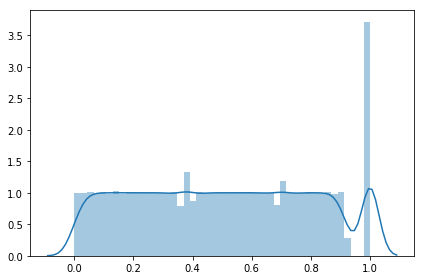

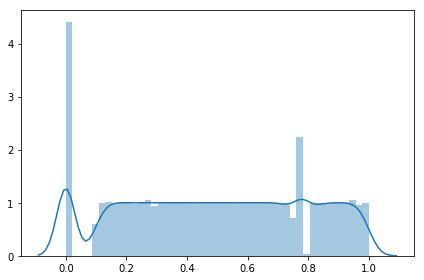

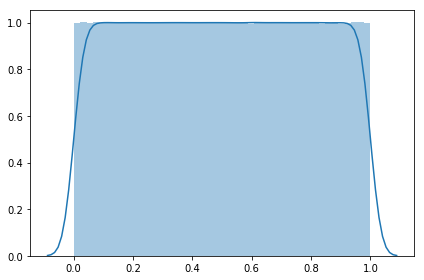

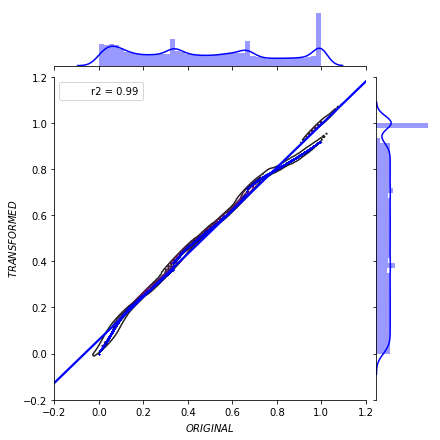

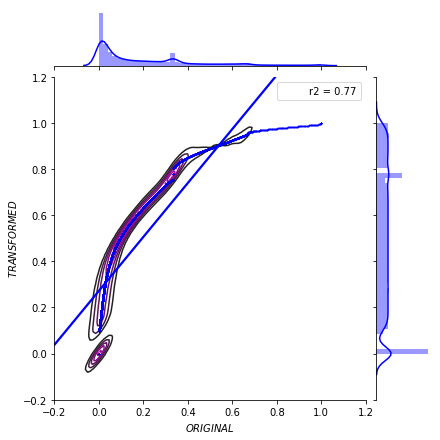

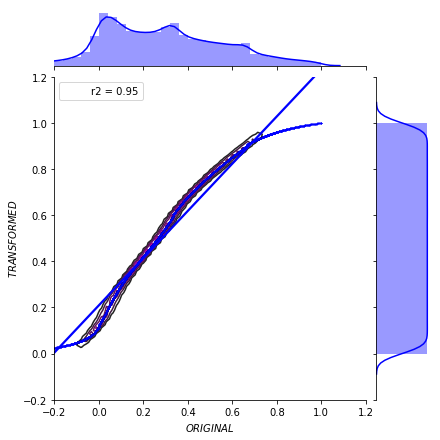

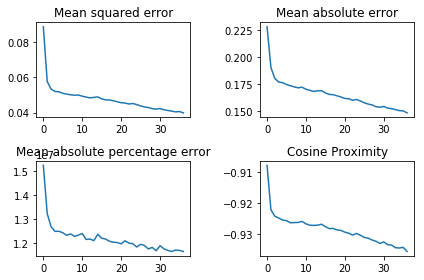

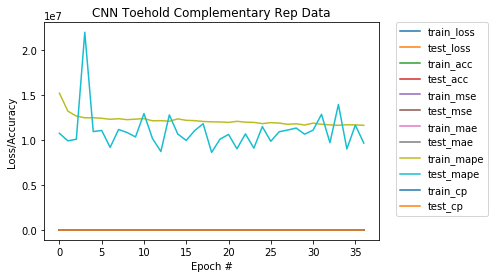

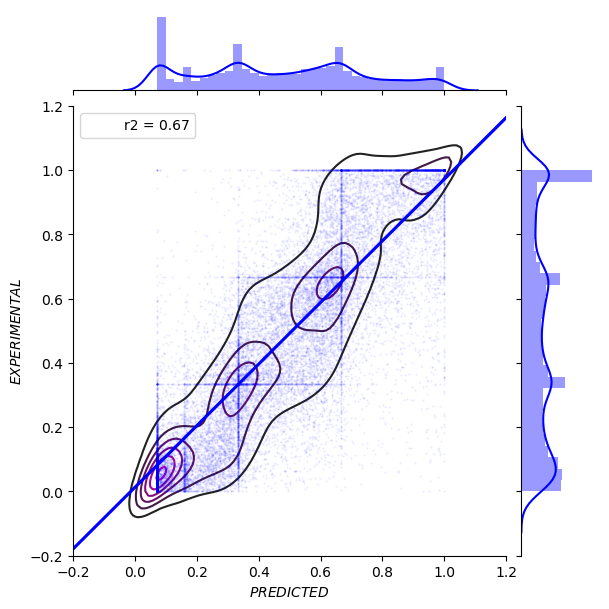

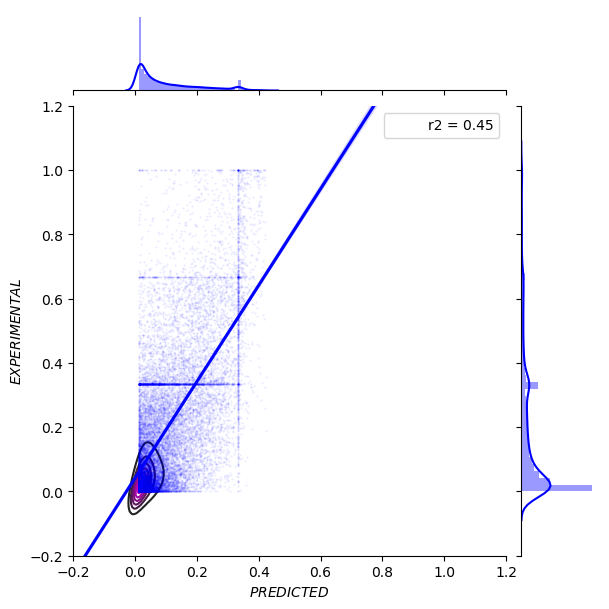

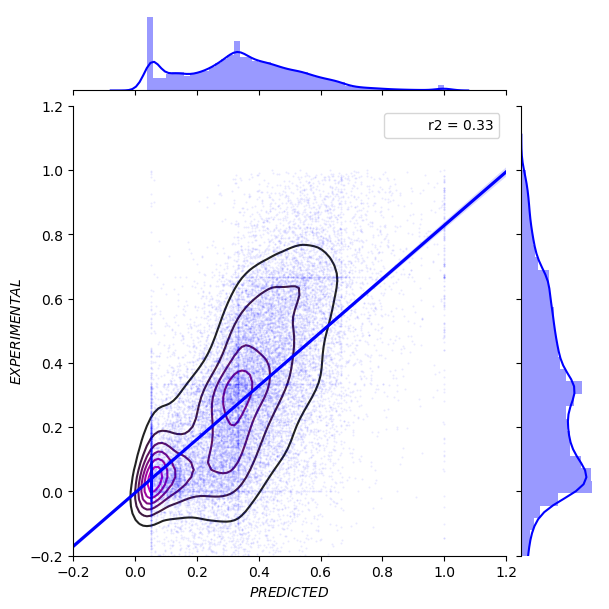

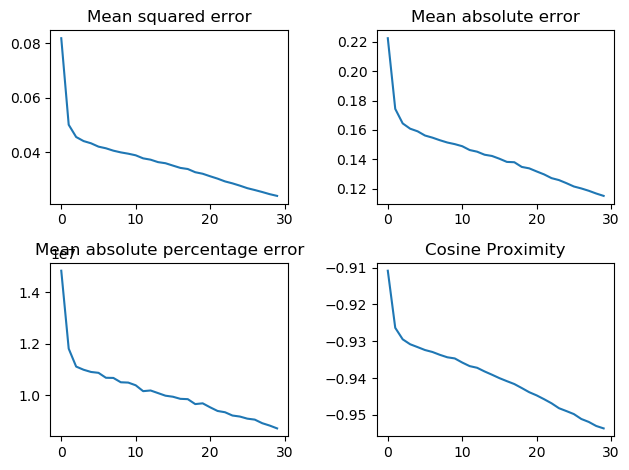

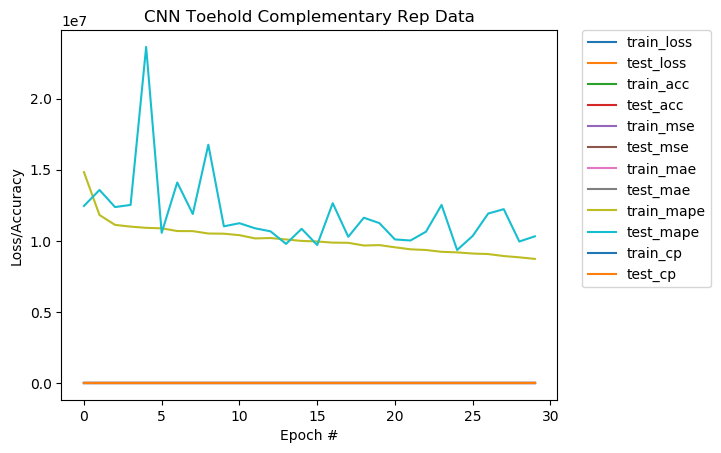

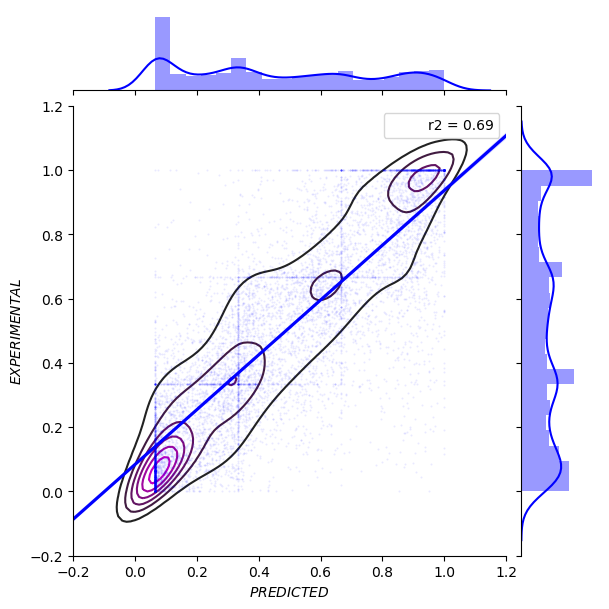

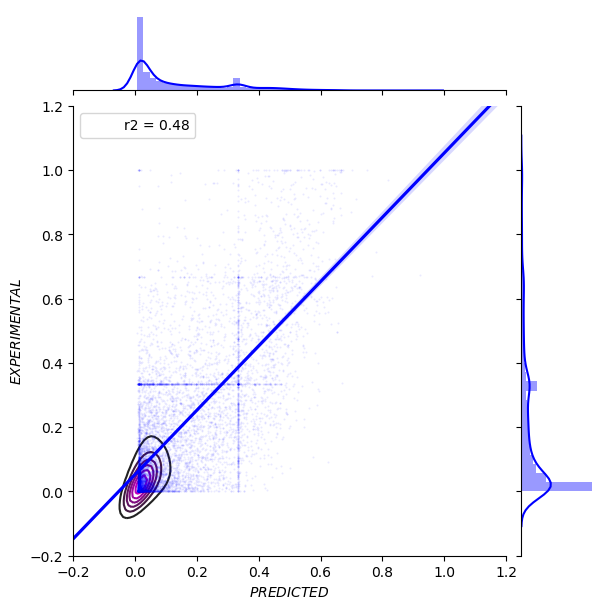

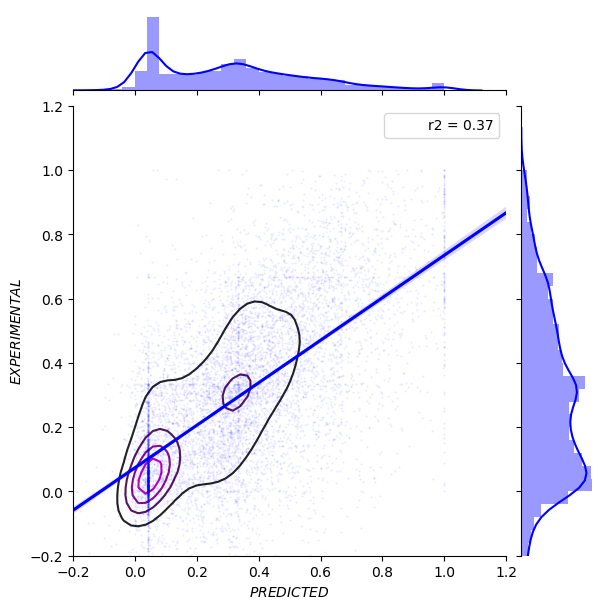

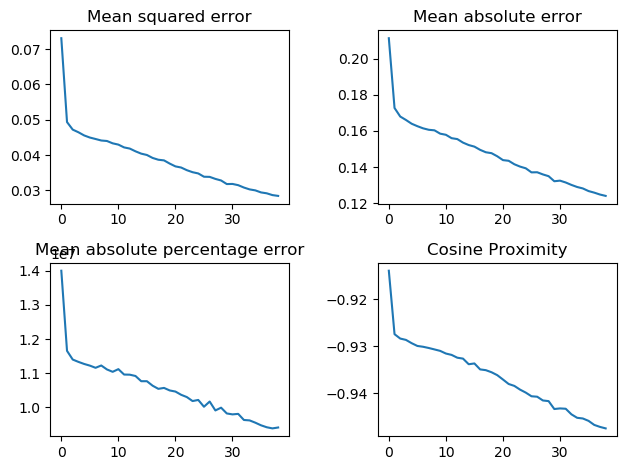

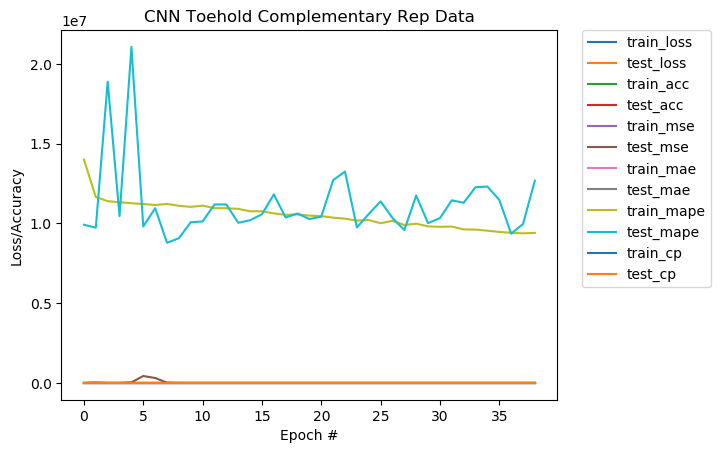

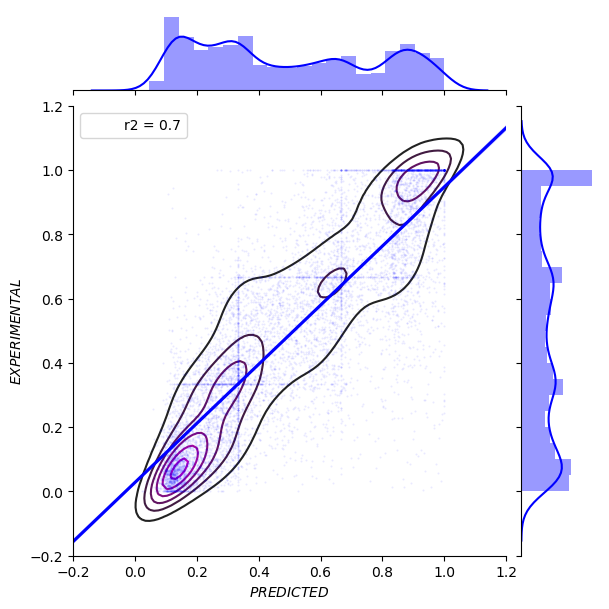

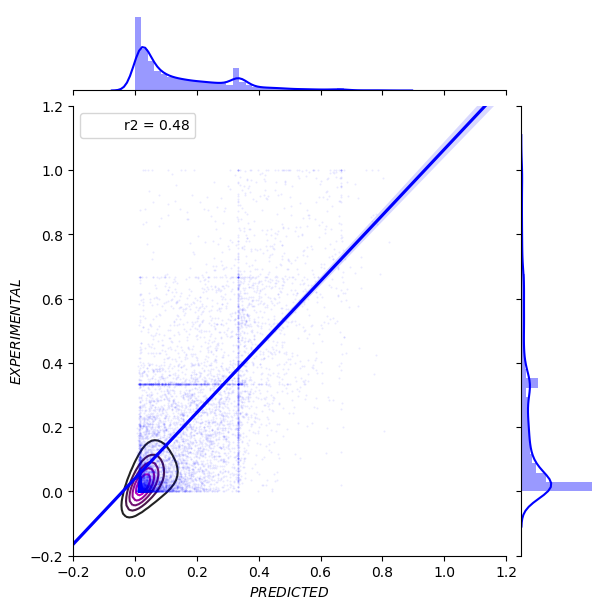

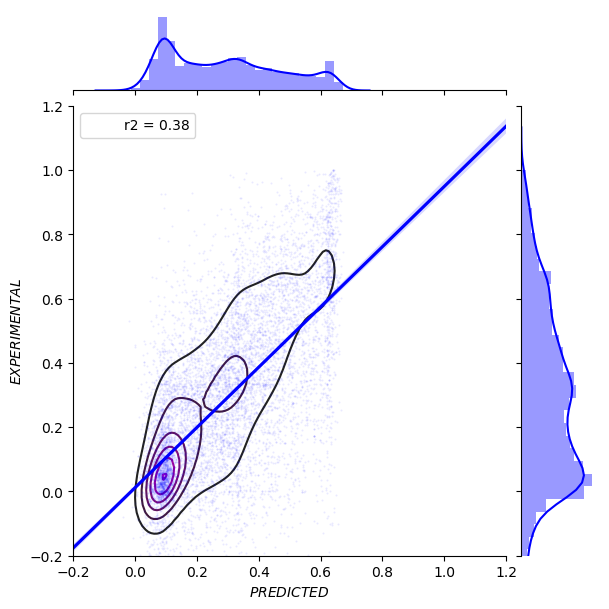

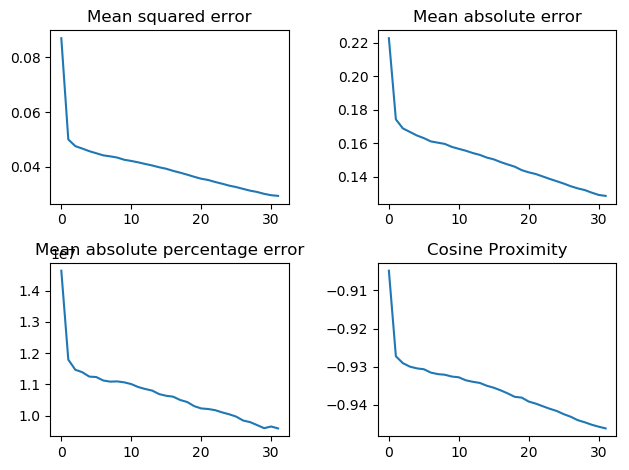

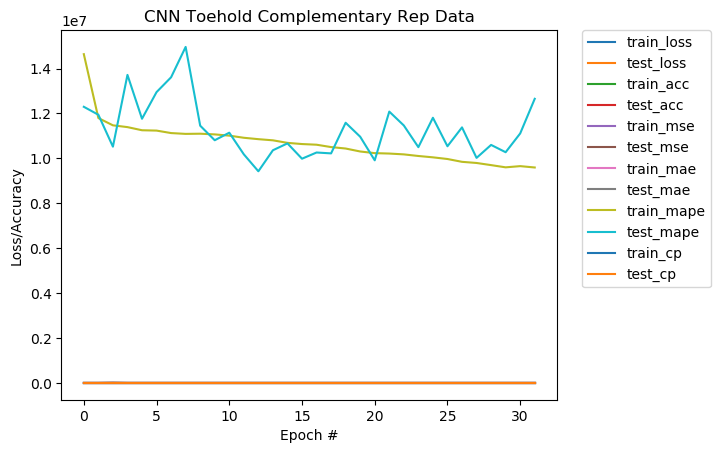

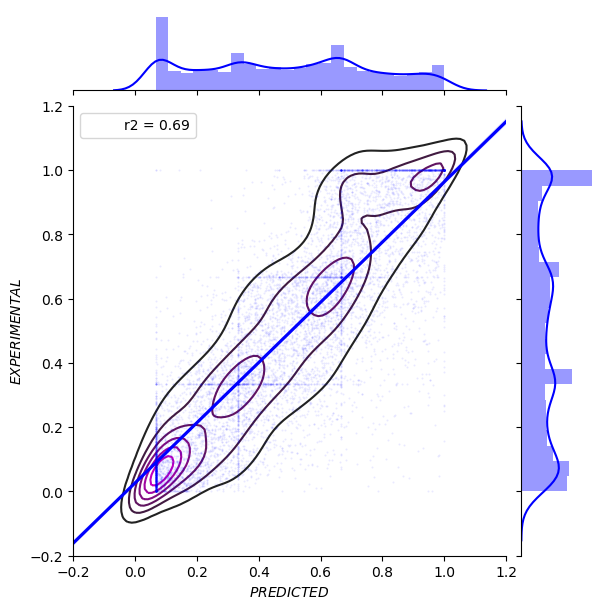

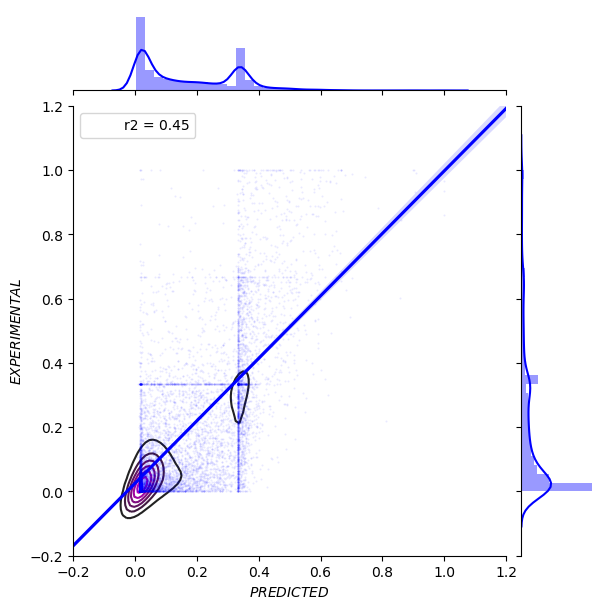

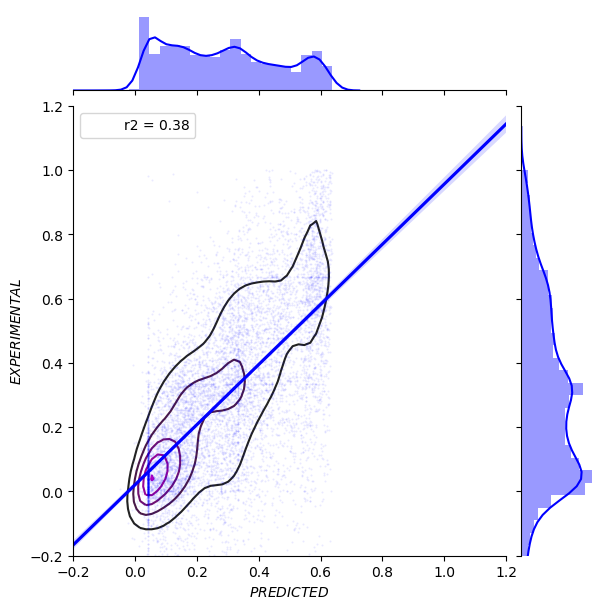

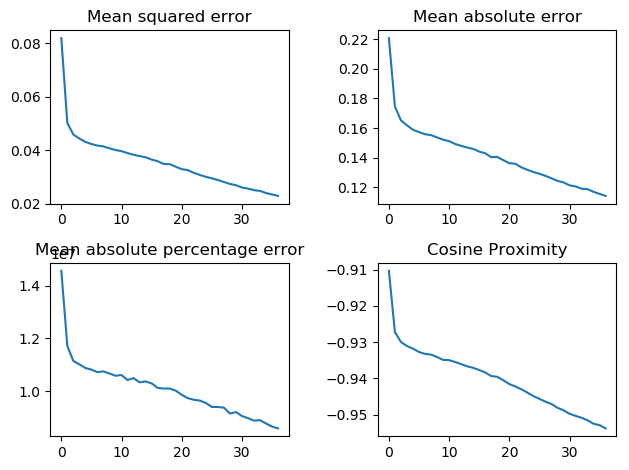

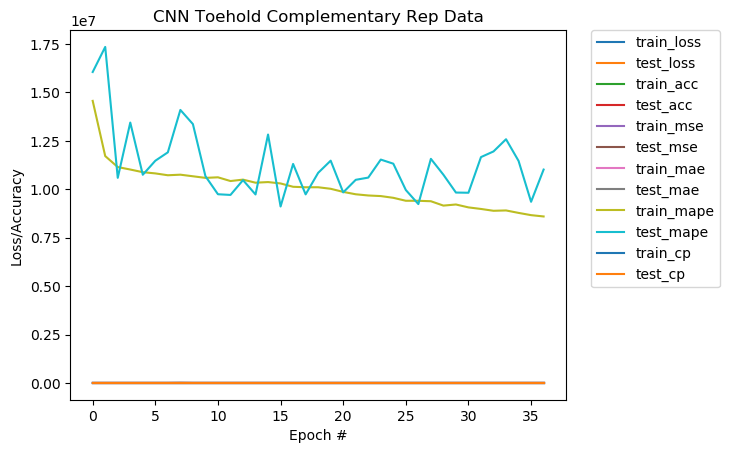

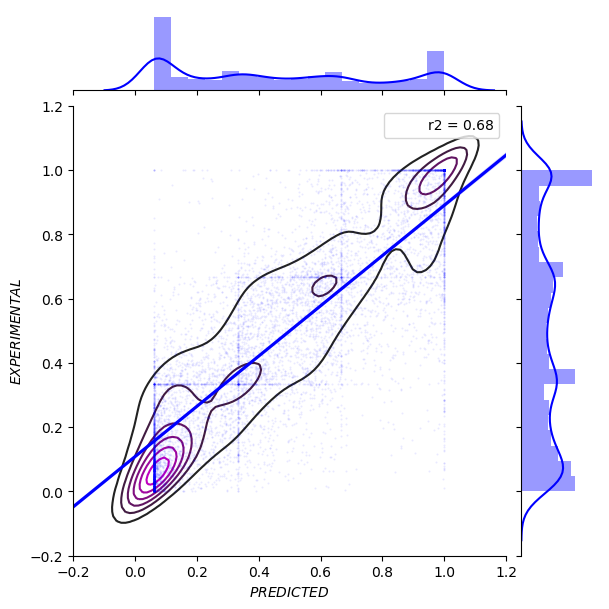

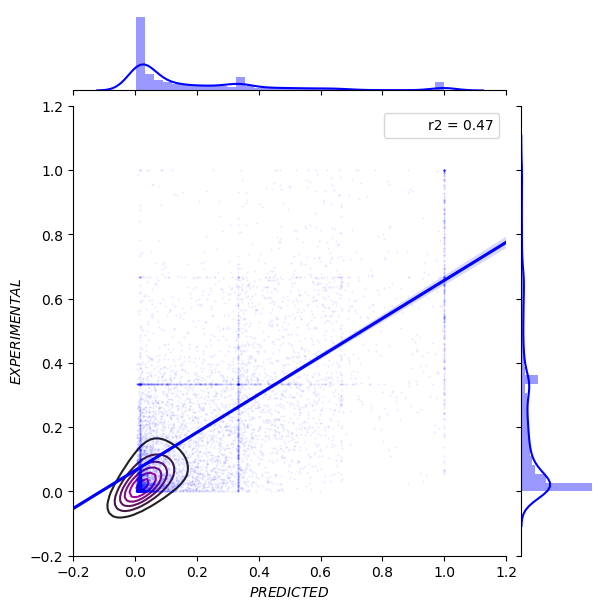

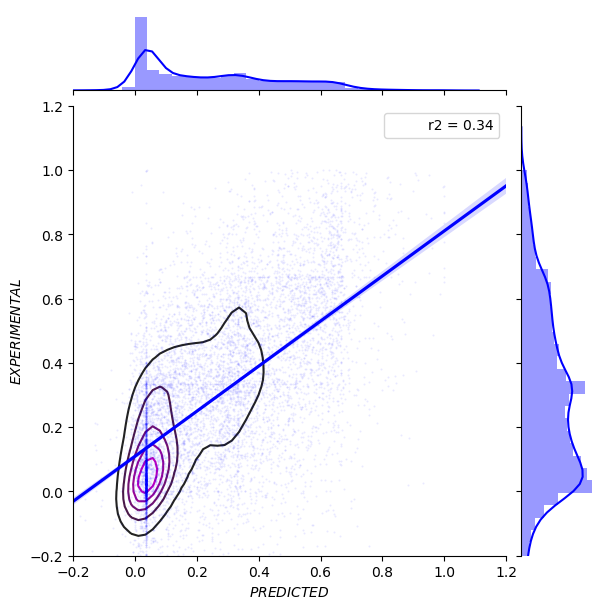

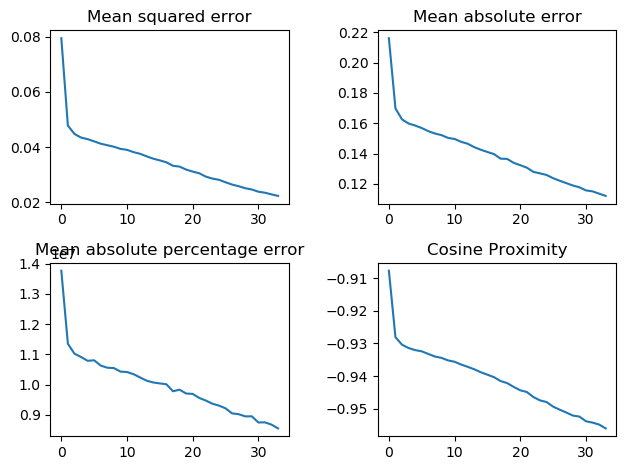

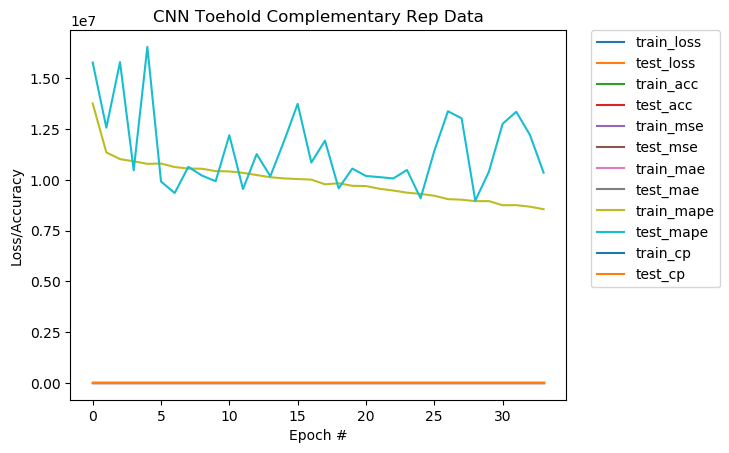

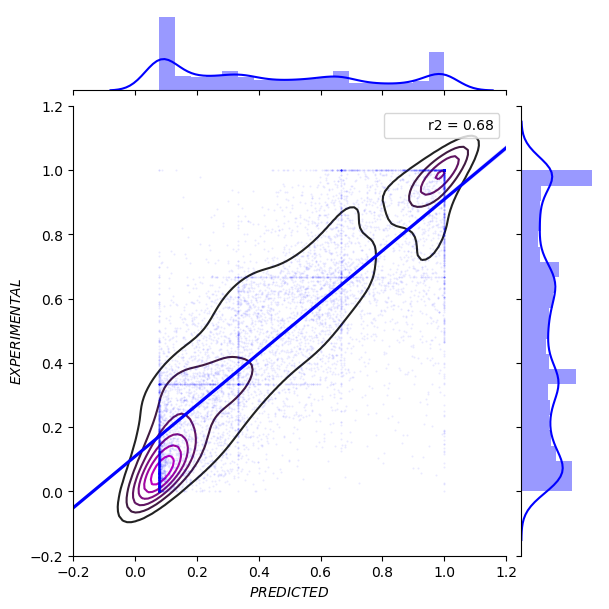

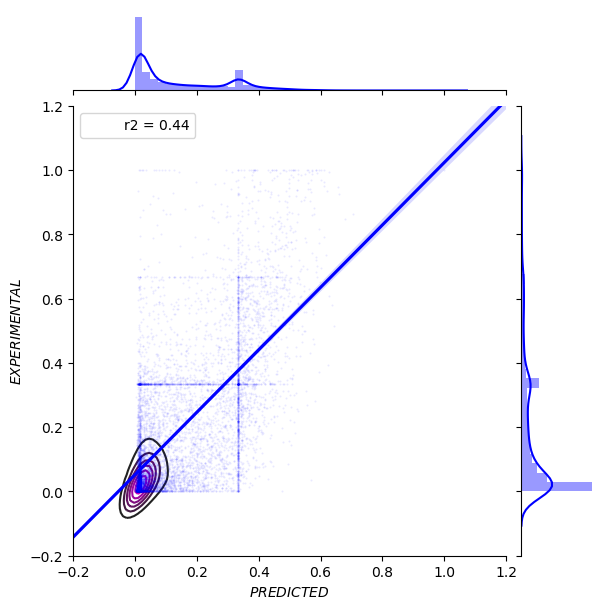

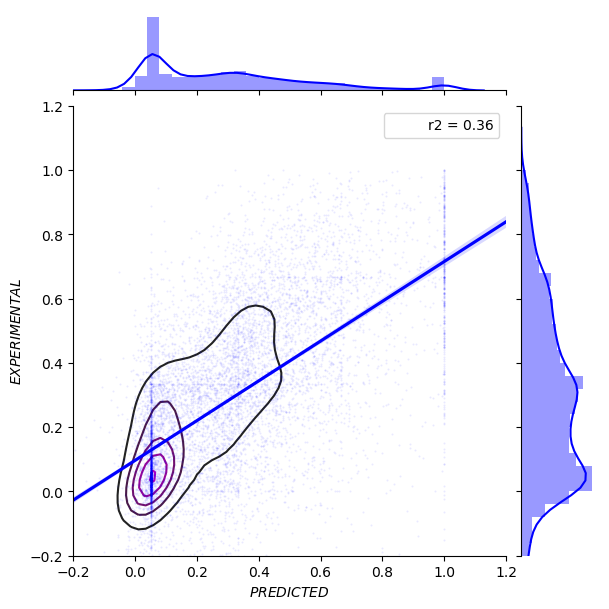

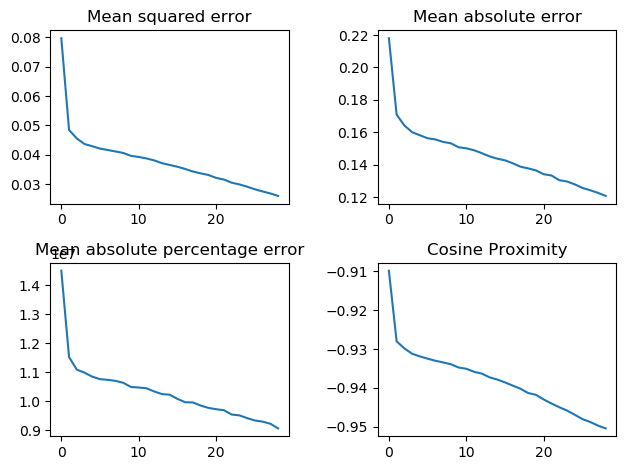

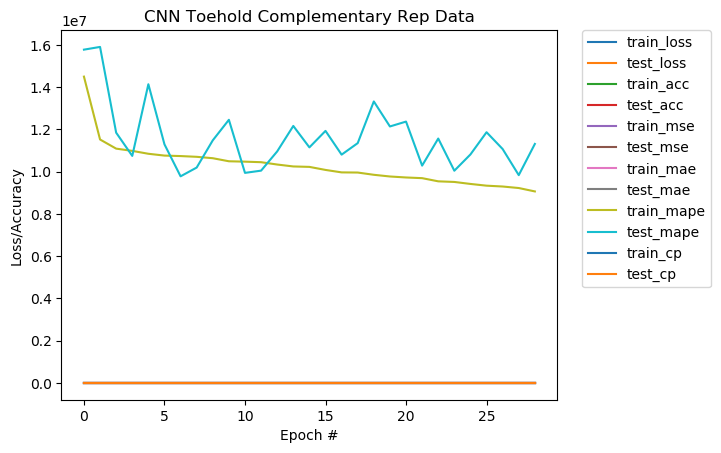

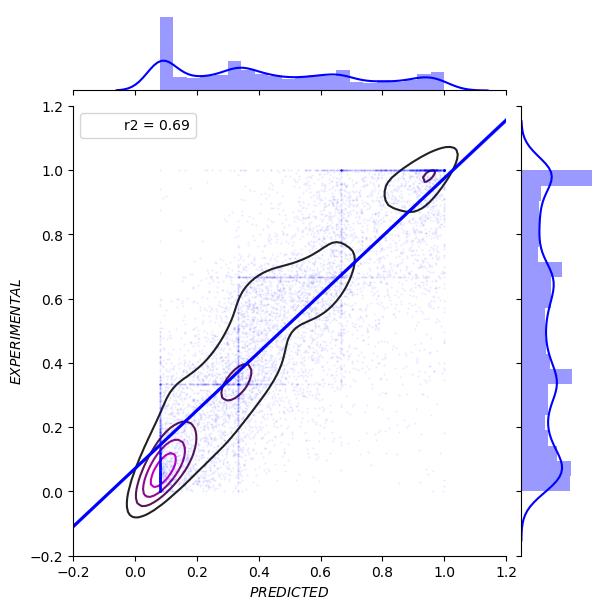

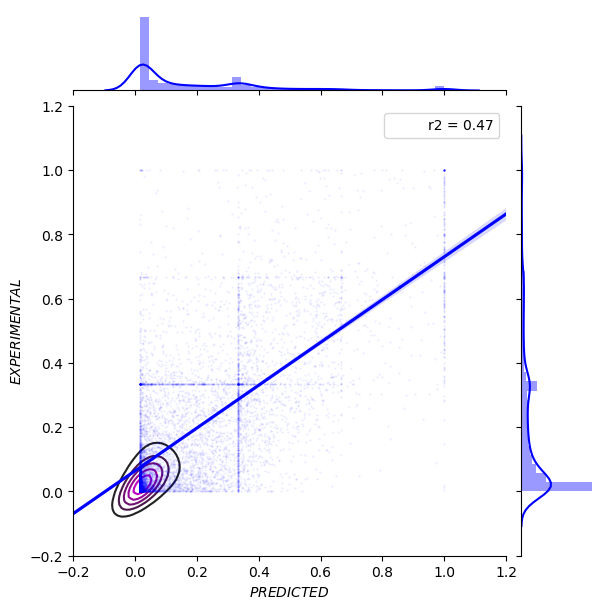

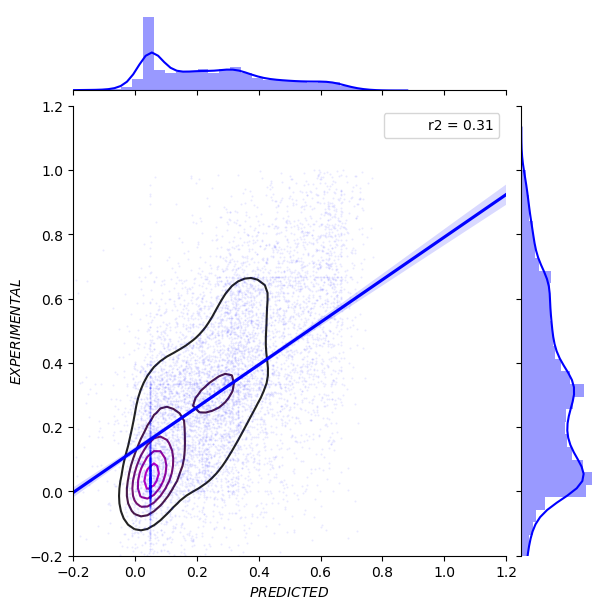

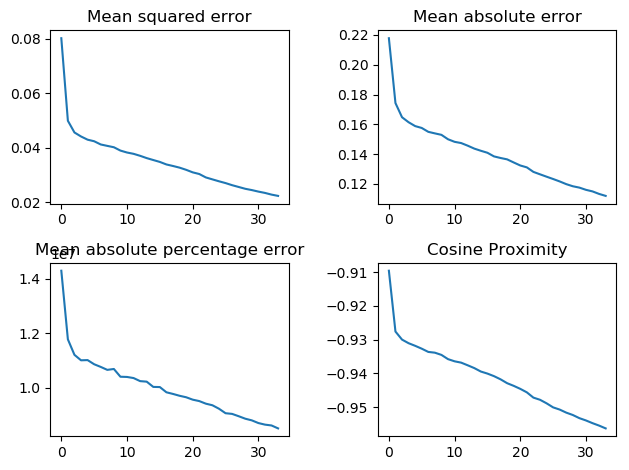

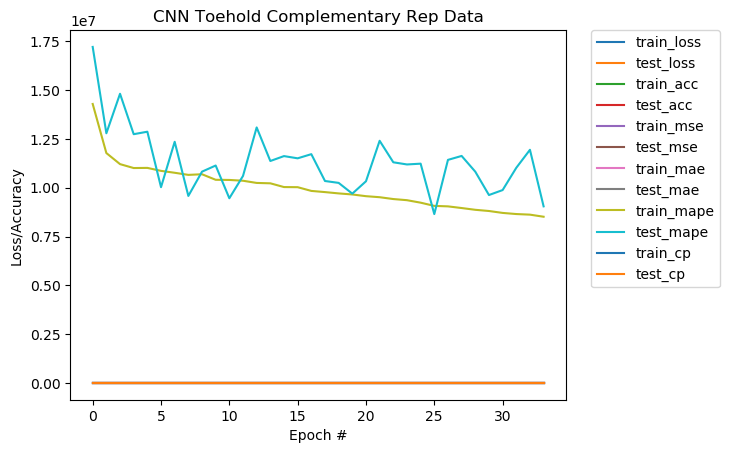

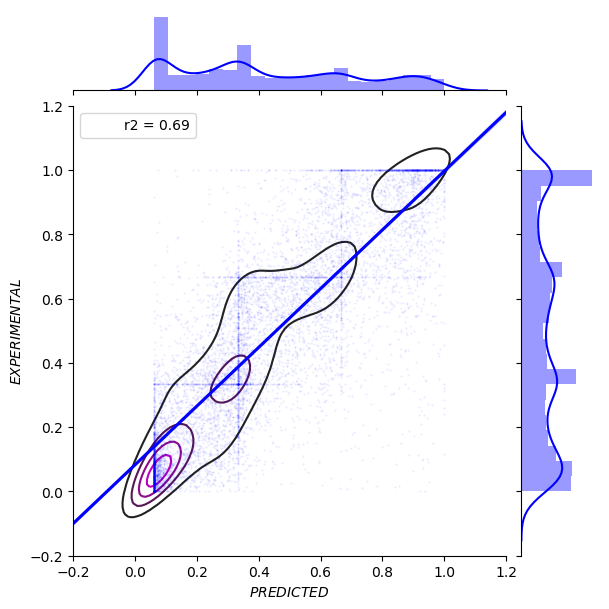

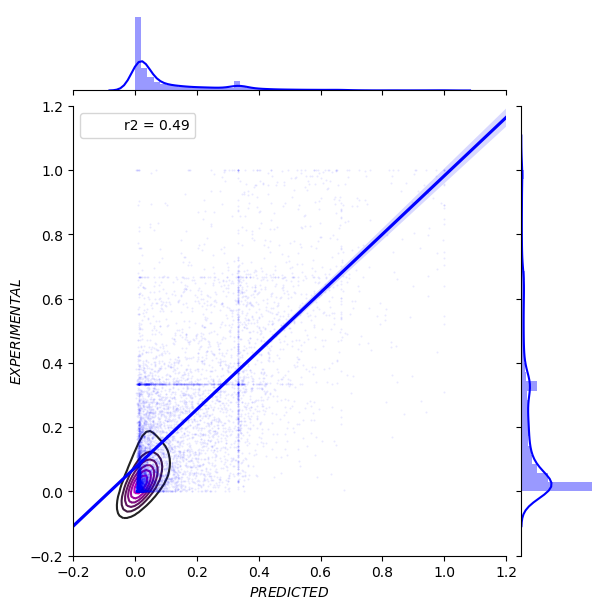

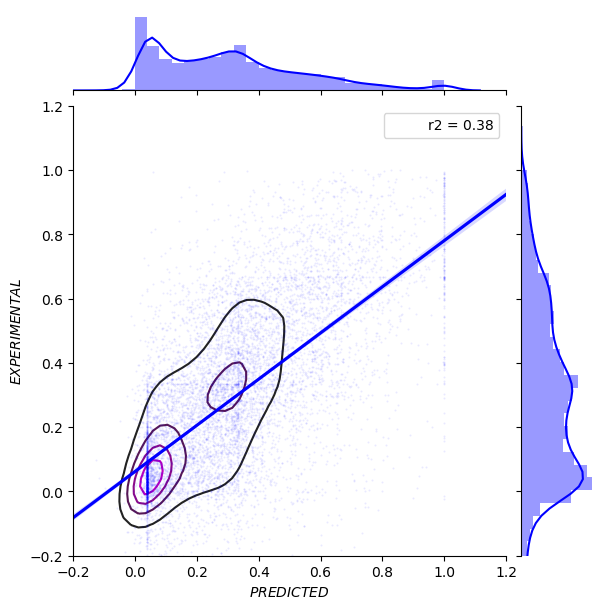

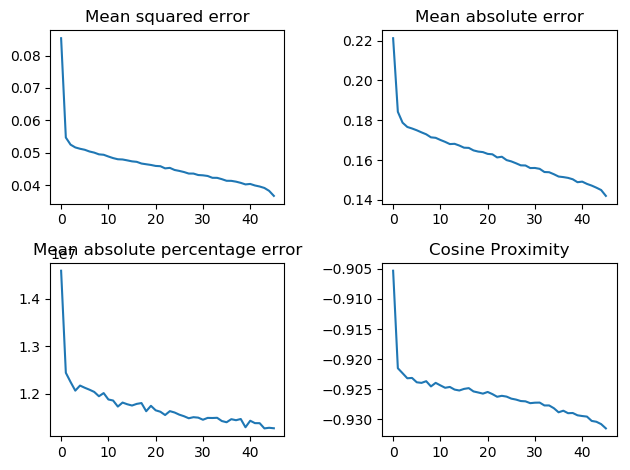

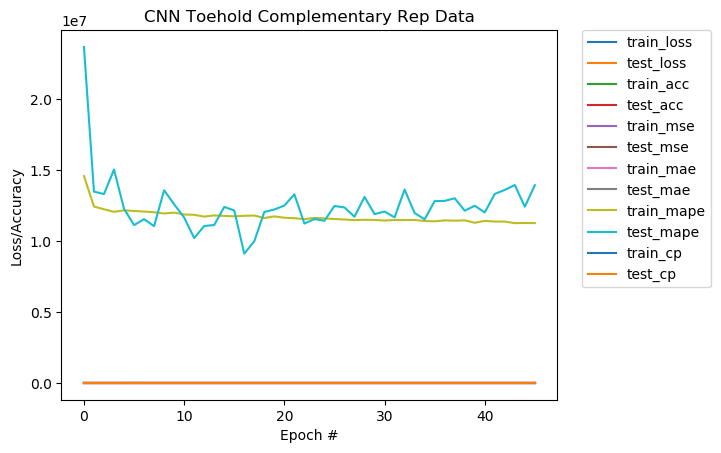

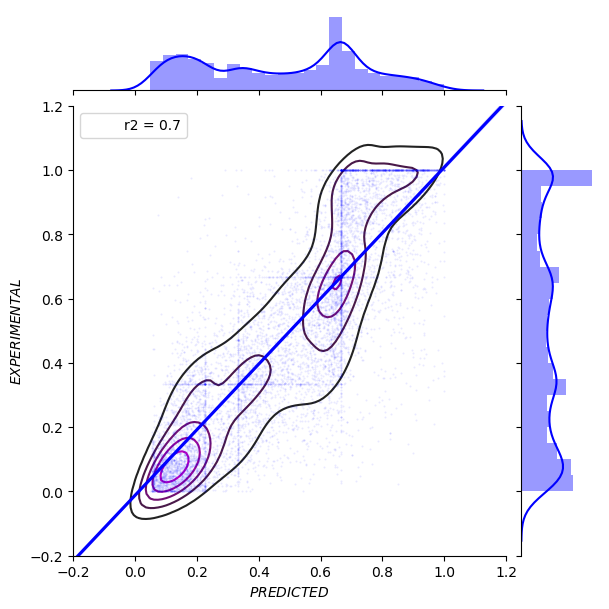

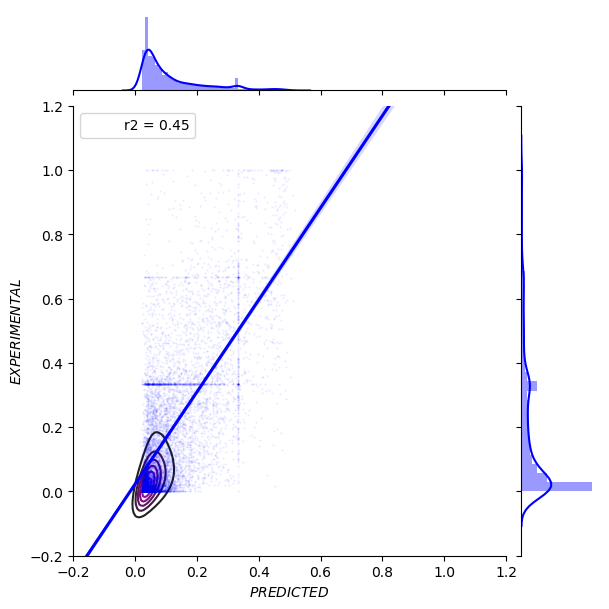

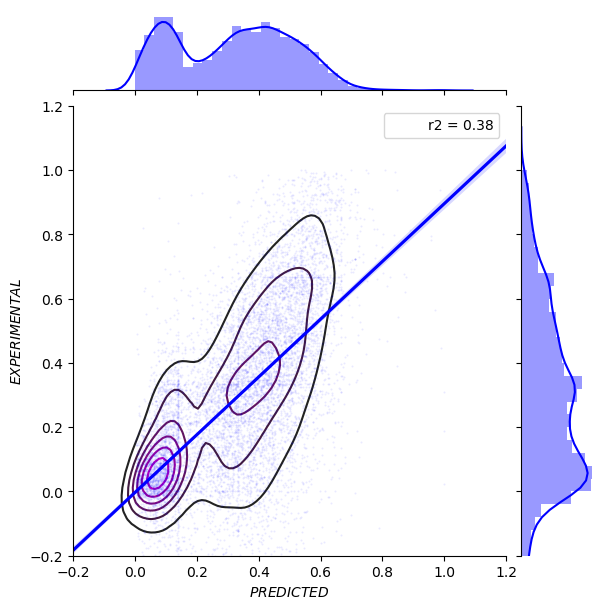

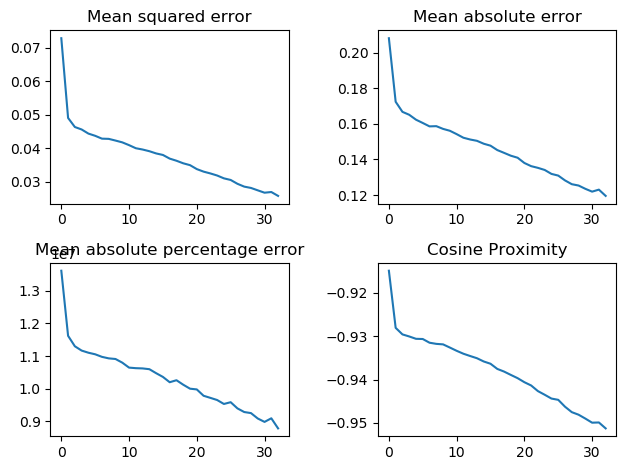

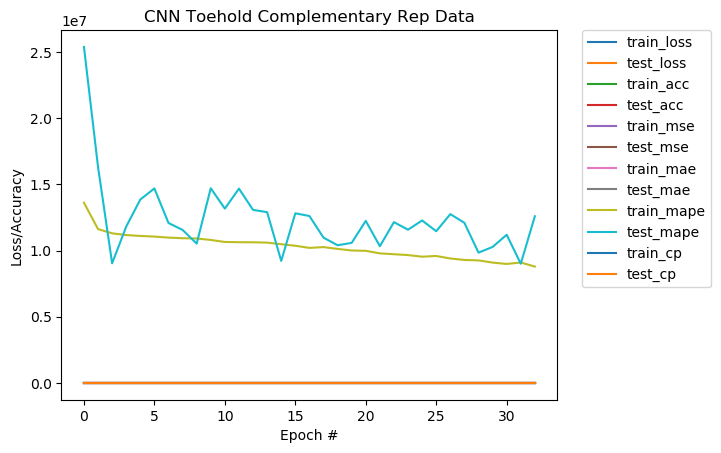

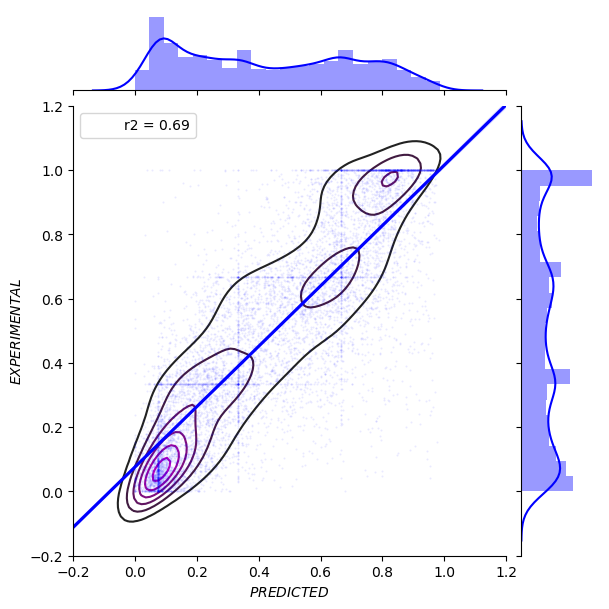

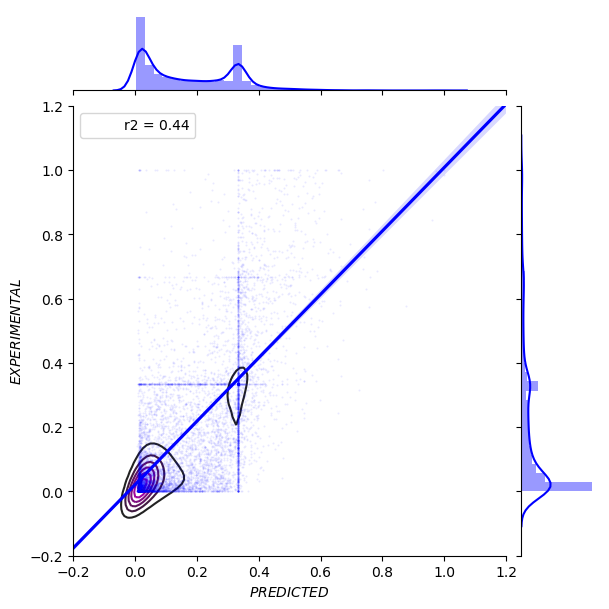

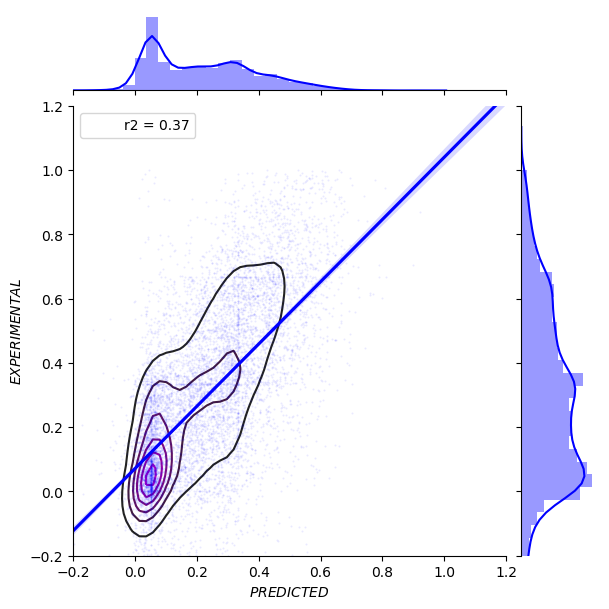

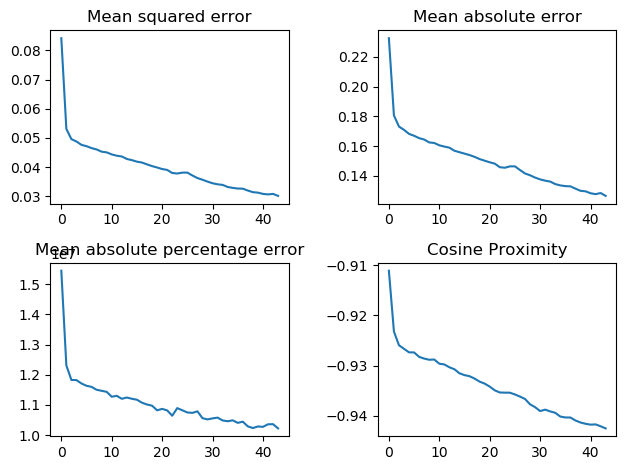

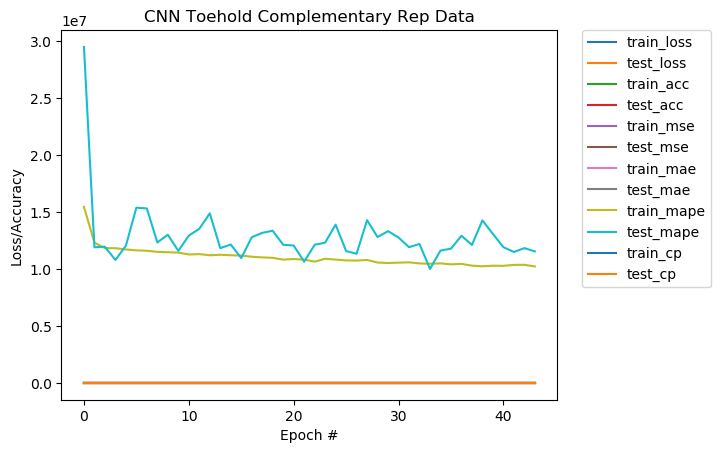

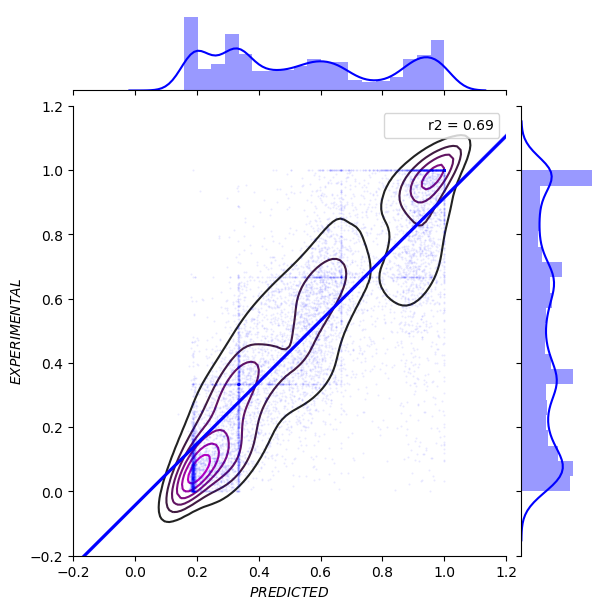

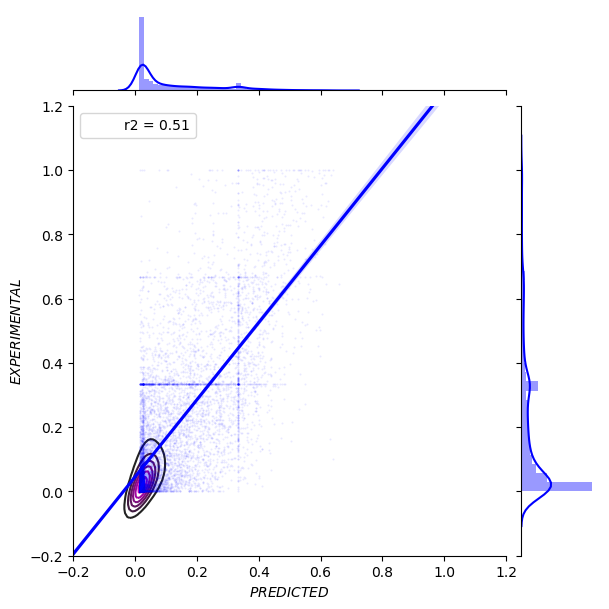

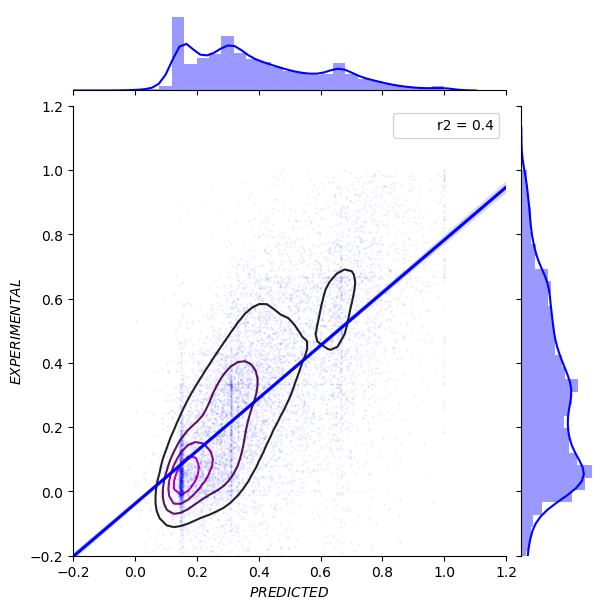

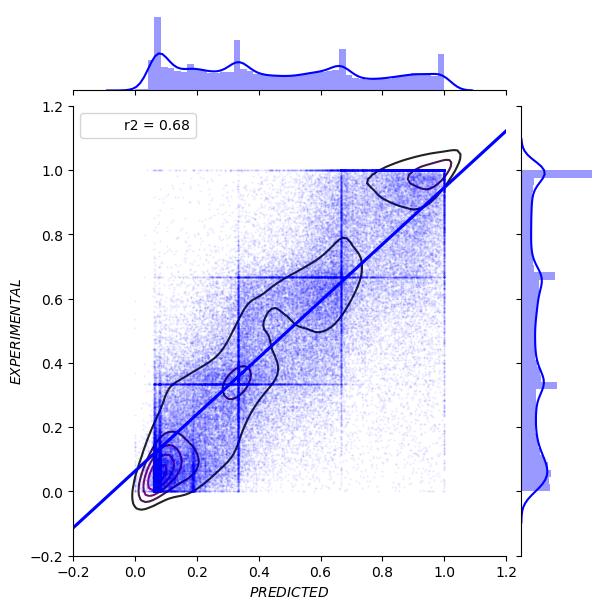

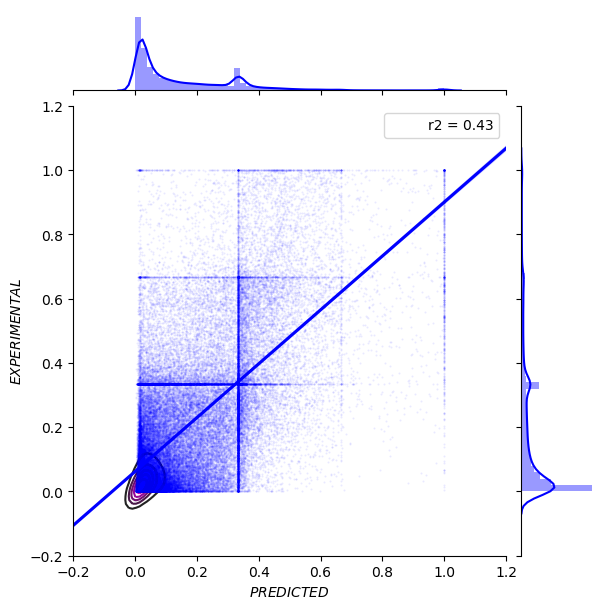

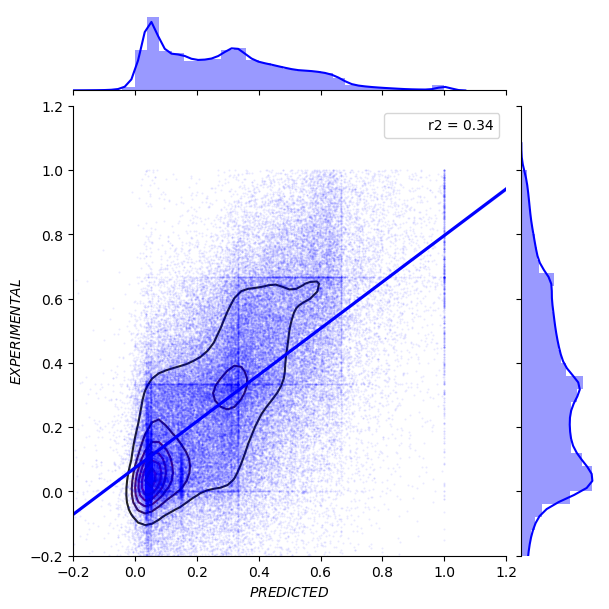

In [18]:
## RUN FULL MODEL ANALYSIS AND REPORTING model
execute_model_analysis(core_models_path, model_name, data, input_cols, output_cols, qc_levels, n_foldCV, verbose_init, evaluate)

-----------------------------------------------------------------------------------------------------------------------------

END OF CODE